# Book Rating ML prediction project

## Project Description
#### Book Rating Prediction Model

“There is no friend as loyal as a book.” - Ernest Hemingway
Nowadays with so many books available, it can be hard to select the best ones to read. The
dataset provided is a curation of Goodreads books based on real user information. It can be
used for many tasks like predicting a book’s rating or recommending new books.
Below is the information you have regarding the dataset attributes:


### Dataset attributes
There are 12 variables:
- bookID: A unique identification number for each book.
- title: The name under which the book was published.
- authors: The names of the authors of the book. Multiple authors are delimited by “/”.
- average_rating: The average rating of the book received in total.
- isbn: Another unique number to identify the book, known as the International Standard Book Number.
- isbn13: A 13-digit ISBN to identify the book, instead of the standard 11-digit ISBN.
- language_code: Indicates the primary language of the book. For instance, “eng” is standard for English.
- num_pages: The number of pages the book contains.
- ratings_count: The total number of ratings the book received.
- text_reviews_count: The total number of written text reviews the book received.
- publication_date: The date the book was published.
- publisher: The name of the book publisher.

In [1]:
#!pip install wordcloud

In [2]:
# importing the necessary libraries
import numpy as np
import pandas as pd
import re # cleaning stage
import matplotlib.pyplot as plt # analysis stage
import seaborn as sns # analysis stage
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # analysis stage
import plotly.express as px # analysis stage
from sklearn.preprocessing import LabelEncoder # feature selection stage
from sklearn.model_selection import train_test_split # feature selection stage
from sklearn.ensemble import RandomForestClassifier # feature selection stage
from sklearn.svm import SVC # feature selection stage
from sklearn.model_selection import StratifiedKFold # feature selection stage
from sklearn.feature_selection import RFECV # feature selection stage
from sklearn.datasets import make_classification # feature selection stage

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# read the original dataset and the one from Google API 
dataset = pd.read_csv("books.csv", encoding='UTF-8',on_bad_lines='skip')
dataset2 = pd.read_csv("books-open-book.csv", encoding='UTF-8',on_bad_lines='skip')

In [4]:
# make a copy of dataframe to keep both in memory
df1 = dataset.copy() # use a copy in order to not modifying the original df
df2 = dataset2.copy()

In [5]:
df2.shape

(11123, 9)

In [6]:
# merging of df1 & df2 in cdf (complete dataframe)
cdf = pd.merge(df1, df2, left_on="isbn", right_on="ISBN", how='inner')

In [7]:
# inspect shape of the dataframe
cdf.shape

(11123, 21)

## Preliminary Data Cleaning
###### Dealing with missing values
- fill NA in Title with value in column title
- fill NA in Author with value in column authors
- fill NA in Publishing_Date with value in column publication_date

In [8]:
cdf.isna().sum()

bookID                   0
title                    0
authors                  0
average_rating           0
isbn                     0
isbn13                   0
language_code            0
  num_pages              0
ratings_count            0
text_reviews_count       0
publication_date         0
publisher                0
Unnamed: 0               0
ISBN                     0
Title                   21
Author                 107
Publishing_Date        158
Subject_list           752
Subject_places        6595
Subject_people        8131
Description           8369
dtype: int64

In [9]:
# Fill ‘Title’ con ‘title’ della stessa row

cdf.loc[(cdf["Title"].isna()) & (~cdf["title"].isna()), "Title"] = \
cdf[(cdf["Title"].isna()) & (~cdf["title"].isna())]["title"]

In [10]:
# Fill ‘Author’ con 'authors' della stessa row

cdf.loc[(cdf["Author"].isna()) & (~cdf["authors"].isna()), "Author"] = \
cdf[(cdf["Author"].isna()) & (~cdf["authors"].isna())]["authors"]

In [11]:
# Fill ‘Publishing_Date’ con 'publication_date' della stessa row

cdf.loc[(cdf["Publishing_Date"].isna()) & (~cdf["publication_date"].isna()), "Publishing_Date"] = \
cdf[(cdf["Publishing_Date"].isna()) & (~cdf["publication_date"].isna())]["publication_date"]

In [12]:
# Fill ‘Subject_list’ con ‘Description’ della stessa row

cdf.loc[(cdf["Subject_list"].isna()) & (~cdf["Description"].isna()), "Description"] = \
cdf[(cdf["Subject_list"].isna()) & (~cdf["Description"].isna())]["Subject_list"]

In [13]:
# Fill ‘Subject_list’ con ‘Subject_people’ della stessa row

cdf.loc[(cdf["Subject_list"].isna()) & (~cdf["Subject_people"].isna()), "Subject_people"] = \
cdf[(cdf["Subject_list"].isna()) & (~cdf["Subject_people"].isna())]["Subject_list"]

In [14]:
cdf.isna().sum()

bookID                   0
title                    0
authors                  0
average_rating           0
isbn                     0
isbn13                   0
language_code            0
  num_pages              0
ratings_count            0
text_reviews_count       0
publication_date         0
publisher                0
Unnamed: 0               0
ISBN                     0
Title                    0
Author                   0
Publishing_Date          0
Subject_list           752
Subject_places        6595
Subject_people        8144
Description           8439
dtype: int64

In [15]:
cdf['Subject_list'].value_counts().sum()

10371

In [16]:
# too many unique values for subject list that should provide information on the genre of the book, we can identify the genres using some key words
# we look for this key words inside the value (string) od 'Subject_list', but before we put all strings in lowercase and fill the NA with 'not specified'

In [17]:
cdf['Subject_list']=cdf['Subject_list'].str.lower()

In [18]:
cdf['Subject_list'] = cdf['Subject_list'].fillna(value='not specified')

In [19]:
bool_serie= (cdf['Subject_list'].str.contains(r'fanta'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

1168

In [20]:
cdf.loc[bool_serie,'Subject_list' ] = 'fantasy'

In [21]:
bool_serie= (cdf['Subject_list'].str.contains(r'comic|graphic|strip|manga'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

533

In [22]:
cdf.loc[bool_serie,'Subject_list' ] = 'comics'

In [23]:
bool_serie= (cdf['Subject_list'].str.contains(r'histo|war|evolu|civiliz'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

2555

In [24]:
cdf.loc[bool_serie,'Subject_list' ] = 'historical'

In [25]:
bool_serie= (cdf['Subject_list'].str.contains(r'autob|biogr|memoi|life|intervie|memor'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

1291

In [26]:
cdf.loc[bool_serie,'Subject_list' ] = 'autobiography-biography'

In [27]:
bool_serie= (cdf['Subject_list'].str.contains(r'social|polit|critic|psich|mental|think|psych|imper|democ'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

874

In [28]:
cdf.loc[bool_serie,'Subject_list' ] = 'social-political'

In [29]:
bool_serie= (cdf['Subject_list'].str.contains(r'relig|philos|spirit|bibl|koran|christ|god|cult|will|immort|plato|church|musl|angel|ethic|theol|doctr|devot|faith|evang'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

475

In [30]:
cdf.loc[bool_serie,'Subject_list' ] = 'religious-philosophical'

In [31]:
bool_serie= (cdf['Subject_list'].str.contains(r'theat|play|poet|musical|music|sound'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

252

In [32]:
cdf.loc[bool_serie,'Subject_list' ] = 'poetry-theatre-music'

In [33]:
bool_serie= (cdf['Subject_list'].str.contains(r'dram'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

92

In [34]:
cdf.loc[bool_serie,'Subject_list' ] = 'drama'

In [35]:
bool_serie= (cdf['Subject_list'].str.contains(r'fabl|fair'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

32

In [36]:
cdf.loc[bool_serie,'Subject_list' ] = 'fable-fairytale'

In [37]:
bool_serie= (cdf['Subject_list'].str.contains(r'myth|folk'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

34

In [38]:
cdf.loc[bool_serie,'Subject_list' ] = 'mithology-folklore'

In [39]:
bool_serie= (cdf['Subject_list'].str.contains(r'acti|adven'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

177

In [40]:
cdf.loc[bool_serie,'Subject_list' ] = 'action-adventure'

In [41]:
bool_serie= (cdf['Subject_list'].str.contains(r'myste|crime|detectiv|murd'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

488

In [42]:
cdf.loc[bool_serie,'Subject_list' ] = 'mystery'

In [43]:
bool_serie= (cdf['Subject_list'].str.contains(r'romanc|love|coupl|romant|passio'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

230

In [44]:
cdf.loc[bool_serie,'Subject_list' ] = 'romance'

In [45]:
bool_serie= (cdf['Subject_list'].str.contains(r'horr|thrill|suspen'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

183

In [46]:
cdf.loc[bool_serie,'Subject_list' ] = 'horror-thriller'

In [47]:
bool_serie= (cdf['Subject_list'].str.contains(r'fiction'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

1196

In [48]:
cdf.loc[bool_serie,'Subject_list' ] = 'fiction'

In [49]:
bool_serie= (cdf['Subject_list'].str.contains(r'essay'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

25

In [50]:
cdf.loc[bool_serie,'Subject_list' ] = 'essay'

In [51]:
bool_serie= (cdf['Subject_list'].str.contains(r'guide|how'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

27

In [52]:
cdf.loc[bool_serie,'Subject_list' ] = 'guidebook'

In [53]:
bool_serie= (cdf['Subject_list'].str.contains(r'game|pok|card'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

19

In [54]:
cdf.loc[bool_serie,'Subject_list' ] = 'games'

In [55]:
bool_serie= (cdf['Subject_list'].str.contains(r'science|medic|physic|prevent|drug|stud|analy|math|algeb|calc|ology|enginee|statis|theor|stat'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

179

In [56]:
cdf.loc[bool_serie,'Subject_list' ] = 'science-medicine'

In [57]:
bool_serie= (cdf['Subject_list'].str.contains(r'comedy|humour|synt|hum'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

32

In [58]:
cdf.loc[bool_serie,'Subject_list' ] = 'humour'

In [59]:
bool_serie= (cdf['Subject_list'].str.contains(r'art|craft|phot|paint|pict|portr|colour|draw|creat|aest|design|patch|visual|color'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

94

In [60]:
cdf.loc[bool_serie,'Subject_list' ] = 'art'

In [61]:
bool_serie= (cdf['Subject_list'].str.contains(r'econo|busine|manag|market|buy|law|finan|sell'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

51

In [62]:
cdf.loc[bool_serie,'Subject_list' ] = 'business-economy'

In [63]:
bool_serie= (cdf['Subject_list'].str.contains(r'languag|grammat|synt|liter|tradu|diction|encyc|transl'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

88

In [64]:
cdf.loc[bool_serie,'Subject_list' ] = 'language'

In [65]:
bool_serie= (cdf['Subject_list'].str.contains(r'letter|corresp|aphor'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

12

In [66]:
cdf.loc[bool_serie,'Subject_list' ] = 'language'

In [67]:
bool_serie= (cdf['Subject_list'].str.contains(r'animal|natur|dog|fauna|pet|beast|green|geo|plant|garde|organic|flowe'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

13

In [68]:
cdf.loc[bool_serie,'Subject_list' ] = 'nature-animals'

In [69]:
bool_serie= (cdf['Subject_list'].str.contains(r'novel|story|narrat|stor|auth'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

2578

In [70]:
cdf.loc[bool_serie,'Subject_list' ] = 'novel-narrative'

In [71]:
bool_serie= (cdf['Subject_list'].str.contains(r'short'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

0

In [72]:
cdf.loc[bool_serie,'Subject_list' ] = 'short-story'

In [73]:
bool_serie= (cdf['Subject_list'].str.contains(r'trave|vojag|car|bicy|bike'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

25

In [74]:
cdf.loc[bool_serie,'Subject_list' ] = 'travel'

In [75]:
bool_serie= (cdf['Subject_list'].str.contains(r'cook|food|eat|wine|bever|drink'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

312

In [76]:
cdf.loc[bool_serie,'Subject_list' ] = 'food'

In [77]:
bool_serie= (cdf['Subject_list'].str.contains(r'mind|body|consci|medit|diet|grow|achie|goal|sport|healt'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

11

In [78]:
cdf.loc[bool_serie,'Subject_list' ] = 'mind-meditation'

In [79]:
bool_serie= (cdf['Subject_list'].str.contains(r'woman|sex|wif|wiv|child|matern|women|relation'))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

14

In [80]:
cdf.loc[bool_serie,'Subject_list' ] = 'woman'

In [81]:
#last group 'mixed' for those whose genre couln't be classified
bool_serie = (~cdf["Subject_list"].str.contains('|'.join(['novel-narrative','autobiography-biography','fiction','fantasy','social-political','not specified','comics','mystery','religious-philosophical','food','romance','horror-thriller','action-adventure','language','drama','science-medicine','art','business-economy','humour','mithology-folklore','fable-fairytale','travel','guidebook','nature-animals','essay','games','mind-meditation','woman'] )))
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().head(200)

series:fullmetal_alchemist                                                                                                                  8
old time radio,sherlock holmes                                                                                                              2
collectionid:stmisc                                                                                                                         2
new york times reviewed                                                                                                                     2
accessible book                                                                                                                             1
parishes                                                                                                                                    1
antisemitism                                                                                                                                1
shaman

In [82]:
cdf.loc[bool_serie,'Subject_list' ] = 'mixed'

In [83]:
cdf['Subject_list'].value_counts().head(60)  #752 missing 'not specified', 152 'mixed'

novel-narrative            2578
autobiography-biography    1291
fiction                    1196
fantasy                    1168
social-political            874
not specified               752
comics                      533
mystery                     488
religious-philosophical     475
food                        312
romance                     230
horror-thriller             183
science-medicine            179
action-adventure            177
mixed                       152
language                    100
art                          94
drama                        92
business-economy             51
fable-fairytale              32
humour                       32
guidebook                    27
travel                       25
essay                        25
games                        19
woman                        14
nature-animals               13
mind-meditation              11
Name: Subject_list, dtype: int64

In [84]:
np.size(cdf['Subject_list'].unique()) #28 genres for Subject_list

28

In [85]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11123 entries, 0 to 11122
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11123 non-null  int64  
 1   title               11123 non-null  object 
 2   authors             11123 non-null  object 
 3   average_rating      11123 non-null  float64
 4   isbn                11123 non-null  object 
 5   isbn13              11123 non-null  int64  
 6   language_code       11123 non-null  object 
 7     num_pages         11123 non-null  int64  
 8   ratings_count       11123 non-null  int64  
 9   text_reviews_count  11123 non-null  int64  
 10  publication_date    11123 non-null  object 
 11  publisher           11123 non-null  object 
 12  Unnamed: 0          11123 non-null  int64  
 13  ISBN                11123 non-null  object 
 14  Title               11123 non-null  object 
 15  Author              11123 non-null  object 
 16  Publ

In [86]:
# now repeat to fill 'not specified' in the column 'Subject_list'. Using the str.contains of before we look for those strings in the title and then assign the subject list

In [87]:
cdf['title']=cdf['title'].str.lower()

In [88]:
bool_serie= (cdf['title'].str.contains(r'fanta')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

2

In [89]:
cdf.loc[bool_serie,'Subject_list'] = 'fantasy'

In [90]:
bool_serie= (cdf['title'].str.contains(r'comic|graphic|strip|manga')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

3

In [91]:
cdf.loc[bool_serie,'Subject_list' ] = 'comics'

In [92]:
bool_serie= (cdf['title'].str.contains(r'histo|war|evolu|civiliz')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

37

In [93]:
cdf.loc[bool_serie,'Subject_list' ] = 'historical'

In [94]:
bool_serie= (cdf['title'].str.contains(r'autob|biogr|memoi|life|intervie|memor')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

10

In [95]:
cdf.loc[bool_serie,'Subject_list' ] = 'autobiography-biography'

In [96]:
bool_serie= (cdf['title'].str.contains(r'social|polit|critic|psich|mental|think|psych|imper|democ')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

5

In [97]:
cdf.loc[bool_serie,'Subject_list' ] = 'social-political'

In [98]:
bool_serie= (cdf['title'].str.contains(r'relig|philos|spirit|bibl|koran|christ|god|cult|will|immort|plato|church|musl|angel|ethic|theol|doctr|devot|faith|evang'))  & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

23

In [99]:
cdf.loc[bool_serie,'Subject_list' ] = 'religious-philosophical'

In [100]:
bool_serie= (cdf['title'].str.contains(r'theat|play|poet|musical|music|sound')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

15

In [101]:
cdf.loc[bool_serie,'Subject_list' ] = 'poetry-theatre-music'

In [102]:
bool_serie= (cdf['title'].str.contains(r'dram')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

1

In [103]:
cdf.loc[bool_serie,'Subject_list' ] = 'drama'

In [104]:
bool_serie= (cdf['title'].str.contains(r'fabl|fair')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

3

In [105]:
cdf.loc[bool_serie,'Subject_list' ] = 'fable-fairytale'

In [106]:
bool_serie= (cdf['title'].str.contains(r'myth|folk')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

2

In [107]:
cdf.loc[bool_serie,'Subject_list' ] = 'mithology-folklore'

In [108]:
bool_serie= (cdf['title'].str.contains(r'acti|adven')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['Subject_list'].value_counts().sum()

19

In [109]:
cdf.loc[bool_serie,'Subject_list' ] = 'action-adventure'

In [110]:
bool_serie= (cdf['title'].str.contains(r'myste|crime|detectiv|murd')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

11

In [111]:
cdf.loc[bool_serie,'Subject_list' ] = 'mystery'

In [112]:
bool_serie= (cdf['title'].str.contains(r'romanc|love|coupl|romant|passio')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

8

In [113]:
cdf.loc[bool_serie,'Subject_list' ] = 'romance'

In [114]:
bool_serie= (cdf['title'].str.contains(r'horr|thrill|suspen')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

2

In [115]:
cdf.loc[bool_serie,'Subject_list' ] = 'horror-thriller'

In [116]:
bool_serie= (cdf['title'].str.contains(r'fiction')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

0

In [117]:
cdf.loc[bool_serie,'Subject_list' ] = 'fiction'

In [118]:
bool_serie= (cdf['title'].str.contains(r'essay')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

1

In [119]:
cdf.loc[bool_serie,'Subject_list' ] = 'essay'

In [120]:
bool_serie= (cdf['title'].str.contains(r'guide|how')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

12

In [121]:
cdf.loc[bool_serie,'Subject_list' ] = 'guidebook'

In [122]:
bool_serie= (cdf['title'].str.contains(r'game|pok|card')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

5

In [123]:
cdf.loc[bool_serie,'Subject_list' ] = 'games'

In [124]:
bool_serie= (cdf['title'].str.contains(r'science|medic|physic|prevent|drug|stud|analy|math|algeb|calc|ology|enginee|statis|theor|stat')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

7

In [125]:
cdf.loc[bool_serie,'Subject_list' ] = 'science-medicine'

In [126]:
bool_serie= (cdf['title'].str.contains(r'comedy|humour|synt|hum')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

1

In [127]:
cdf.loc[bool_serie,'Subject_list' ] = 'humour'

In [128]:
bool_serie= (cdf['title'].str.contains(r'art|craft|phot|paint|pict|portr|colour|draw|creat|aest|design|patch|visual|color')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

22

In [129]:
cdf.loc[bool_serie,'Subject_list' ] = 'art'

In [130]:
bool_serie= (cdf['title'].str.contains(r'econo|busine|manag|market|buy|law|finan|sell')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

0

In [131]:
cdf.loc[bool_serie,'Subject_list' ] = 'business-economy'

In [132]:
bool_serie= (cdf['title'].str.contains(r'languag|grammat|synt|liter|tradu|diction|encyc|transl')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

4

In [133]:
cdf.loc[bool_serie,'Subject_list' ] = 'language'

In [134]:
bool_serie= (cdf['title'].str.contains(r'letter|corresp|aphor')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

0

In [135]:
cdf.loc[bool_serie,'Subject_list' ] = 'language'

In [136]:
bool_serie= (cdf['title'].str.contains(r'animal|natur|dog|fauna|pet|beast|green|geo|plant|garde|organic|flowe')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

16

In [137]:
cdf.loc[bool_serie,'Subject_list' ] = 'nature-animals'

In [138]:
bool_serie= (cdf['title'].str.contains(r'novel|story|narrat|stor|auth')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

23

In [139]:
cdf.loc[bool_serie,'Subject_list' ] = 'novel-narrative'

In [140]:
bool_serie= (cdf['title'].str.contains(r'short')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

0

In [141]:
cdf.loc[bool_serie,'Subject_list' ] = 'short-story'

In [142]:
bool_serie= (cdf['title'].str.contains(r'trave|vojag|car|bicy|bike')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

4

In [143]:
cdf.loc[bool_serie,'Subject_list' ] = 'travel'

In [144]:
bool_serie= (cdf['title'].str.contains(r'cook|food|eat|wine|bever|drink')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

11

In [145]:
cdf.loc[bool_serie,'Subject_list' ] = 'food'

In [146]:
bool_serie= (cdf['title'].str.contains(r'mind|body|consci|medit|diet|grow|achie|goal|sport|healt')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

3

In [147]:
cdf.loc[bool_serie,'Subject_list' ] = 'mind-meditation'

In [148]:
bool_serie= (cdf['title'].str.contains(r'woman|sex|wif|wiv|child|matern|women|relation')) & (cdf['Subject_list'] == 'not specified')
df_Other=cdf.loc[bool_serie,:]
df_Other['title'].value_counts().sum()

6

In [149]:
cdf.loc[bool_serie,'Subject_list' ] = 'woman'

In [150]:
cdf['Subject_list'].value_counts().head(60)  # before 752 missing 'not specified' now 496, 152 'mixed'
# something is not working because also other value change (not only not specified)

novel-narrative            2601
autobiography-biography    1301
fiction                    1196
fantasy                    1170
social-political            879
comics                      536
mystery                     499
religious-philosophical     498
not specified               496
food                        323
romance                     238
action-adventure            196
science-medicine            186
horror-thriller             185
mixed                       152
art                         116
language                    104
drama                        93
business-economy             51
guidebook                    39
historical                   37
fable-fairytale              35
humour                       33
travel                       29
nature-animals               29
essay                        26
games                        24
woman                        20
poetry-theatre-music         15
mind-meditation              14
mithology-folklore            2
Name: Su

In [151]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11123 entries, 0 to 11122
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11123 non-null  int64  
 1   title               11123 non-null  object 
 2   authors             11123 non-null  object 
 3   average_rating      11123 non-null  float64
 4   isbn                11123 non-null  object 
 5   isbn13              11123 non-null  int64  
 6   language_code       11123 non-null  object 
 7     num_pages         11123 non-null  int64  
 8   ratings_count       11123 non-null  int64  
 9   text_reviews_count  11123 non-null  int64  
 10  publication_date    11123 non-null  object 
 11  publisher           11123 non-null  object 
 12  Unnamed: 0          11123 non-null  int64  
 13  ISBN                11123 non-null  object 
 14  Title               11123 non-null  object 
 15  Author              11123 non-null  object 
 16  Publ

In [152]:
#dropping columns that are not useful
cdf = cdf.drop(['Subject_places','Subject_people','Description', 'ISBN','Unnamed: 0'], axis=1)
#keep Title, Author, Publidhing_date do compare it with title, authors and publication_date

###### Check column names and unify text as lowercase
- Rename columns correctly, everything lowercase and without blank spaces

In [153]:
cdf.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13', 'language_code', '  num_pages', 'ratings_count', 'text_reviews_count', 'publication_date', 'publisher', 'Title', 'Author', 'Publishing_Date', 'Subject_list'], dtype='object')

In [154]:
# removing the blank spaces in the num_pages column name
newcols = {'  num_pages': 'num_pages', 'Subject_list':'genre', 'Title':'title2','Author':'author2','Publishing_Date':'publication_date2'}
df = cdf.rename(columns=newcols) #now we will be using df to indicate the complete dataset

In [155]:
# convert all the columns to small case
df.columns = map(str.lower, df.columns)
df.columns

Index(['bookid', 'title', 'authors', 'average_rating', 'isbn', 'isbn13', 'language_code', 'num_pages', 'ratings_count', 'text_reviews_count', 'publication_date', 'publisher', 'title2', 'author2', 'publication_date2', 'genre'], dtype='object')

In [156]:
# convert every string in lowercase except for isbn since it is an identifier
df['title']=df['title'].str.lower()
df['authors']=df['authors'].str.lower()
df['language_code']=df['language_code'].str.lower()
df['publisher']=df['publisher'].str.lower()
df['genre']=df['genre'].str.lower()
df['title2']=df['title2'].str.lower()
df['author2']=df['author2'].str.lower()

In [157]:
# show Dataframe size (rows, columns)
df.shape  

# We have 11123 records with 16 columns

(11123, 16)

In [158]:
df.isna().sum()
# no more missing values

bookid                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
title2                0
author2               0
publication_date2     0
genre                 0
dtype: int64

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11123 entries, 0 to 11122
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookid              11123 non-null  int64  
 1   title               11123 non-null  object 
 2   authors             11123 non-null  object 
 3   average_rating      11123 non-null  float64
 4   isbn                11123 non-null  object 
 5   isbn13              11123 non-null  int64  
 6   language_code       11123 non-null  object 
 7   num_pages           11123 non-null  int64  
 8   ratings_count       11123 non-null  int64  
 9   text_reviews_count  11123 non-null  int64  
 10  publication_date    11123 non-null  object 
 11  publisher           11123 non-null  object 
 12  title2              11123 non-null  object 
 13  author2             11123 non-null  object 
 14  publication_date2   11123 non-null  object 
 15  genre               11123 non-null  object 
dtypes: f

###### Check datatypes
- Correct data types

In [160]:
# show column datatypes
df.dtypes
# data types seem coherent, publication_date is assimilated as object but can be transformed into date type and same for publication_date2

bookid                  int64
title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                  int64
language_code          object
num_pages               int64
ratings_count           int64
text_reviews_count      int64
publication_date       object
publisher              object
title2                 object
author2                object
publication_date2      object
genre                  object
dtype: object

In [161]:
df['publication_date'].head()
# month, day, year format date

0    9/16/2006
1     9/1/2004
2    11/1/2003
3     5/1/2004
4    9/13/2004
Name: publication_date, dtype: object

In [162]:
df['publication_date1'] = pd.to_datetime(df['publication_date'], format='%m/%d/%Y', errors="coerce")
# errors = 'coerce' because some days cant't be formatted

In [163]:
# find how many rows present the issue
df['publication_date1'].isna().sum()

2

In [164]:
# display the rows rows which present the issue
df[['publication_date', 'publication_date1']][df['publication_date1'].isna()]

,publication_date,publication_date1
8177,11/31/2000,NaT
11094,6/31/1982,NaT


In [165]:
# June and November have 30 days but here the day is set to 31 which should be impossible, we change it in 3oth
df.at[8177,'publication_date']='11/30/2000'
df.at[11094,'publication_date']= '6/30/1982'

In [166]:
# check if the error comes up again and do the datatype transformation on the original column, solved
df['publication_date'] = pd.to_datetime(df['publication_date'], format='%m/%d/%Y')

In [167]:
# drop the 'publication_date1' column since it is not useful anymore
df = df.drop('publication_date1', axis=1)

In [168]:
df['publication_date2'].head(20)
# month, day, year but many have just the year and the month is a string so drop column is the best solution

0                2006-09
1                2004-09
2           Nov 01, 2003
3      September 1, 2014
4        October 1, 2004
5         April 26, 2005
6        October 1, 2005
7                   2005
8                   1996
9                   2004
10          Mar 29, 2005
11                  1996
12                  2004
13                  2002
14                  2002
15                  2001
16          June 6, 2000
17    September 12, 1990
18                  1992
19                  2001
Name: publication_date2, dtype: object

In [169]:
# dropping the meaningless column
df = df.drop(['publication_date2'], axis=1)

In [170]:
df.dtypes

bookid                         int64
title                         object
authors                       object
average_rating               float64
isbn                          object
isbn13                         int64
language_code                 object
num_pages                      int64
ratings_count                  int64
text_reviews_count             int64
publication_date      datetime64[ns]
publisher                     object
title2                        object
author2                       object
genre                         object
dtype: object

In [171]:
df.head()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre
0,1,harry potter and the half-blood prince (harry ...,j.k. rowling/mary grandpré,4.57,0439785960,9780439785969,eng,652,2095690,27591,2006-09-16,scholastic inc.,harry potter and the half-blood prince,j. k. rowling,fantasy
1,2,harry potter and the order of the phoenix (har...,j.k. rowling/mary grandpré,4.49,0439358078,9780439358071,eng,870,2153167,29221,2004-09-01,scholastic inc.,harry potter and the order of the phoenix,j. k. rowling,fantasy
2,4,harry potter and the chamber of secrets (harry...,j.k. rowling,4.42,0439554896,9780439554893,eng,352,6333,244,2003-11-01,scholastic,harry potter and the chamber of secrets,j. k. rowling,fantasy
3,5,harry potter and the prisoner of azkaban (harr...,j.k. rowling/mary grandpré,4.56,043965548X,9780439655484,eng,435,2339585,36325,2004-05-01,scholastic inc.,harry potter and the prisoner of azkaban,j. k. rowling,fantasy
4,8,harry potter boxed set books 1-5 (harry potte...,j.k. rowling/mary grandpré,4.78,0439682584,9780439682589,eng,2690,41428,164,2004-09-13,scholastic,harry potter paperback boxed set (books 1-5),j. k. rowling,fantasy


In [172]:
# show Dataframe size (rows, columns)
df.shape  

# Now we have 11123 records with 15 columns

(11123, 15)

## Analysis of the dataset

main problems of the original dataset:
- 1 column has some spaces before the name - SOLVED in preliminary cleaning
- wrong datatype for publication_date - SOLVED in preliminary cleaning
- duplicates in the title
- many rows have many values = 0 (particularly num_pages, ratings_count, text_reviews, average_rating)
- different values in num_pages, ratings_count, text_reviews, average_rating for the same title 
- many authors are stored in the 'authors' column
- no information on the genre - SOLVED in preliminary cleaning

what we can get from the original dataset dataset:
- new binary variable multiple_authors to indicate whether the book was written by more than 1 author
- new variable n_authors to indicate how many authors wrote the book
- from publication_date we extract the season and century
- from average_rating, ratings_count, text_reviews, num_page we create categories
- rates like n_authors vs avg n_authors or avg_ratings vs avg_average_rating, similarly for number of pages
- new variable 'total_reviews' that sums values from ratings_count and text_reviews

main problems of the new dataset:
- many missing values for all the columns except ISBN - SOLVED in preliminary cleaning
- publishing_date does not present the complete date, it is not in date format - SOLVED in preliminary cleaning

what we can get from the new dataset dataset:
- information on the genre
- possibility to compare title, author

In [173]:
# show Dataframe size (rows, columns)
df.shape

# The dataset has 15 columns and 11123 records and no missing values

(11123, 15)

In [174]:
# we start describing the dataset dividing the columns in 2 groups numerical and categorical

In [175]:
df.columns

Index(['bookid', 'title', 'authors', 'average_rating', 'isbn', 'isbn13', 'language_code', 'num_pages', 'ratings_count', 'text_reviews_count', 'publication_date', 'publisher', 'title2', 'author2', 'genre'], dtype='object')

In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11123 entries, 0 to 11122
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   bookid              11123 non-null  int64         
 1   title               11123 non-null  object        
 2   authors             11123 non-null  object        
 3   average_rating      11123 non-null  float64       
 4   isbn                11123 non-null  object        
 5   isbn13              11123 non-null  int64         
 6   language_code       11123 non-null  object        
 7   num_pages           11123 non-null  int64         
 8   ratings_count       11123 non-null  int64         
 9   text_reviews_count  11123 non-null  int64         
 10  publication_date    11123 non-null  datetime64[ns]
 11  publisher           11123 non-null  object        
 12  title2              11123 non-null  object        
 13  author2             11123 non-null  object    

In [177]:
# List of numerical column names
numerical = ['bookid', 'average_rating', 'isbn13', 'num_pages', 'ratings_count', 'text_reviews_count', 'publication_date']

# List of categorical column names
categorical = ['title', 'authors', 'isbn', 'language_code', 'publisher', 'title2', 'author2', 'genre']

In [178]:
# describing columns with categorical values (not considering title since it is just identifier)
df[categorical].describe().round(2)
# We observe some redundancy in titles (10311 unique) (10066 for title2)
# We observe some redundancy in Authors (6639 unique) (4356 for author2), Stephen King has the most works (40)
# We observe 27 unique languages, with eng books dominating the dataset (8908)
# There are 2262 unique publishers with vintage being the most common (318 works)
# We have 31 unique genres among which novel-narrative is the most popular

,title,authors,isbn,language_code,publisher,title2,author2,genre
count,11123,11123,11123,11123,11123,11123,11123,11123
unique,10311,6639,11123,27,2262,10066,4356,31
top,the iliad,stephen king,0439785960,eng,vintage,three complete novels,william shakespeare,novel-narrative
freq,9,40,1,8908,318,10,89,2601


In [179]:
# describing columns with numerical values (not considering bookid, isbn, isbn13 since they are just identifiers)
df[numerical].describe().round(2)
# look at the min row there are many variables with value=0 go deep to find if that brings bad consequences to our dataset
# Average Rating mean is 3.93, 25% is 3.77, median is 3.96, 75% is 4.14. Ratings are mostly high and spread is small (std : 0.35). Skewness seems low
# num_pages mean is 336 vs median 299, exhibits some skewness because of outliers (top 6576)
# ratings_count mean is 179942 vs median 7.45, exhibiting strong skewness as top value is > 4597666
# text_reviews_count mean is 542 vs median 47, exhibiting high skewness with a top value of 94265

,bookid,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11123.00,11123.00,1.112300e+04,11123.00,11123.00,11123.00
mean,21310.86,3.93,9.759880e+12,336.41,17942.85,542.05
std,13094.73,0.35,4.429758e+11,241.15,112499.15,2576.62
min,1.00,0.00,8.987060e+09,0.00,0.00,0.00
25%,10277.50,3.77,9.780345e+12,192.00,104.00,9.00
50%,20287.00,3.96,9.780582e+12,299.00,745.00,47.00
75%,32104.50,4.14,9.780872e+12,416.00,5000.50,238.00
max,45641.00,5.00,9.790008e+12,6576.00,4597666.00,94265.00


<Figure size 864x432 with 0 Axes>

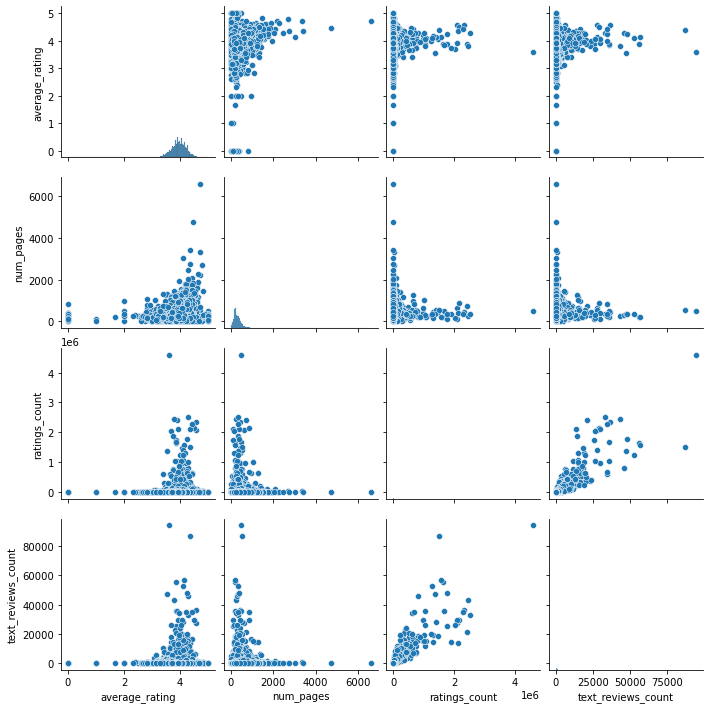

In [180]:
# Visualizing the pairwise relationships between multiple numerical variables (average rating, num pages, ratings count, text reviews count)
# creating the pairplot
plt.figure(figsize=(12, 6))
sns.pairplot(df.drop(['isbn13','bookid'], axis=1))

<Figure size 1800x576 with 0 Axes>

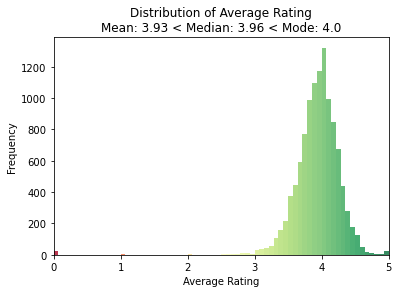

In [181]:
# Histogram to plot the distribution of average_ratings with color of the bars changing as the rate increases
# Define the number of bins and the gradient colors
n_bins = 70
colors = sns.color_palette("RdYlGn", n_bins) #color palette that ranges from red to green depending on the bins

# Create the histogram and loop over the bins to set the color of each one
plt.figure(figsize=(25,8))
fig, ax = plt.subplots()
counts, bins, _ = ax.hist(x='average_rating',data=df, bins=n_bins, alpha=0.8)
for i in range(0, n_bins):
    ax.patches[i].set_fc(colors[i])
plt.xlim(0, 5) # set the x-axis limits to 0 and 5
mean_value = df['average_rating'].mean()
median_value = df['average_rating'].median()
mode_value = df['average_rating'].mode()
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Average Rating\nMean: {:.2f} < Median: {:.2f} < Mode: 4.0'.format(mean_value, median_value))
plt.show()

# Histogram with n_bins bins, where the color of the first bin is the first color in the "RdYlGn" palette, and the color of each subsequent bin is a gradient between red (low values) and green (high values).
# mean < median < mode means that average_rating has a left skewed distribution
# We can see the majority of the observations lies between 3.8 and 5, there are not many values in the interval ]0,3[, 
# while there is a small peak at 0. 
# The small peak at 0 could be due to bad data i.e., where there was no information on the average_rating a 0 was assigned
# One of the reasons for small quantity of observations in the interval ]0,3[ could be due to the fact that there are some people who give higher ratings.
# Moreover we noticed that there are more observations when the rating is an integer (0,1,2,3,4,5) and this could be due to the fact that it's easier for people to give a rate without using decimal number that would be too specific.

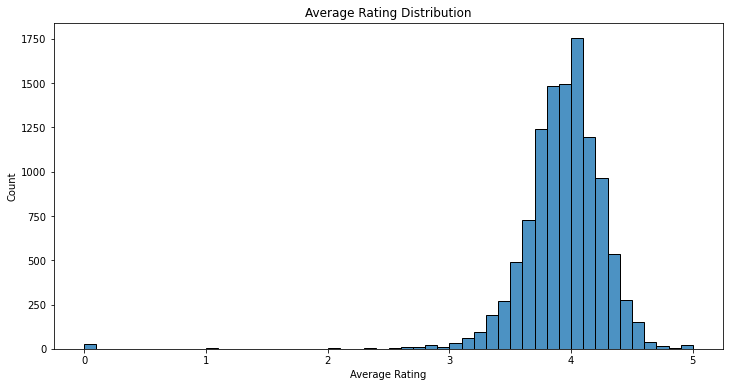

In [182]:
# Histogram to plot the distribution of average_ratings
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='average_rating', bins=50, palette='cool', alpha=0.8)
plt.title('Average Rating Distribution')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.show()

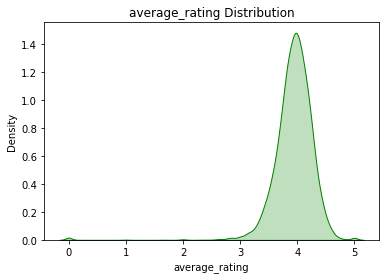

In [183]:
# Different way to show the distribution of average rating by average_rating
sns.kdeplot(x='average_rating', data=df, color="green", fill=True)
plt.title('average_rating Distribution')
plt.show()


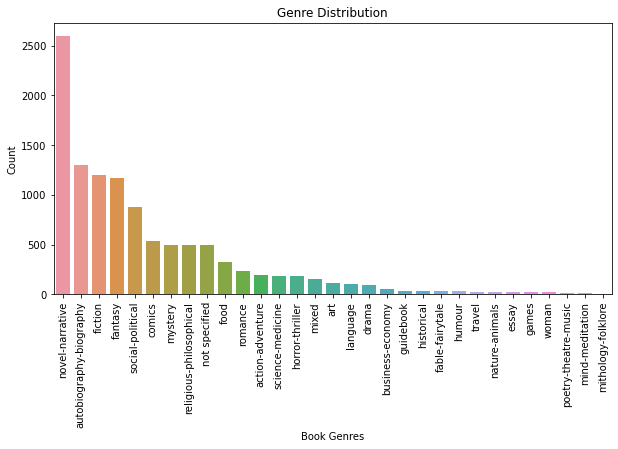

In [184]:
# Histogram to plot how the Genres are distributed in the dataset
plt.figure(figsize=(10,5))
sns.countplot(x='genre', data=df,order = df['genre'].value_counts().index)
plt.title('Genre Distribution')
plt.ylabel('Count')
plt.xlabel('Book Genres')
plt.xticks(rotation=90)
plt.show()

# The most frequent genre that appears in our dataset is novel-narrative. 
# This genre is wider and more generic than most of the other genres present in the dataset, this could be the reason why it is the one appearing more times.

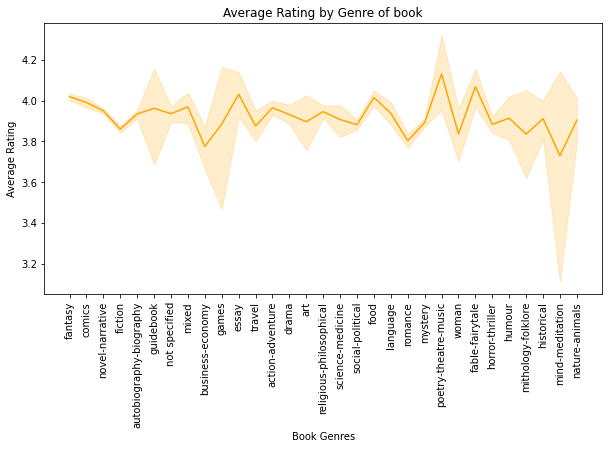

In [185]:
# Lineplot showing Average Rating by Genre
plt.figure(figsize=(10,5))
sns.lineplot(x='genre', y='average_rating', color="orange", data=df)
plt.title('Average Rating by Genre of book')
plt.ylabel('Average Rating')
plt.xlabel('Book Genres')
plt.xticks(rotation=90)
plt.show()

# This chart is useful to understand how the ratings are distributed according to the genre of the book
# Generally it seems that depending on the genre the ratings changes a little bit.
# For most of the genres the rating goes from 3.9 to 4.0
# The orange shadows gets bigger as the rating range increases, the genres with a wider range of ratings are 'guidebook', 'games', 'poetry-theatre-music', 'mythology-folklore' and 'mind-meditation'.
# 'mind-meditation' is the genre with highest range for rating, it goes from 3.1 to 4.1 and from the orange line we can see that the most frequent rating is more or less 3.8 i.e., a little bit lower than the ratings of other genres.
# The genre that seems to show higher ratings is 'poetry-theatre-music', it ranges from 3.9 to 4.3 with most frequent rating at 4.1
# One of the reasons for this could be that this genre includes classical literary works known worldwide.
# It must be taken into account that the range of the ratings depends of course on the n. of book that belong to a certain genre, for example the genre 'mythology-folklore' has just a few observations so it is normal that the range oscillates more.

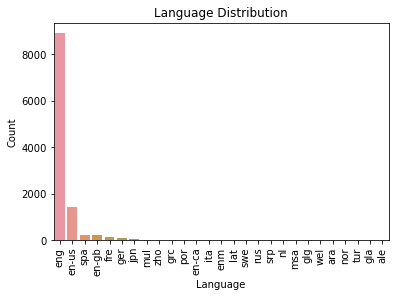

In [186]:
# segment average_rating by language
sns.countplot(x='language_code', data=df,order = df['language_code'].value_counts().index)
plt.title('Language Distribution')
plt.ylabel('Count')
plt.xlabel('Language')
plt.xticks(rotation=90)

plt.show()

# The most frequent language is English 
# The dataset makes a distinction between American English and British English but there is as well a general English that probably has been assigned in all those cases in which there were no details regarding the language used for writing the book.
# If we don't consider the distinction between different types of English language the most popular languages that appear in the dataset are:
# 1. English
# 2. Spanish
# 3. French

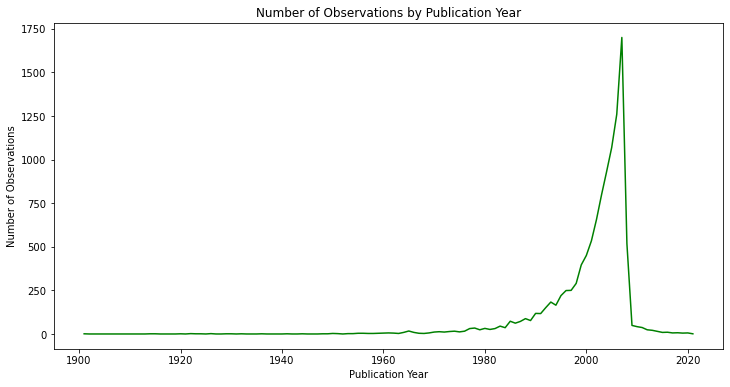

In [187]:
# Distribution of the observations in the dataset according to the year of publication of the book
# Set the publication date column as the index
dftemp = df.set_index('publication_date')

# Resample the data to get the count of observations by year
count_by_year = dftemp.resample('Y').size() 

# Plot the time series
plt.figure(figsize=(12,6))
plt.plot(count_by_year.index, count_by_year.values, color='green')
plt.title('Number of Observations by Publication Year')
plt.xlabel('Publication Year')
plt.ylabel('Number of Observations')
plt.show()

# From this plot we can see that the majority of the books have been published between 1990 and 2010.

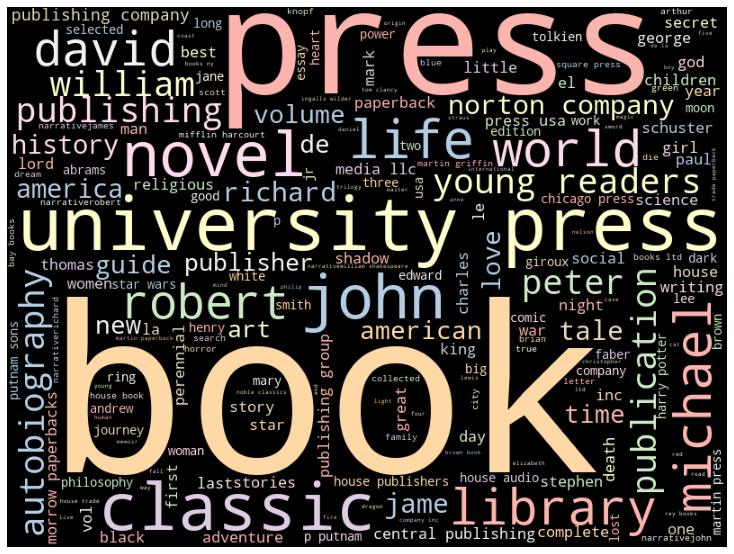

In [188]:
# The wordcloud shows the most common words that appear in the dataset
# The bigger the word the higher the frequency in the dataset
# We considered 4 variables: Title, Genre, Author, and Publisher
# We consider just these variables since they are categorical and could provide interesting insights

titles = df['title']
genres = df['genre']
authors = df['authors']
publishers = df['publisher']

text = ' '.join(titles+genres+authors+publishers)

stopwords = set(STOPWORDS)
stopwords.update(['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','q','r','s','t','u','v','w','x','y','x','z'])

wordcloud = WordCloud(width=800, height=600,background_color='black',
                     stopwords=stopwords, contour_width=2, contour_color = 'steelblue', 
                    colormap='Pastel1', random_state=42).generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.show()

# It is not a surprise that the biggest word is 'book'
# Most of the words are related to the literary field ('book', 'press', 'novel', 'publication', 'library',..)
# There are many personal names and this is due to the fact that we considered the author and publisher columns. 
# Although it won't be very meaningful for the prediction, the wordcloud shows that most of the personal names are masculine names ( i.e., in the dataset there are many more male authors than female authors).  

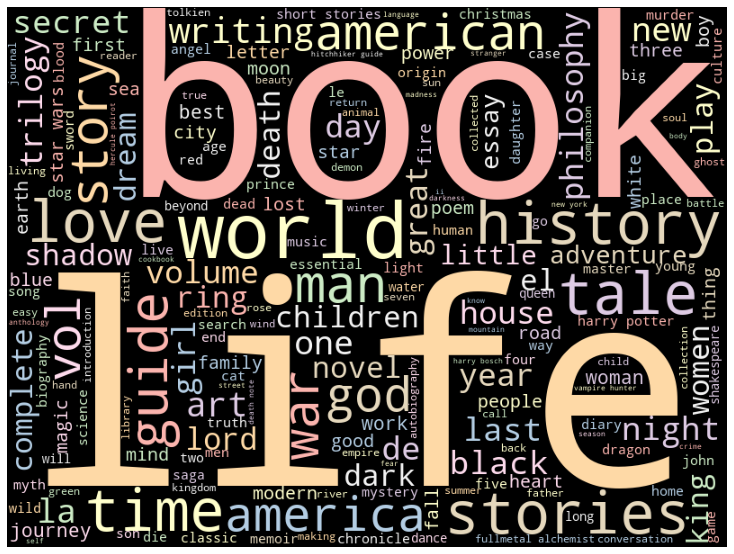

In [189]:
# In this wordcloud we take into account just the title of the book to see which are the most frequent terms appearing in the titles of the books of the dataset.

text2 = ' '.join(titles)

stopwords = set(STOPWORDS)
stopwords.update(['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','q','r','s','t','u','v','w','x','y','x','z'])

wordcloud = WordCloud(width=800, height=600,background_color='black',
                     stopwords=stopwords, contour_width=2, contour_color = 'steelblue', 
                    colormap='Pastel1', random_state=42).generate(text2)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.show()

# Now the biggest words are 'book' and 'life'
# This wordcloud is a better representation of our dataset since there are just the words appearing more frequently in the title

## Cleaning Operations

### Data Cleaning & Transformation Stage
- Too many authors -> Keep only the first author and store it in 'main_author'
- Common titles with different lines -> Keep the max value for rating, oldest publication and sum up the number of votes
- New column 'total_reviews'
- Num_pages with value==0 -> For 15 of them take the data of the identical book -> The rest, average by publisher -> the rest fill with the value found from Amazon/Wikipedia
- New column 'n_pages_vs_avg_aut' 
- New column 'n_pages_vs_avg_pub'
- New column 'rating_vs_avg_aut'
- New column 'rating_vs_avg_pub'
- Publication date -> Split by year -> Split by season -> transform in numerical
- Language -> add a column where en-us, en-gb, eng ca have been grouped into eng

###### Find the first author for each book
- Keep just one author for each book (the first one) and store it in a new column; add binary variable for multiple authors and one variable that counts the number of authors in 'authors'

In [190]:
# New binary column for multiple authors (presence of more than 1 author in main author)
# Create a new column called 'multiple_authors'
df['multiple_authors'] = df['authors'].str.contains('/')

# Convert the boolean values in 'multiple_authors' to 1s and 0s
df['multiple_authors'] = df['multiple_authors'].astype(int)

In [191]:
# New column that counts the number of authors
df['n_authors'] = df['authors'].str.count('/') + 1
# or df['authors_list'].str.len()

In [192]:
# New column 'main_author' with the first author of each book (delimited with'/')
# We transform the authors string into a list of authors
df['authors_list'] = df['authors'].str.split('/')
# We get the main author
df['main_author'] = df['authors_list'].str[0]

In [193]:
# We check if there are invalid authors
display(df['main_author'].describe())
print(df[df['main_author'].isna()])

count                   11123
unique                   4215
top       william shakespeare
freq                       88
Name: main_author, dtype: object

Empty DataFrame
Columns: [bookid, title, authors, average_rating, isbn, isbn13, language_code, num_pages, ratings_count, text_reviews_count, publication_date, publisher, title2, author2, genre, multiple_authors, n_authors, authors_list, main_author]
Index: []


In [194]:
display(df['n_authors'].describe())
df['n_authors'].value_counts()

count    11123.000000
mean         1.729479
std          1.820111
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         51.000000
Name: n_authors, dtype: float64

1     6561
2     3078
3     1005
4      222
5       65
6       54
7       21
10      12
8       11
15      11
9       10
11       9
21       8
18       8
13       8
16       6
17       6
12       5
19       4
20       3
24       3
23       2
14       1
26       1
27       1
28       1
51       1
35       1
33       1
38       1
22       1
25       1
32       1
Name: n_authors, dtype: int64

In [195]:
df.info() #check for no Missing Values and to see if the right columns have been dropped

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11123 entries, 0 to 11122
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   bookid              11123 non-null  int64         
 1   title               11123 non-null  object        
 2   authors             11123 non-null  object        
 3   average_rating      11123 non-null  float64       
 4   isbn                11123 non-null  object        
 5   isbn13              11123 non-null  int64         
 6   language_code       11123 non-null  object        
 7   num_pages           11123 non-null  int64         
 8   ratings_count       11123 non-null  int64         
 9   text_reviews_count  11123 non-null  int64         
 10  publication_date    11123 non-null  datetime64[ns]
 11  publisher           11123 non-null  object        
 12  title2              11123 non-null  object        
 13  author2             11123 non-null  object    

In [196]:
df[['authors','main_author','n_authors','multiple_authors']].sample(10) #checking if the new variables are doing what they are supposed to do

,authors,main_author,n_authors,multiple_authors
2562,maya angelou,maya angelou,1,0
9154,phyllis a. bird,phyllis a. bird,1,0
8817,lyman s. spitzer jr.,lyman s. spitzer jr.,1,0
4530,agatha christie,agatha christie,1,0
1698,j.r.r. tolkien/douglas a. anderson,j.r.r. tolkien,2,1
336,stephen w. frey,stephen w. frey,1,0
5862,max allan collins,max allan collins,1,0
4337,elizabeth davis/suzanne arms,elizabeth davis,2,1
2485,robert b. baer,robert b. baer,1,0
10508,thomas ryan,thomas ryan,1,0


###### Inspect duplicates in the dataset
- Keep 1 row for each unique title summing the info regarding rating, n. of pages, etc..

In [197]:
df['title'].duplicated().value_counts()

False    10311
True       812
Name: title, dtype: int64

In [198]:
df[['title', 'average_rating','ratings_count','text_reviews_count', 'num_pages']][df['title'].duplicated()]

,title,average_rating,ratings_count,text_reviews_count,num_pages
10,the hitchhiker's guide to the galaxy (hitchhik...,4.22,1266,253,6
24,the lord of the rings (the lord of the rings ...,4.50,1618,140,1216
37,the changeling,3.55,301,43,339
40,the known world,3.83,55,12,14
41,the known world,3.83,22,3,576
...,...,...,...,...,...
11076,artemis fowl (artemis fowl #1),3.84,55,14,6
11078,the subtle knife (his dark materials #2),4.13,677,77,326
11080,the subtle knife (his dark materials #2),4.13,39,8,8
11096,on the road,3.63,3271,342,307


In [199]:
df[['title', 'average_rating','ratings_count','text_reviews_count', 'num_pages']][df['title'].str.contains('harry potter and the prisoner of azkaban')]

,title,average_rating,ratings_count,text_reviews_count,num_pages
3,harry potter and the prisoner of azkaban (harr...,4.56,2339585,36325,435
1233,harry potter and the prisoner of azkaban (harr...,4.56,3141,140,480


In [200]:
# new updated column for ratings count that sums all ratings count when the title is the same
df['ratings_count_updt']=df.groupby(['title'])['ratings_count'].transform('sum')

In [201]:
# new updated column for text reviews count that sums all review count when the title is the same
df['text_reviews_count_updt']=df.groupby(['title'])['text_reviews_count'].transform('sum')

In [202]:
# useful for next stage regarding num pages, must be done before dropping duplicates
# new updated column for num_pages that store max value when the title is the same
# or mean instead of max?? sometimes looking at the Salem's lot book the max is 817, the min is 0, another 17
# the rest takes value from 405 to 594 and checking it online it should be smt between 439 and 670 depending on the version
df['max_pages']=df.groupby(['title'])['num_pages'].transform('max')

In [203]:
# check for title 'the known world'
df[['title', 'average_rating','ratings_count','text_reviews_count','ratings_count_updt', 'num_pages', 'max_pages']][df['title']=='the known world']

,title,average_rating,ratings_count,text_reviews_count,ratings_count_updt,num_pages,max_pages
39,the known world,3.83,29686,2626,30212,388,576
40,the known world,3.83,55,12,30212,14,576
41,the known world,3.83,22,3,30212,576,576
3193,the known world,3.83,449,83,30212,388,576


In [204]:
df[['title', 'average_rating','ratings_count','ratings_count_updt','text_reviews_count','publication_date','text_reviews_count_updt', 'num_pages', 'max_pages']][df['title'].str.contains('harry potter and the prisoner of azkaban')]

,title,average_rating,ratings_count,ratings_count_updt,text_reviews_count,publication_date,text_reviews_count_updt,num_pages,max_pages
3,harry potter and the prisoner of azkaban (harr...,4.56,2339585,2342726,36325,2004-05-01,36465,435,480
1233,harry potter and the prisoner of azkaban (harr...,4.56,3141,2342726,140,2008-07-01,36465,480,480


In [205]:
# check for title 'salem's lot
df[['title', 'average_rating','ratings_count','text_reviews_count','ratings_count_updt', 'num_pages', 'max_pages']][df['title']=="'salem's lot"]

,title,average_rating,ratings_count,text_reviews_count,ratings_count_updt,num_pages,max_pages
1572,'salem's lot,4.25,84123,571,85852,594,817
1573,'salem's lot,4.02,227,54,85852,17,817
1574,'salem's lot,4.02,1039,130,85852,405,817
1576,'salem's lot,4.02,178,35,85852,427,817
1577,'salem's lot,4.02,25,6,85852,586,817
5298,'salem's lot,4.02,56,5,85852,0,817
5300,'salem's lot,4.02,18,3,85852,817,817
9249,'salem's lot,4.02,186,22,85852,427,817


In [206]:
# check with the new columns
df[['title', 'average_rating','ratings_count','text_reviews_count','ratings_count_updt', 'text_reviews_count_updt', 'num_pages', 'max_pages']][df['title'].duplicated()]

,title,average_rating,ratings_count,text_reviews_count,ratings_count_updt,text_reviews_count_updt,num_pages,max_pages
10,the hitchhiker's guide to the galaxy (hitchhik...,4.22,1266,253,12107,1261,6,216
24,the lord of the rings (the lord of the rings ...,4.50,1618,140,4161,290,1216,1216
37,the changeling,3.55,301,43,1477,139,339,339
40,the known world,3.83,55,12,30212,2724,14,576
41,the known world,3.83,22,3,30212,2724,576,576
...,...,...,...,...,...,...,...,...
11076,artemis fowl (artemis fowl #1),3.84,55,14,528,41,6,286
11078,the subtle knife (his dark materials #2),4.13,677,77,5466,422,326,326
11080,the subtle knife (his dark materials #2),4.13,39,8,5466,422,8,326
11096,on the road,3.63,3271,342,9334,883,307,320


In [207]:
# now keep just the observation with max average_rating for each title

In [208]:
df = df.sort_values(['title', 'publication_date', 'average_rating'], ascending=[True, True, False]).drop_duplicates(['title'], keep='first')

In [209]:
# check for title 'the known world'
df[['title', 'average_rating','ratings_count','text_reviews_count','ratings_count_updt', 'num_pages', 'max_pages']][df['title']=='the known world']

,title,average_rating,ratings_count,text_reviews_count,ratings_count_updt,num_pages,max_pages
40,the known world,3.83,55,12,30212,14,576


In [210]:
df['title'].duplicated().value_counts()

False    10311
Name: title, dtype: int64

In [211]:
df[['title', 'average_rating','ratings_count','ratings_count_updt','text_reviews_count','publication_date','text_reviews_count_updt', 'num_pages', 'max_pages']][df['title'].str.contains('harry potter and the prisoner of azkaban')]

,title,average_rating,ratings_count,ratings_count_updt,text_reviews_count,publication_date,text_reviews_count_updt,num_pages,max_pages
3,harry potter and the prisoner of azkaban (harr...,4.56,2339585,2342726,36325,2004-05-01,36465,435,480


In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10311 entries, 1847 to 4261
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   bookid                   10311 non-null  int64         
 1   title                    10311 non-null  object        
 2   authors                  10311 non-null  object        
 3   average_rating           10311 non-null  float64       
 4   isbn                     10311 non-null  object        
 5   isbn13                   10311 non-null  int64         
 6   language_code            10311 non-null  object        
 7   num_pages                10311 non-null  int64         
 8   ratings_count            10311 non-null  int64         
 9   text_reviews_count       10311 non-null  int64         
 10  publication_date         10311 non-null  datetime64[ns]
 11  publisher                10311 non-null  object        
 12  title2                   10311

In [213]:
df.shape

(10311, 22)

In [214]:
# new variable 'total_reviews' that sums values from ratings_count and text_reviews
df['total_reviews'] = df['ratings_count_updt'] + df['text_reviews_count_updt']

In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10311 entries, 1847 to 4261
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   bookid                   10311 non-null  int64         
 1   title                    10311 non-null  object        
 2   authors                  10311 non-null  object        
 3   average_rating           10311 non-null  float64       
 4   isbn                     10311 non-null  object        
 5   isbn13                   10311 non-null  int64         
 6   language_code            10311 non-null  object        
 7   num_pages                10311 non-null  int64         
 8   ratings_count            10311 non-null  int64         
 9   text_reviews_count       10311 non-null  int64         
 10  publication_date         10311 non-null  datetime64[ns]
 11  publisher                10311 non-null  object        
 12  title2                   10311

In [216]:
df.shape

(10311, 23)

###### Deal with very low value of number of pages
- 6.1 Column max_pages created in previous step to fill the n.pages with the value found in another row with same book title (from 76 rows with num_page = 0 to 61)
- 6.2 Fill n.pages = 0 with average pages of the author (from 61 to 20)
- 6.3 Fill n.pages = 0 with average pages of the publisher (from 20 to 4)
- 6.4 Take the index of the rows with n.pages = 0 and assign the n. of pages found online (from 4 to 0)

###### Should we do the same operations for low num_page (<50) ?

In [217]:
# inspect how many rows have num pages=0
df.sort_values(by=['max_pages']).head(100)

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews
4524,16312,one two buckle my shoe (hercule poirot #23),agatha christie/hugh fraser,3.76,1572703857,9781572703858,eng,0,14388,411,2004-03-16,harpercollins publishers,"one, two, buckle my shoe",agatha christie,mystery,1,2,"[agatha christie, hugh fraser]",agatha christie,14388,411,0,14799
3730,13504,a clash of kings (a song of ice and fire #2),george r.r. martin/roy dotrice,4.41,073930870X,9780739308707,eng,0,113,12,2004-02-17,random house audio,"a clash of kings (martin, george r. r. song of...",george r. r. martin,fantasy,1,2,"[george r.r. martin, roy dotrice]",george r.r. martin,113,12,0,125
10922,44748,the mask of the enchantress,victoria holt,3.85,0449210847,9780449210840,eng,0,21,1,1981-10-12,ivy books,mask of the enchantress,victoria holt,mystery,0,1,[victoria holt],victoria holt,21,1,0,22
2676,9832,blind willow sleeping woman: 24 stories,haruki murakami/ellen archer/patrick lawlor,3.84,1400102952,9781400102952,eng,0,28,3,2006-10-15,tantor media,"blind willow, sleeping woman",haruki murakami,fiction,1,3,"[haruki murakami, ellen archer, patrick lawlor]",haruki murakami,28,3,0,31
4973,17983,the reverse of the medal (aubrey/maturin #11),patrick o'brian/simon vance,4.41,0786178183,9780786178186,en-gb,0,3598,93,2006-02-01,blackstone audiobooks,the reverse of the medal,patrick o'brian,novel-narrative,1,2,"[patrick o'brian, simon vance]",patrick o'brian,3598,93,0,3691
2440,8889,return to the planet of the apes #2: escape fr...,william arrow,3.00,0345251679,9780345251671,eng,0,10,2,1976-04-12,ballantine books,return to the planet of the apes #2: escape fr...,william arrow,not specified,0,1,[william arrow],william arrow,10,2,0,12
6254,23582,you're good enough you're smart enough & dog...,al franken,3.89,0553470949,9780553470949,en-us,0,18,0,1992-10-01,random house audio publishing group,"you're good enough, you're smart enough, and d...",al franken,art,0,1,[al franken],al franken,18,0,0,18
5839,21931,the day before midnight,stephen hunter/philip bosco,4.01,0553452118,9780553452112,eng,0,1,0,1989-12-01,random house audio,the day before midnight,stephen hunter,horror-thriller,1,2,"[stephen hunter, philip bosco]",stephen hunter,1,0,0,1
11077,45472,treasury of american tall tales: volume 1: dav...,david bromberg/jay ungar/molly mason/garrison ...,3.86,0739336509,9780739336502,eng,0,36,9,2006-08-22,listening library (audio),rabbit ears treasury of tall tales: volume one,rabbit ears,not specified,1,11,"[david bromberg, jay ungar, molly mason, garri...",david bromberg,36,9,0,45
5730,21365,from the corner of his eye,dean koontz/stephen lang,4.03,0553502697,9780553502695,en-us,0,29,3,2000-12-26,random house audio publishing group,from the corner of his eye,dean koontz,horror-thriller,1,2,"[dean koontz, stephen lang]",dean koontz,29,3,0,32


In [218]:
# subset with all obs where num pages = 0 using the new column max_pages created during point 5 before dropping duplicates
maxnopage = df[df['max_pages'] == 0]

In [219]:
maxnopage.shape # before adding column max_pages (76,15), then 61,16

(61, 23)

In [220]:
# compute average num_pages for each author and same for publisher

In [221]:
#see what's the average max number of pages for each author in main_author
avgnumpagexauth = df.groupby(["main_author"]).mean().max_pages 

In [222]:
avgnumpagexauth

main_author
a.b. yehoshua            416.000000
a.d.p. briggs            256.000000
a.e. cunningham          232.000000
a.j. jacobs              389.000000
a.m. homes               256.000000
                            ...    
zora neale hurston       426.600000
zoë heller               251.000000
åsne seierstad           291.333333
émile zola               459.444444
éric-emmanuel schmitt     85.000000
Name: max_pages, Length: 4188, dtype: float64

In [223]:
avgnumpagexauthDICT = df.groupby(["main_author"]).mean().num_pages.astype(int).to_dict()

In [224]:
avgnumpagexauthDICT.keys()

dict_keys(['a.b. yehoshua', 'a.d.p. briggs', 'a.e. cunningham', 'a.j. jacobs', 'a.m. homes', 'a.n. roquelaure', 'a.s. byatt', 'abbie hoffman', 'abdul rahman munif', 'abigail adams', 'abigail thomas', 'abolqasem ferdowsi', 'abraham lincoln', 'adam  sexton', 'adam drozdek', 'adam ginsberg', 'adam gopnik', 'adam hochschild', 'adam mansbach', 'adam rex', 'adam smith', 'adam swift', 'adam woog', 'adolfo bioy casares', 'adrian guelke', 'adrian mckinty', 'adèle geras', 'aeschylus', 'aesop', 'agatha christie', 'ai morinaga', 'aidan hartley', 'aimee bender', 'aimé césaire', 'akira yoshida', 'al franken', 'al gore', 'al ries', 'alain de botton', 'alan  lee', 'alan aldridge', 'alan brennert', 'alan cohen', 'alan dean foster', 'alan hausman', 'alan hollinghurst', 'alan lightman', 'alan macgillivray', 'alan moore', 'alan paton', 'alastair lamb', 'albert camus', 'albert demeo', 'albert einstein', 'albert ellis', 'albert jack', 'albert marrin', 'albert speer', 'alcoholics anonymous', 'alden t. vaugha

In [225]:
def numpage_guesser_auth(main_author): #guess average numpage based on author
    numpage = avgnumpagexauthDICT[main_author] 
    return numpage

In [226]:
numpage_guesser_auth('agatha christie')

256

In [227]:
#loop over every dictionary key 
# go to df locate the df with a certain author and all columns (store everything in a new df)
# get rows where max_numpage=0 and use the numpage guesser function to fill numpage= 0 
for main_author in avgnumpagexauthDICT.keys():
    temp_df = df.loc[(df.main_author==main_author),:]
    zero_values_index = temp_df.loc[(temp_df['max_pages'] == 0)].index
    df.loc[zero_values_index,"max_pages"] = numpage_guesser_auth(main_author)

In [228]:
df[df['max_pages'] == 0].shape #from 61 to 13

(13, 23)

In [229]:
#repeat for publisher

In [230]:
#see what's the average max number of pages for each publisher
avgnumpagexpubl = df.groupby(["publisher"]).mean().max_pages #seems that 

In [231]:
avgnumpagexpubl

publisher
10/18                            191.000000
1st book library                 600.000000
a & c black (childrens books)     62.000000
a harvest book/harcourt  inc.    216.000000
a k peters                       366.000000
                                    ...    
聯經出版事業股份有限公司                     537.500000
英文漢聲出版股份有限公司                      36.000000
角川書店 (kadokawa shoten)           171.500000
講談社                              186.833333
集英社                              199.500000
Name: max_pages, Length: 2186, dtype: float64

In [232]:
avgnumpagexpublDICT = df.groupby(["publisher"]).mean().num_pages.astype(int).to_dict()

In [233]:
avgnumpagexpublDICT.keys()

dict_keys(['10/18', '1st book library', 'a & c black (childrens books)', 'a harvest book/harcourt  inc.', 'a k peters', 'abacus', 'abacus books', 'abacus books (london)', 'abdo publishing company', 'abingdon press', 'abradale books/harry n. abrams', 'abraham guillen press', 'abrams', 'absolute press', 'abstract studio', 'academic press', 'academica press', 'academy chicago publishers', 'ace', 'ace book', 'ace books', 'ace hardcover', 'ace trade', 'acropolis books (ny)', 'actes sud', 'adamant media corporation', 'adams media', 'addison wesley', 'addison wesley publishing company', 'addison-wesley professional', 'adv manga', 'advantage world press', 'adventures unlimited press', 'aegypan', 'aerie', 'aha! process', 'ait planet lar', 'aivia press', 'ak press', 'akashic books/punk planet books', 'aladdin', 'aladdin paperbacks', 'alan rodgers books', 'albert whitman  company', 'albin michel', 'albury publishing', 'alcoholics anonymous world services inc', 'alderac entertainment group', 'alde

In [234]:
def numpage_guesser_publ(publisher): #guess average numpage based on author
    numpage = avgnumpagexpublDICT[publisher] 
    return numpage

In [235]:
numpage_guesser_publ('dc comics')

173

In [236]:
#loop over every dictionary key 
# go to df locate the df with a certain author and all columns (store everything in a new df)
# get rows where max_numpage=0 and use the numpage guesser function to fill numpage= 0 
for publisher in avgnumpagexpublDICT.keys():
    temp_df = df.loc[(df.publisher==publisher),:]
    zero_values_index = temp_df.loc[(temp_df['max_pages'] == 0)].index
    df.loc[zero_values_index,"max_pages"] = numpage_guesser_publ(publisher)

In [237]:
df[df['max_pages'] == 0].shape #from 13 to 3

(3, 23)

In [238]:
df[df['max_pages'] == 0]

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews
5841,21933,point of impact (bob lee swagger #1),stephen hunter/beau bridges,4.27,0739344242,9780739344248,eng,0,15,1,2007-01-09,rh audio,point of impact,stephen hunter,mystery,1,2,"[stephen hunter, beau bridges]",stephen hunter,15,1,0,16
8141,31270,the altman code (covert-one #4),gayle lynds/robert ludlum/don leslie,3.95,1593978863,9781593978860,eng,0,5,1,2005-09-30,audio renaissance,robert ludlum's the altman code,gayle lynds,horror-thriller,1,3,"[gayle lynds, robert ludlum, don leslie]",gayle lynds,5,1,0,6
9542,37902,turn of the cards,georgina grey,3.00,0449239691,9780449239698,eng,0,3,1,1979-05-12,fawcett coventry,turn of the cards,georgina grey,games,0,1,[georgina grey],georgina grey,3,1,0,4


In [239]:
# fill max_pages with the n. of pages found online
df.loc[(df["bookid"] == 21933), "max_pages"] = 530
df.loc[(df["bookid"] == 31270), "max_pages"] = 448
df.loc[(df["bookid"] == 37902), "max_pages"] = 221

In [240]:
df[df['max_pages'] == 0].shape #from 3 to 0

(0, 23)

In [241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10311 entries, 1847 to 4261
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   bookid                   10311 non-null  int64         
 1   title                    10311 non-null  object        
 2   authors                  10311 non-null  object        
 3   average_rating           10311 non-null  float64       
 4   isbn                     10311 non-null  object        
 5   isbn13                   10311 non-null  int64         
 6   language_code            10311 non-null  object        
 7   num_pages                10311 non-null  int64         
 8   ratings_count            10311 non-null  int64         
 9   text_reviews_count       10311 non-null  int64         
 10  publication_date         10311 non-null  datetime64[ns]
 11  publisher                10311 non-null  object        
 12  title2                   10311

In [242]:
# Number of authors who have written just one book (in our dataset)

num_books_by_author = df.groupby('main_author').size()
num_authors_with_one_book = sum(num_books_by_author == 1)
print(num_authors_with_one_book)

2780


In [243]:
# new column 'n_pages_vs_avg_auth': it is the number of pages of the book ('max_pages' variable) VS the average number of pages of the author of the book

# average number of pages per author
avgnumpagexauth = df.groupby('main_author')['max_pages'].mean()

# join the avgnumpagexauth Series with the df DataFrame
df = df.join(avgnumpagexauth.rename('avg_numpages_author'), on='main_author')

# compute the n_pages_vs_avg_auth column
df['n_pages_vs_avg_auth'] = df['max_pages'] / df['avg_numpages_author']

#rounf the 2 columns to keep just 2 decimals
df['n_pages_vs_avg_auth'] = df['n_pages_vs_avg_auth'].round(2)
df['avg_numpages_author'] = df['avg_numpages_author'].round(2)

In [244]:
df.sample()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth
4830,17328,open my eyes lord: a practical guide to angel...,gary oates/robert paul lamb/randy clark,4.31,0975262203,9780975262207,eng,148,126,7,2004-01-01,open heaven publications,"open my eyes, lord",gary oates,religious-philosophical,1,3,"[gary oates, robert paul lamb, randy clark]",gary oates,126,7,148,133,148.0,1.0


In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10311 entries, 1847 to 4261
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   bookid                   10311 non-null  int64         
 1   title                    10311 non-null  object        
 2   authors                  10311 non-null  object        
 3   average_rating           10311 non-null  float64       
 4   isbn                     10311 non-null  object        
 5   isbn13                   10311 non-null  int64         
 6   language_code            10311 non-null  object        
 7   num_pages                10311 non-null  int64         
 8   ratings_count            10311 non-null  int64         
 9   text_reviews_count       10311 non-null  int64         
 10  publication_date         10311 non-null  datetime64[ns]
 11  publisher                10311 non-null  object        
 12  title2                   10311

In [246]:
# new column 'n_pages_vs_avg_pub': it is the number of pages of the book ('max_pages' variable) VS the average number of pages of the publisher of the book

# average number of pages per publisher
avgnumpagexpub = df.groupby('publisher')['max_pages'].mean()

# join the avgnumpagexpub Series with the df DataFrame
df = df.join(avgnumpagexpub.rename('avg_numpages_publisher'), on='publisher')

# compute the n_pages_vs_avg_pub column
df['n_pages_vs_avg_pub'] = df['max_pages'] / df['avg_numpages_publisher']

#rounf the 2 columns to keep just 2 decimals
df['n_pages_vs_avg_pub'] = df['n_pages_vs_avg_pub'].round(2)
df['avg_numpages_publisher'] = df['avg_numpages_publisher'].round(2)

In [247]:
df.sample()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth,avg_numpages_publisher,n_pages_vs_avg_pub
3096,11389,arrowsmith,sinclair lewis/e.l. doctorow,3.82,0451526910,9780451526915,eng,428,5889,300,1953-06-01,harcourt brace jovanovich,arrowsmith (signet classics),sinclair lewis,novel-narrative,1,2,"[sinclair lewis, e.l. doctorow]",sinclair lewis,5889,300,428,6189,536.86,0.8,334.0,1.28


In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10311 entries, 1847 to 4261
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   bookid                   10311 non-null  int64         
 1   title                    10311 non-null  object        
 2   authors                  10311 non-null  object        
 3   average_rating           10311 non-null  float64       
 4   isbn                     10311 non-null  object        
 5   isbn13                   10311 non-null  int64         
 6   language_code            10311 non-null  object        
 7   num_pages                10311 non-null  int64         
 8   ratings_count            10311 non-null  int64         
 9   text_reviews_count       10311 non-null  int64         
 10  publication_date         10311 non-null  datetime64[ns]
 11  publisher                10311 non-null  object        
 12  title2                   10311

In [249]:
# new column 'rating_vs_avg_auth': it is the rating of the book ('average_rating' variable) VS the average rating according to the author of the book

# average rating per author
avgratingxauth = df.groupby('main_author')['average_rating'].mean()

# join the avgratingxauth Series with the df DataFrame
df = df.join(avgratingxauth.rename('avg_rating_author'), on='main_author')

# compute the rating_vs_avg_auth column
df['rating_vs_avg_auth'] = df['average_rating'] / df['avg_rating_author']

#rounf the 2 columns to keep just 2 decimals
df['rating_vs_avg_auth'] = df['rating_vs_avg_auth'].round(2)
df['avg_rating_author'] = df['avg_rating_author'].round(2)

In [250]:
df[df['rating_vs_avg_auth'].isna()]

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth,avg_numpages_publisher,n_pages_vs_avg_pub,avg_rating_author,rating_vs_avg_auth
4241,15186,american film guide,frank n. magill,0.0,0893562505,9780893562502,eng,5,0,0,1983-01-01,salem press inc,magill's american film guide,stephen l. hanson,art,0,1,[frank n. magill],frank n. magill,0,0,5,0,5.0,1.00,5.00,1.00,0.0,NaN
11027,45259,anthony thwaite: in conversation with peter da...,peter dale/ian hamilton/anthony thwaite,0.0,0953284123,9780953284122,eng,96,0,0,1999-12-09,between the lines productions,anthony thwaite in conversation with peter dal...,anthony thwaite,autobiography-biography,1,3,"[peter dale, ian hamilton, anthony t...",peter dale,0,0,96,0,96.0,1.00,96.00,1.00,0.0,NaN
7797,30080,beckett football card price guide,dan hitt/james beckett iii,0.0,1930692471,9781930692473,eng,830,0,0,2006-09-01,beckett media,beckett football card price guide 2006-2007 (b...,james beckett,games,1,2,"[dan hitt, james beckett iii]",dan hitt,0,0,830,0,830.0,1.00,830.00,1.00,0.0,NaN
3492,12712,brodie's notes on aldous huxley's brave new world,graham handley,0.0,0333581296,9780333581292,eng,71,0,0,1992-08-20,macmillan,alex huxley's brave new world,graham handley,novel-narrative,0,1,[graham handley],graham handley,0,0,71,0,71.0,1.00,289.25,0.25,0.0,NaN
9437,37467,classroom interactions as cross-cultural encou...,jasmine c.m. luk/angel m.y. lin,0.0,0805850848,9780805850840,eng,241,0,0,2006-08-05,routledge,classroom interactions as cross-cultural encou...,jasmine c.m. luk,autobiography-biography,1,2,"[jasmine c.m. luk, angel m.y. lin]",jasmine c.m. luk,0,0,241,0,241.0,1.00,288.91,0.83,0.0,NaN
10138,41044,day and night,better homes and gardens,0.0,0696018829,9780696018824,eng,32,0,1,1989-03-01,meredith corporation,day and night.,better homes and gardens,art,0,1,[better homes and gardens],better homes and gardens,0,1,32,1,32.0,1.00,32.00,1.00,0.0,NaN
2532,9337,how to meditate: an anthology of talks on medi...,frederick p. lenz,0.0,1932206108,9781932206104,eng,228,0,0,2004-01-01,frederick p. lenz foundation for american budd...,how to meditate,frederick lenz,mind-meditation,0,1,[frederick p. lenz],frederick p. lenz,0,0,228,0,266.0,0.86,266.00,0.86,0.0,NaN
2533,9338,insights: talks on the nature of existence,frederick p. lenz,0.0,1932206086,9781932206081,eng,304,0,0,2003-01-01,frederick p. lenz foundation for american budd...,insights,frederick lenz,autobiography-biography,0,1,[frederick p. lenz],frederick p. lenz,0,0,304,0,266.0,1.14,266.00,1.14,0.0,NaN
375,1302,juiced official strategy guide,doug walsh,0.0,0744005612,9780744005615,eng,112,0,0,2005-06-01,bradygames,juiced,doug walsh,guidebook,0,1,[doug walsh],doug walsh,0,0,112,0,112.0,1.00,195.10,0.57,0.0,NaN
6380,24010,"laguna i love you: the best of ""our town""",john weld/phil interlandi,0.0,1564741575,9781564741578,eng,285,0,0,1996-03-01,fithian press,"laguna, i love you","weld, john",autobiography-biography,1,2,"[john weld, phil interlandi]",john weld,0,0,285,0,285.0,1.00,285.00,1.00,0.0,NaN


In [251]:
df['rating_vs_avg_auth'].isna().sum()

19

In [252]:
df['rating_vs_avg_auth'].isna()

1847    False
4072    False
1574    False
3137    False
2343    False
        ...  
8316    False
8322    False
8319    False
4268    False
4261    False
Name: rating_vs_avg_auth, Length: 10311, dtype: bool

In [253]:
df.sample()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth,avg_numpages_publisher,n_pages_vs_avg_pub,avg_rating_author,rating_vs_avg_auth
9751,39004,die tagebücher einer nanny,emma mclaughlin/nicola kraus,3.42,3442545536,9783442545537,ger,344,38,2,2003-02-01,goldmann,die tagebücher einer nanny.,emma mclaughlin,science-medicine,1,2,"[emma mclaughlin, nicola kraus]",emma mclaughlin,38,2,344,40,347.0,0.99,375.88,0.92,3.08,1.11


In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10311 entries, 1847 to 4261
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   bookid                   10311 non-null  int64         
 1   title                    10311 non-null  object        
 2   authors                  10311 non-null  object        
 3   average_rating           10311 non-null  float64       
 4   isbn                     10311 non-null  object        
 5   isbn13                   10311 non-null  int64         
 6   language_code            10311 non-null  object        
 7   num_pages                10311 non-null  int64         
 8   ratings_count            10311 non-null  int64         
 9   text_reviews_count       10311 non-null  int64         
 10  publication_date         10311 non-null  datetime64[ns]
 11  publisher                10311 non-null  object        
 12  title2                   10311

In [255]:
df[df['rating_vs_avg_auth'].isna()] # all missing values are in rows where average_rating==0|5 and both ratings_count & text_reviews_count==0
# we ignore missing value because we will drop later the NA in those rows with average_rating==0|5 and both ratings_count & text_reviews_count==0

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth,avg_numpages_publisher,n_pages_vs_avg_pub,avg_rating_author,rating_vs_avg_auth
4241,15186,american film guide,frank n. magill,0.0,0893562505,9780893562502,eng,5,0,0,1983-01-01,salem press inc,magill's american film guide,stephen l. hanson,art,0,1,[frank n. magill],frank n. magill,0,0,5,0,5.0,1.00,5.00,1.00,0.0,NaN
11027,45259,anthony thwaite: in conversation with peter da...,peter dale/ian hamilton/anthony thwaite,0.0,0953284123,9780953284122,eng,96,0,0,1999-12-09,between the lines productions,anthony thwaite in conversation with peter dal...,anthony thwaite,autobiography-biography,1,3,"[peter dale, ian hamilton, anthony t...",peter dale,0,0,96,0,96.0,1.00,96.00,1.00,0.0,NaN
7797,30080,beckett football card price guide,dan hitt/james beckett iii,0.0,1930692471,9781930692473,eng,830,0,0,2006-09-01,beckett media,beckett football card price guide 2006-2007 (b...,james beckett,games,1,2,"[dan hitt, james beckett iii]",dan hitt,0,0,830,0,830.0,1.00,830.00,1.00,0.0,NaN
3492,12712,brodie's notes on aldous huxley's brave new world,graham handley,0.0,0333581296,9780333581292,eng,71,0,0,1992-08-20,macmillan,alex huxley's brave new world,graham handley,novel-narrative,0,1,[graham handley],graham handley,0,0,71,0,71.0,1.00,289.25,0.25,0.0,NaN
9437,37467,classroom interactions as cross-cultural encou...,jasmine c.m. luk/angel m.y. lin,0.0,0805850848,9780805850840,eng,241,0,0,2006-08-05,routledge,classroom interactions as cross-cultural encou...,jasmine c.m. luk,autobiography-biography,1,2,"[jasmine c.m. luk, angel m.y. lin]",jasmine c.m. luk,0,0,241,0,241.0,1.00,288.91,0.83,0.0,NaN
10138,41044,day and night,better homes and gardens,0.0,0696018829,9780696018824,eng,32,0,1,1989-03-01,meredith corporation,day and night.,better homes and gardens,art,0,1,[better homes and gardens],better homes and gardens,0,1,32,1,32.0,1.00,32.00,1.00,0.0,NaN
2532,9337,how to meditate: an anthology of talks on medi...,frederick p. lenz,0.0,1932206108,9781932206104,eng,228,0,0,2004-01-01,frederick p. lenz foundation for american budd...,how to meditate,frederick lenz,mind-meditation,0,1,[frederick p. lenz],frederick p. lenz,0,0,228,0,266.0,0.86,266.00,0.86,0.0,NaN
2533,9338,insights: talks on the nature of existence,frederick p. lenz,0.0,1932206086,9781932206081,eng,304,0,0,2003-01-01,frederick p. lenz foundation for american budd...,insights,frederick lenz,autobiography-biography,0,1,[frederick p. lenz],frederick p. lenz,0,0,304,0,266.0,1.14,266.00,1.14,0.0,NaN
375,1302,juiced official strategy guide,doug walsh,0.0,0744005612,9780744005615,eng,112,0,0,2005-06-01,bradygames,juiced,doug walsh,guidebook,0,1,[doug walsh],doug walsh,0,0,112,0,112.0,1.00,195.10,0.57,0.0,NaN
6380,24010,"laguna i love you: the best of ""our town""",john weld/phil interlandi,0.0,1564741575,9781564741578,eng,285,0,0,1996-03-01,fithian press,"laguna, i love you","weld, john",autobiography-biography,1,2,"[john weld, phil interlandi]",john weld,0,0,285,0,285.0,1.00,285.00,1.00,0.0,NaN


In [256]:
# new column 'rating_vs_avg_pub': it is the rating of the book ('average_rating' variable) VS the average rating according to the publisher of the book

# average rating of pages per publisher
avgratingxpub = df.groupby('publisher')['average_rating'].mean()

# join the avgratingxpub Series with the df DataFrame
df = df.join(avgratingxpub.rename('avg_rating_publisher'), on='publisher')

# compute the rating_vs_avg_pub column
df['rating_vs_avg_pub'] = df['average_rating'] / df['avg_rating_publisher']

#rounf the 2 columns to keep just 2 decimals
df['rating_vs_avg_pub'] = df['rating_vs_avg_pub'].round(2)
df['avg_rating_publisher'] = df['avg_rating_publisher'].round(2)

In [257]:
df.sample()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth,avg_numpages_publisher,n_pages_vs_avg_pub,avg_rating_author,rating_vs_avg_auth,avg_rating_publisher,rating_vs_avg_pub
3091,11376,main street,sinclair lewis,3.77,0375753141,9780375753145,eng,454,21451,778,2000-11-01,modern library,main street,sinclair lewis,autobiography-biography,0,1,[sinclair lewis],sinclair lewis,21737,815,560,22552,536.86,1.04,495.77,1.13,3.84,0.98,3.99,0.95


In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10311 entries, 1847 to 4261
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   bookid                   10311 non-null  int64         
 1   title                    10311 non-null  object        
 2   authors                  10311 non-null  object        
 3   average_rating           10311 non-null  float64       
 4   isbn                     10311 non-null  object        
 5   isbn13                   10311 non-null  int64         
 6   language_code            10311 non-null  object        
 7   num_pages                10311 non-null  int64         
 8   ratings_count            10311 non-null  int64         
 9   text_reviews_count       10311 non-null  int64         
 10  publication_date         10311 non-null  datetime64[ns]
 11  publisher                10311 non-null  object        
 12  title2                   10311

In [259]:
df[df['rating_vs_avg_pub'].isna()] # all missing values are in rows where average_rating==0|5 and both ratings_count & text_reviews_count==0
# we ignore missing value because we will drop later the NA in those rows with average_rating==0|5 and both ratings_count & text_reviews_count==0

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth,avg_numpages_publisher,n_pages_vs_avg_pub,avg_rating_author,rating_vs_avg_auth,avg_rating_publisher,rating_vs_avg_pub
4241,15186,american film guide,frank n. magill,0.0,0893562505,9780893562502,eng,5,0,0,1983-01-01,salem press inc,magill's american film guide,stephen l. hanson,art,0,1,[frank n. magill],frank n. magill,0,0,5,0,5.00,1.00,5.0,1.00,0.00,NaN,0.0,NaN
6558,24749,american writers supplement viii,jay parini/august wilson,0.0,0684806371,9780684806372,eng,400,0,0,2001-05-01,gale cengage,american writers: a collection of literary bio...,jay parini/august wilson,not specified,1,2,"[jay parini, august wilson]",jay parini,0,0,400,0,480.67,0.83,400.0,1.00,2.69,0.0,0.0,NaN
11027,45259,anthony thwaite: in conversation with peter da...,peter dale/ian hamilton/anthony thwaite,0.0,0953284123,9780953284122,eng,96,0,0,1999-12-09,between the lines productions,anthony thwaite in conversation with peter dal...,anthony thwaite,autobiography-biography,1,3,"[peter dale, ian hamilton, anthony t...",peter dale,0,0,96,0,96.00,1.00,96.0,1.00,0.00,NaN,0.0,NaN
7797,30080,beckett football card price guide,dan hitt/james beckett iii,0.0,1930692471,9781930692473,eng,830,0,0,2006-09-01,beckett media,beckett football card price guide 2006-2007 (b...,james beckett,games,1,2,"[dan hitt, james beckett iii]",dan hitt,0,0,830,0,830.00,1.00,830.0,1.00,0.00,NaN,0.0,NaN
5323,19257,canopy: a work for voice and light in harvard ...,david ward/parveen adams/seamus heaney/ivan ...,0.0,0916724948,9780916724948,eng,63,0,0,1997-12-31,arts publications,canopy,"ward, david",social-political,1,4,"[david ward, parveen adams, seamus heaney, i...",david ward,0,0,63,0,95.50,0.66,63.0,1.00,2.18,0.0,0.0,NaN
10138,41044,day and night,better homes and gardens,0.0,0696018829,9780696018824,eng,32,0,1,1989-03-01,meredith corporation,day and night.,better homes and gardens,art,0,1,[better homes and gardens],better homes and gardens,0,1,32,1,32.00,1.00,32.0,1.00,0.00,NaN,0.0,NaN
2532,9337,how to meditate: an anthology of talks on medi...,frederick p. lenz,0.0,1932206108,9781932206104,eng,228,0,0,2004-01-01,frederick p. lenz foundation for american budd...,how to meditate,frederick lenz,mind-meditation,0,1,[frederick p. lenz],frederick p. lenz,0,0,228,0,266.00,0.86,266.0,0.86,0.00,NaN,0.0,NaN
6877,25903,i'll be home before midnight and i won't get p...,anthony e. wolf,0.0,0394755669,9780394755663,eng,288,0,0,1988-05-12,knopf doubleday publishing group,i'll be home before midnight and i won't get p...,anthony e. wolf,social-political,0,1,[anthony e. wolf],anthony e. wolf,0,0,288,0,264.00,1.09,288.0,1.00,1.98,0.0,0.0,NaN
2533,9338,insights: talks on the nature of existence,frederick p. lenz,0.0,1932206086,9781932206081,eng,304,0,0,2003-01-01,frederick p. lenz foundation for american budd...,insights,frederick lenz,autobiography-biography,0,1,[frederick p. lenz],frederick p. lenz,0,0,304,0,266.00,1.14,266.0,1.14,0.00,NaN,0.0,NaN
6380,24010,"laguna i love you: the best of ""our town""",john weld/phil interlandi,0.0,1564741575,9781564741578,eng,285,0,0,1996-03-01,fithian press,"laguna, i love you","weld, john",autobiography-biography,1,2,"[john weld, phil interlandi]",john weld,0,0,285,0,285.00,1.00,285.0,1.00,0.00,NaN,0.0,NaN


In [260]:
# new col 'rating_vs_avg' average_rating VS average of 'average_rating'
avg_average_rating = df['average_rating'].mean()
avg_average_rating


# rating of the book wrt average
df['rating_vs_avg'] = df['average_rating'] / avg_average_rating

In [261]:
df.sample()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth,avg_numpages_publisher,n_pages_vs_avg_pub,avg_rating_author,rating_vs_avg_auth,avg_rating_publisher,rating_vs_avg_pub,rating_vs_avg
9965,40156,the thief (the queen's thief #1),megan whalen turner,3.88,0613060326,9780613060325,eng,220,97,17,1998-01-28,san val,the thief,megan turner,not specified,0,1,[megan whalen turner],megan whalen turner,97,17,220,114,282.25,0.78,220.0,1.0,4.06,0.96,3.88,1.0,0.98653


In [262]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10311 entries, 1847 to 4261
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   bookid                   10311 non-null  int64         
 1   title                    10311 non-null  object        
 2   authors                  10311 non-null  object        
 3   average_rating           10311 non-null  float64       
 4   isbn                     10311 non-null  object        
 5   isbn13                   10311 non-null  int64         
 6   language_code            10311 non-null  object        
 7   num_pages                10311 non-null  int64         
 8   ratings_count            10311 non-null  int64         
 9   text_reviews_count       10311 non-null  int64         
 10  publication_date         10311 non-null  datetime64[ns]
 11  publisher                10311 non-null  object        
 12  title2                   10311

In [263]:
# new col 'rating_vs_mode' average_rating VS mode of 'average_rating'
mode_average_rating = df['average_rating'].mode()[0]
mode_average_rating

# rating of the book wrt mode
df['rating_vs_mode'] = df['average_rating'] / mode_average_rating

In [264]:
df.sample()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth,avg_numpages_publisher,n_pages_vs_avg_pub,avg_rating_author,rating_vs_avg_auth,avg_rating_publisher,rating_vs_avg_pub,rating_vs_avg,rating_vs_mode
4761,17125,one day in the life of ivan denisovich,aleksandr solzhenitsyn/h.t. willetts,3.95,0374529523,9780374529529,eng,182,73577,2521,2005-03-16,farrar straus and giroux,one day in the life of ivan denisovich,александр исаевич солженицын,novel-narrative,1,2,"[aleksandr solzhenitsyn, h.t. willetts]",aleksandr solzhenitsyn,73577,2521,182,76098,359.0,0.51,313.92,0.58,4.08,0.97,4.08,0.97,1.004328,0.9875


In [265]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10311 entries, 1847 to 4261
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   bookid                   10311 non-null  int64         
 1   title                    10311 non-null  object        
 2   authors                  10311 non-null  object        
 3   average_rating           10311 non-null  float64       
 4   isbn                     10311 non-null  object        
 5   isbn13                   10311 non-null  int64         
 6   language_code            10311 non-null  object        
 7   num_pages                10311 non-null  int64         
 8   ratings_count            10311 non-null  int64         
 9   text_reviews_count       10311 non-null  int64         
 10  publication_date         10311 non-null  datetime64[ns]
 11  publisher                10311 non-null  object        
 12  title2                   10311

In [266]:
df.shape

(10311, 33)

###### New columns for publication date
- Split publication date into year, month and season

In [267]:
df.dtypes

bookid                              int64
title                              object
authors                            object
average_rating                    float64
isbn                               object
isbn13                              int64
language_code                      object
num_pages                           int64
ratings_count                       int64
text_reviews_count                  int64
publication_date           datetime64[ns]
publisher                          object
title2                             object
author2                            object
genre                              object
multiple_authors                    int32
n_authors                           int64
authors_list                       object
main_author                        object
ratings_count_updt                  int64
text_reviews_count_updt             int64
max_pages                           int64
total_reviews                       int64
avg_numpages_author               

In [268]:
df["pub_month"] = df['publication_date'].map(lambda x: x.month)
df["pub_year"] = df['publication_date'].map(lambda x: x.year)

In [269]:
df.head()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth,avg_numpages_publisher,n_pages_vs_avg_pub,avg_rating_author,rating_vs_avg_auth,avg_rating_publisher,rating_vs_avg_pub,rating_vs_avg,rating_vs_mode,pub_month,pub_year
1847,6549,said the shotgun to the head.,saul williams,4.22,0743470796,9780743470797,en-us,192,2762,214,2003-09-01,mtv books,said the shotgun to the head,saul williams,food,0,1,[saul williams],saul williams,2762,214,192,2976,192.00,1.00,202.67,0.95,4.22,1.00,4.05,1.04,1.072978,1.0550,9,2003
4072,14490,$30 film school: how to write direct produce...,michael w. dean,3.49,1592000673,9781592000678,eng,528,30,4,2003-05-13,cengage learning,$30 film school,michael w. dean,art,0,1,[michael w. dean],michael w. dean,30,4,528,34,528.00,1.00,526.17,1.00,3.49,1.00,3.61,0.97,0.887368,0.8725,5,2003
1574,5415,'salem's lot,stephen king,4.02,0965772411,9780965772419,eng,405,1039,130,1975-10-17,doubleday,salem's lot,stephen king,autobiography-biography,0,1,[stephen king],stephen king,85852,826,817,86678,458.08,1.78,399.09,2.05,3.98,1.01,3.92,1.03,1.022126,1.0050,10,1975
3137,11525,1 000 places to see before you die,patricia schultz,3.85,0761104844,9780761104841,eng,992,36303,439,2003-05-22,workman publishing company,"1,000 places to see before you die",patricia schultz,guidebook,0,1,[patricia schultz],patricia schultz,36303,439,992,36742,992.00,1.00,534.14,1.86,3.85,1.00,4.07,0.95,0.978902,0.9625,5,2003
2343,8542,10 lb penalty,dick francis,3.90,042519745X,9780425197455,eng,320,3490,177,2004-08-03,g.p. putnam's sons,10 lb penalty,dick francis,mystery,0,1,[dick francis],dick francis,3490,177,320,3667,321.62,0.99,387.48,0.83,3.96,0.99,3.93,0.99,0.991615,0.9750,8,2004


In [270]:
# pub_month_text is the categorical equivalent of 'pub_month', useful in the analysis phase
def set_value(row_number, assigned_value):
    return assigned_value[row_number]
 
# Create the name of the month to each month in numerical format
month_dictionary ={12 : 'december', 1 : 'january', 2 : 'february', 
                    3 : 'march', 4 : 'april', 5 : 'may',
                    6 : 'june', 7 : 'july', 8 : 'august', 
                    9 : 'september', 10 : 'october', 11 : 'november'}
 
# Add a new column named 'pub_month_text'
df['pub_month_text'] = df['pub_month'].apply(set_value, args =(month_dictionary, ))
 
df.head()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth,avg_numpages_publisher,n_pages_vs_avg_pub,avg_rating_author,rating_vs_avg_auth,avg_rating_publisher,rating_vs_avg_pub,rating_vs_avg,rating_vs_mode,pub_month,pub_year,pub_month_text
1847,6549,said the shotgun to the head.,saul williams,4.22,0743470796,9780743470797,en-us,192,2762,214,2003-09-01,mtv books,said the shotgun to the head,saul williams,food,0,1,[saul williams],saul williams,2762,214,192,2976,192.00,1.00,202.67,0.95,4.22,1.00,4.05,1.04,1.072978,1.0550,9,2003,september
4072,14490,$30 film school: how to write direct produce...,michael w. dean,3.49,1592000673,9781592000678,eng,528,30,4,2003-05-13,cengage learning,$30 film school,michael w. dean,art,0,1,[michael w. dean],michael w. dean,30,4,528,34,528.00,1.00,526.17,1.00,3.49,1.00,3.61,0.97,0.887368,0.8725,5,2003,may
1574,5415,'salem's lot,stephen king,4.02,0965772411,9780965772419,eng,405,1039,130,1975-10-17,doubleday,salem's lot,stephen king,autobiography-biography,0,1,[stephen king],stephen king,85852,826,817,86678,458.08,1.78,399.09,2.05,3.98,1.01,3.92,1.03,1.022126,1.0050,10,1975,october
3137,11525,1 000 places to see before you die,patricia schultz,3.85,0761104844,9780761104841,eng,992,36303,439,2003-05-22,workman publishing company,"1,000 places to see before you die",patricia schultz,guidebook,0,1,[patricia schultz],patricia schultz,36303,439,992,36742,992.00,1.00,534.14,1.86,3.85,1.00,4.07,0.95,0.978902,0.9625,5,2003,may
2343,8542,10 lb penalty,dick francis,3.90,042519745X,9780425197455,eng,320,3490,177,2004-08-03,g.p. putnam's sons,10 lb penalty,dick francis,mystery,0,1,[dick francis],dick francis,3490,177,320,3667,321.62,0.99,387.48,0.83,3.96,0.99,3.93,0.99,0.991615,0.9750,8,2004,august


In [271]:
# The seasons will be defined as:
# Winter (December, January, February) -> 1 in numerical
# Spring (March, April, May) -> 2 in numerical
# Summer (June, July, August) -> 3 in numerical
# Autumn (September, October, November) -> 4 in numerical

In [272]:
# Defining a function to map the values
def set_value(row_number, assigned_value):
    return assigned_value[row_number]
 
# Create the dictionary that assigns a number to each season
season_dictionary ={12 : 'winter', 1 : 'winter', 2 : 'winter', 
                    3 : 'spring', 4 : 'spring', 5 : 'spring',
                    6 : 'summer', 7 : 'summer', 8 : 'summer', 
                    9 : 'autumn', 10 : 'autumn', 11 : 'autumn'}
 
# Add a new column named 'season'
df['season'] = df['pub_month'].apply(set_value, args =(season_dictionary, ))
 
df.head()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth,avg_numpages_publisher,n_pages_vs_avg_pub,avg_rating_author,rating_vs_avg_auth,avg_rating_publisher,rating_vs_avg_pub,rating_vs_avg,rating_vs_mode,pub_month,pub_year,pub_month_text,season
1847,6549,said the shotgun to the head.,saul williams,4.22,0743470796,9780743470797,en-us,192,2762,214,2003-09-01,mtv books,said the shotgun to the head,saul williams,food,0,1,[saul williams],saul williams,2762,214,192,2976,192.00,1.00,202.67,0.95,4.22,1.00,4.05,1.04,1.072978,1.0550,9,2003,september,autumn
4072,14490,$30 film school: how to write direct produce...,michael w. dean,3.49,1592000673,9781592000678,eng,528,30,4,2003-05-13,cengage learning,$30 film school,michael w. dean,art,0,1,[michael w. dean],michael w. dean,30,4,528,34,528.00,1.00,526.17,1.00,3.49,1.00,3.61,0.97,0.887368,0.8725,5,2003,may,spring
1574,5415,'salem's lot,stephen king,4.02,0965772411,9780965772419,eng,405,1039,130,1975-10-17,doubleday,salem's lot,stephen king,autobiography-biography,0,1,[stephen king],stephen king,85852,826,817,86678,458.08,1.78,399.09,2.05,3.98,1.01,3.92,1.03,1.022126,1.0050,10,1975,october,autumn
3137,11525,1 000 places to see before you die,patricia schultz,3.85,0761104844,9780761104841,eng,992,36303,439,2003-05-22,workman publishing company,"1,000 places to see before you die",patricia schultz,guidebook,0,1,[patricia schultz],patricia schultz,36303,439,992,36742,992.00,1.00,534.14,1.86,3.85,1.00,4.07,0.95,0.978902,0.9625,5,2003,may,spring
2343,8542,10 lb penalty,dick francis,3.90,042519745X,9780425197455,eng,320,3490,177,2004-08-03,g.p. putnam's sons,10 lb penalty,dick francis,mystery,0,1,[dick francis],dick francis,3490,177,320,3667,321.62,0.99,387.48,0.83,3.96,0.99,3.93,0.99,0.991615,0.9750,8,2004,august,summer


In [273]:
# Define a function to map the values
def set_value(row_number, assigned_value):
    return assigned_value[row_number]
 
# Create the dictionary that assigns a number to each season
seasonnum_dictionary ={'winter' : 1, 'spring' : 2, 'summer' : 3, 'autumn' : 4}
 
# Add a new column named 'season_num'
df['season_num'] = df['season'].apply(set_value, args =(seasonnum_dictionary, ))
 
df.head()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth,avg_numpages_publisher,n_pages_vs_avg_pub,avg_rating_author,rating_vs_avg_auth,avg_rating_publisher,rating_vs_avg_pub,rating_vs_avg,rating_vs_mode,pub_month,pub_year,pub_month_text,season,season_num
1847,6549,said the shotgun to the head.,saul williams,4.22,0743470796,9780743470797,en-us,192,2762,214,2003-09-01,mtv books,said the shotgun to the head,saul williams,food,0,1,[saul williams],saul williams,2762,214,192,2976,192.00,1.00,202.67,0.95,4.22,1.00,4.05,1.04,1.072978,1.0550,9,2003,september,autumn,4
4072,14490,$30 film school: how to write direct produce...,michael w. dean,3.49,1592000673,9781592000678,eng,528,30,4,2003-05-13,cengage learning,$30 film school,michael w. dean,art,0,1,[michael w. dean],michael w. dean,30,4,528,34,528.00,1.00,526.17,1.00,3.49,1.00,3.61,0.97,0.887368,0.8725,5,2003,may,spring,2
1574,5415,'salem's lot,stephen king,4.02,0965772411,9780965772419,eng,405,1039,130,1975-10-17,doubleday,salem's lot,stephen king,autobiography-biography,0,1,[stephen king],stephen king,85852,826,817,86678,458.08,1.78,399.09,2.05,3.98,1.01,3.92,1.03,1.022126,1.0050,10,1975,october,autumn,4
3137,11525,1 000 places to see before you die,patricia schultz,3.85,0761104844,9780761104841,eng,992,36303,439,2003-05-22,workman publishing company,"1,000 places to see before you die",patricia schultz,guidebook,0,1,[patricia schultz],patricia schultz,36303,439,992,36742,992.00,1.00,534.14,1.86,3.85,1.00,4.07,0.95,0.978902,0.9625,5,2003,may,spring,2
2343,8542,10 lb penalty,dick francis,3.90,042519745X,9780425197455,eng,320,3490,177,2004-08-03,g.p. putnam's sons,10 lb penalty,dick francis,mystery,0,1,[dick francis],dick francis,3490,177,320,3667,321.62,0.99,387.48,0.83,3.96,0.99,3.93,0.99,0.991615,0.9750,8,2004,august,summer,3


In [274]:
# new column century
df['century'] = df['pub_year']//100

In [275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10311 entries, 1847 to 4261
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   bookid                   10311 non-null  int64         
 1   title                    10311 non-null  object        
 2   authors                  10311 non-null  object        
 3   average_rating           10311 non-null  float64       
 4   isbn                     10311 non-null  object        
 5   isbn13                   10311 non-null  int64         
 6   language_code            10311 non-null  object        
 7   num_pages                10311 non-null  int64         
 8   ratings_count            10311 non-null  int64         
 9   text_reviews_count       10311 non-null  int64         
 10  publication_date         10311 non-null  datetime64[ns]
 11  publisher                10311 non-null  object        
 12  title2                   10311

In [276]:
df.shape

(10311, 39)

###### Rename languages
- Find language == en-us, en-gb, en-ca, and rename them eng in a new column 'language_code_ENgroup'

In [277]:
df['language_code'].value_counts().shape

(26,)

In [278]:
df['language_code'].value_counts()

eng      8241
en-us    1316
en-gb     197
spa       195
fre       136
ger        95
jpn        46
mul        19
zho        14
grc        11
por        10
en-ca       7
ita         5
lat         3
enm         3
rus         2
swe         2
ara         1
nl          1
srp         1
msa         1
glg         1
nor         1
tur         1
wel         1
gla         1
Name: language_code, dtype: int64

In [279]:
df['language_code_ENgroup'] = df['language_code'] # grouping the eng languages could have a bad influence on the accuracy of the prediction so we decided to keep both variables in this stage

In [280]:
bool_serie = (df['language_code_ENgroup'].str.contains(r'eng'))|(df['language_code_ENgroup'].str.contains(r'en-us'))|(df['language_code_ENgroup'].str.contains(r'en-gb'))|(df['language_code_ENgroup'].str.contains(r'en-ca'))

df_Other=df.loc[bool_serie,:]
df_Other['language_code_ENgroup'].value_counts().shape

(4,)

In [281]:
df.loc[bool_serie,'language_code_ENgroup' ] = 'eng'

In [282]:
df['language_code'].value_counts()

eng      8241
en-us    1316
en-gb     197
spa       195
fre       136
ger        95
jpn        46
mul        19
zho        14
grc        11
por        10
en-ca       7
ita         5
lat         3
enm         3
rus         2
swe         2
ara         1
nl          1
srp         1
msa         1
glg         1
nor         1
tur         1
wel         1
gla         1
Name: language_code, dtype: int64

In [283]:
df['language_code_ENgroup'].value_counts()

eng    9761
spa     195
fre     136
ger      95
jpn      46
mul      19
zho      14
grc      11
por      10
ita       5
lat       3
enm       3
rus       2
swe       2
wel       1
gla       1
nor       1
msa       1
glg       1
srp       1
nl        1
ara       1
tur       1
Name: language_code_ENgroup, dtype: int64

In [284]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10311 entries, 1847 to 4261
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   bookid                   10311 non-null  int64         
 1   title                    10311 non-null  object        
 2   authors                  10311 non-null  object        
 3   average_rating           10311 non-null  float64       
 4   isbn                     10311 non-null  object        
 5   isbn13                   10311 non-null  int64         
 6   language_code            10311 non-null  object        
 7   num_pages                10311 non-null  int64         
 8   ratings_count            10311 non-null  int64         
 9   text_reviews_count       10311 non-null  int64         
 10  publication_date         10311 non-null  datetime64[ns]
 11  publisher                10311 non-null  object        
 12  title2                   10311

In [285]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10311 entries, 1847 to 4261
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   bookid                   10311 non-null  int64         
 1   title                    10311 non-null  object        
 2   authors                  10311 non-null  object        
 3   average_rating           10311 non-null  float64       
 4   isbn                     10311 non-null  object        
 5   isbn13                   10311 non-null  int64         
 6   language_code            10311 non-null  object        
 7   num_pages                10311 non-null  int64         
 8   ratings_count            10311 non-null  int64         
 9   text_reviews_count       10311 non-null  int64         
 10  publication_date         10311 non-null  datetime64[ns]
 11  publisher                10311 non-null  object        
 12  title2                   10311

In [286]:
df.shape

(10311, 40)

### Data Transformation
- Transform rating count and text reviews into categories : 'very low', 'low', 'medium', 'medium high', 'high', 'very high', same for 'total_reviews', then tranform it into numerical data
- Language, author, publisher, and genre -> Transform in numerical data
- Transform num pages into categories, then tranform it into numerical data
- Transform rating into categories, then tranform it into numerical data

###### Transform rating count
- Transform rating count and 'total_reviews' into categories with log function

In [287]:
df['ratings_count_updt'].min()

0

In [288]:
df['ratings_count_updt'].max()

4597666

In [289]:
df['ratings_count_updt'].sample(10)

6510     33489
7202       196
7001        59
10995        8
2231      2288
9289       504
10959     3678
8790     10534
6817        29
371         82
Name: ratings_count_updt, dtype: int64

In [290]:
# Apply the log function to the 'ratings_count_updt' column
# Add a small value to 'ratings_count_updt' to avoid taking the log of 0
df['log_ratings_count'] = np.log10(df['ratings_count_updt'] + 0.1 )

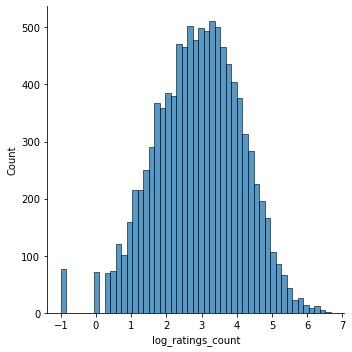

In [291]:
sns.displot(df.log_ratings_count)

In [292]:
# Define the bins using logarithmic scale
# since the distribution of the ratings_count_updt column is highly skewed, 
# using logarithmic bins is a good choice for creating more evenly distributed categories.
bins = [-1, np.log10(10), np.log10(100), np.log10(1000), np.log10(10000), np.log10(100000), np.inf]

In [293]:
# Define the labels for each category
labels = ['very low', 'low', 'medium', 'medium high', 'high', 'very high']

In [294]:
# Use pandas cut() function to categorize the values creating a new column with the category labels based on the log_ratings_count_updt column
df['ratings_count_category'] = pd.cut(df['log_ratings_count'], bins=bins, labels=labels)

In [295]:
df['ratings_count_category'].value_counts()

medium high    3002
medium         2905
low            1817
high           1610
very low        549
very high       352
Name: ratings_count_category, dtype: int64

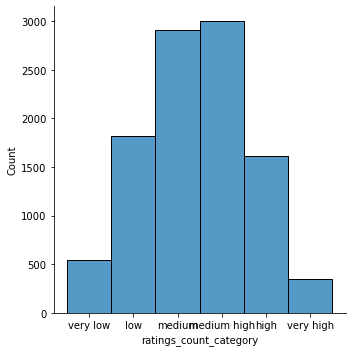

In [296]:
sns.displot(df.ratings_count_category)

In [297]:
# other different bin sizes tried
# bins2 = [-1, np.log10(100), np.log10(1000), np.log10(10000), np.log10(100000), np.log10(1000000), np.inf]
# medium         3002
# low            2905
# very low       2366
# medium high    1610
# high            322
# very high        30

# bins3 = [-np.inf, np.log10(100), np.log10(1000), np.log10(10000), np.log10(100000), np.log10(1000000), np.inf]
# medium         3002
# low            2905
# very low       2442
# medium high    1610
# high            322
# very high        30

In [298]:
# from categorical categories to numerical categories
# Use same function to map the values (set_value)
 
# Create the dictionary that assigns a number to each category
ratingscat_dictionary ={'very low' : 1, 'low' : 2, 'medium' : 3, 'medium high' : 4, 'high' : 5, 'very high' : 6}
 
# Add a new column named 'ratings_count_category_T'
df['ratings_count_category_T'] = df['ratings_count_category'].apply(set_value, args =(ratingscat_dictionary, ))

In [299]:
df.head()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth,avg_numpages_publisher,n_pages_vs_avg_pub,avg_rating_author,rating_vs_avg_auth,avg_rating_publisher,rating_vs_avg_pub,rating_vs_avg,rating_vs_mode,pub_month,pub_year,pub_month_text,season,season_num,century,language_code_ENgroup,log_ratings_count,ratings_count_category,ratings_count_category_T
1847,6549,said the shotgun to the head.,saul williams,4.22,0743470796,9780743470797,en-us,192,2762,214,2003-09-01,mtv books,said the shotgun to the head,saul williams,food,0,1,[saul williams],saul williams,2762,214,192,2976,192.00,1.00,202.67,0.95,4.22,1.00,4.05,1.04,1.072978,1.0550,9,2003,september,autumn,4,20,eng,3.441239,medium high,4
4072,14490,$30 film school: how to write direct produce...,michael w. dean,3.49,1592000673,9781592000678,eng,528,30,4,2003-05-13,cengage learning,$30 film school,michael w. dean,art,0,1,[michael w. dean],michael w. dean,30,4,528,34,528.00,1.00,526.17,1.00,3.49,1.00,3.61,0.97,0.887368,0.8725,5,2003,may,spring,2,20,eng,1.478566,low,2
1574,5415,'salem's lot,stephen king,4.02,0965772411,9780965772419,eng,405,1039,130,1975-10-17,doubleday,salem's lot,stephen king,autobiography-biography,0,1,[stephen king],stephen king,85852,826,817,86678,458.08,1.78,399.09,2.05,3.98,1.01,3.92,1.03,1.022126,1.0050,10,1975,october,autumn,4,19,eng,4.933751,high,5
3137,11525,1 000 places to see before you die,patricia schultz,3.85,0761104844,9780761104841,eng,992,36303,439,2003-05-22,workman publishing company,"1,000 places to see before you die",patricia schultz,guidebook,0,1,[patricia schultz],patricia schultz,36303,439,992,36742,992.00,1.00,534.14,1.86,3.85,1.00,4.07,0.95,0.978902,0.9625,5,2003,may,spring,2,20,eng,4.559944,high,5
2343,8542,10 lb penalty,dick francis,3.90,042519745X,9780425197455,eng,320,3490,177,2004-08-03,g.p. putnam's sons,10 lb penalty,dick francis,mystery,0,1,[dick francis],dick francis,3490,177,320,3667,321.62,0.99,387.48,0.83,3.96,0.99,3.93,0.99,0.991615,0.9750,8,2004,august,summer,3,20,eng,3.542838,medium high,4


In [300]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10311 entries, 1847 to 4261
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   bookid                    10311 non-null  int64         
 1   title                     10311 non-null  object        
 2   authors                   10311 non-null  object        
 3   average_rating            10311 non-null  float64       
 4   isbn                      10311 non-null  object        
 5   isbn13                    10311 non-null  int64         
 6   language_code             10311 non-null  object        
 7   num_pages                 10311 non-null  int64         
 8   ratings_count             10311 non-null  int64         
 9   text_reviews_count        10311 non-null  int64         
 10  publication_date          10311 non-null  datetime64[ns]
 11  publisher                 10311 non-null  object        
 12  title2          

In [301]:
# Dealing with NA created with the transformation into categories

In [302]:
df[df['ratings_count_category'].isna()]

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth,avg_numpages_publisher,n_pages_vs_avg_pub,avg_rating_author,rating_vs_avg_auth,avg_rating_publisher,rating_vs_avg_pub,rating_vs_avg,rating_vs_mode,pub_month,pub_year,pub_month_text,season,season_num,century,language_code_ENgroup,log_ratings_count,ratings_count_category,ratings_count_category_T
3240,11880,a book of blue flowers,robert l. geneve,3.83,0881927694,9780881927696,eng,327,0,0,2006-02-01,timber press (or),a book of blue flowers,robert l. geneve,nature-animals,0,1,[robert l. geneve],robert l. geneve,0,0,327,0,327.00,1.00,327.00,1.00,3.83,1.00,3.83,1.00,0.973817,0.9575,2,2006,february,winter,1,20,eng,-1.0,NaN,NaN
10849,44321,a cargo of women: susannah watson and the conv...,babette smith,3.58,1877058335,9781877058332,eng,264,0,0,2005-06-01,rosenberg publishing,a cargo of women,babette smith,novel-narrative,0,1,[babette smith],babette smith,0,0,264,0,264.00,1.00,264.00,1.00,3.58,1.00,3.58,1.00,0.910252,0.8950,6,2005,june,summer,3,20,eng,-1.0,NaN,NaN
7751,29927,a farewell to arms?: beyond the good friday ag...,adrian guelke/michael cox/fiona stephen,4.33,0719071151,9780719071157,eng,624,0,0,2006-04-18,manchester university press,a farewell to arms?,michael cox,novel-narrative,1,3,"[adrian guelke, michael cox, fiona stephen]",adrian guelke,0,0,624,0,624.00,1.00,624.00,1.00,4.33,1.00,4.33,1.00,1.100947,1.0825,4,2006,april,spring,2,20,eng,-1.0,NaN,NaN
3348,12225,a streetcar named desire (sparknotes literatur...,sparknotes,3.29,1586634496,9781586634490,eng,96,0,0,2002-07-15,sparknotes,spark notes streetcar named desire,sparknotes,religious-philosophical,0,1,[sparknotes],sparknotes,0,0,96,0,82.00,1.17,115.00,0.83,3.68,0.89,3.69,0.89,0.836516,0.8225,7,2002,july,summer,3,20,eng,-1.0,NaN,NaN
10442,42489,after collapse: the regeneration of complex so...,glenn m. schwartz,4.00,0816525099,9780816525096,eng,336,0,0,2006-05-25,university of arizona press,after collapse,glenn m. schwartz,novel-narrative,0,1,[glenn m. schwartz],glenn m. schwartz,0,0,336,0,336.00,1.00,336.00,1.00,4.00,1.00,4.00,1.00,1.017041,1.0000,5,2006,may,spring,2,20,eng,-1.0,NaN,NaN
4241,15186,american film guide,frank n. magill,0.00,0893562505,9780893562502,eng,5,0,0,1983-01-01,salem press inc,magill's american film guide,stephen l. hanson,art,0,1,[frank n. magill],frank n. magill,0,0,5,0,5.00,1.00,5.00,1.00,0.00,NaN,0.00,NaN,0.000000,0.0000,1,1983,january,winter,1,19,eng,-1.0,NaN,NaN
525,1658,american government: continuity and change al...,karen o'connor/larry j. sabato,2.83,0321317106,9780321317100,eng,664,0,0,2005-03-11,longman publishing group,american government,karen o'connor,social-political,1,2,"[karen o'connor, larry j. sabato]",karen o'connor,0,0,664,0,800.40,0.83,750.71,0.88,3.10,0.91,3.32,0.85,0.719557,0.7075,3,2005,march,spring,2,20,eng,-1.0,NaN,NaN
4746,17045,american government: continuity and change te...,karen o'connor/larry j. sabato,2.83,0321365607,9780321365606,eng,1088,0,0,2005-05-26,longman publishing group,american government,karen o'connor,social-political,1,2,"[karen o'connor, larry j. sabato]",karen o'connor,0,0,1088,0,800.40,1.36,750.71,1.45,3.10,0.91,3.32,0.85,0.719557,0.7075,5,2005,may,spring,2,20,eng,-1.0,NaN,NaN
6558,24749,american writers supplement viii,jay parini/august wilson,0.00,0684806371,9780684806372,eng,400,0,0,2001-05-01,gale cengage,american writers: a collection of literary bio...,jay parini/august wilson,not specified,1,2,"[jay parini, august wilson]",jay parini,0,0,400,0,480.67,0.83,400.00,1.00,2.69,0.00,0.00,NaN,0.000000,0.0000,5,2001,may,spring,2,20,eng,-1.0,NaN,NaN
6813,25685,an odyssey in learning and perception,eleanor j. gibson,4.50,026257103X,9780262571036,eng,654,0,0,1994-02-03,bradford book,an odyssey in

In [303]:
df['ratings_count_category'].isna().sum()

76

In [304]:
df['ratings_count_updt'][df['ratings_count_category'].isna()] #if there is a NA in ratings_count_category the ratings_count_updt == 0

3240     0
10849    0
7751     0
3348     0
10442    0
4241     0
525      0
4746     0
6558     0
6813     0
2255     0
11027    0
935      0
7797     0
10262    0
10309    0
3492     0
5323     0
8052     0
3235     0
9437     0
624      0
10862    0
10138    0
8742     0
1110     0
526      0
9198     0
2532     0
6877     0
2533     0
4213     0
375      0
7175     0
8763     0
6560     0
4854     0
9063     0
6380     0
6999     0
3133     0
3007     0
264      0
5724     0
6806     0
747      0
10513    0
9155     0
7144     0
987      0
8875     0
265      0
7869     0
3379     0
9331     0
3006     0
7399     0
7209     0
9698     0
9847     0
2051     0
7573     0
5779     0
6393     0
10497    0
5475     0
10917    0
4677     0
6859     0
1681     0
2758     0
6973     0
10164    0
2956     0
7634     0
6084     0
Name: ratings_count_updt, dtype: int64

In [305]:
# look for 0 values in ratings_count and text_reviews_count
df[['average_rating']][(df[['ratings_count_updt','text_reviews_count_updt']]==0).any(1)]

,average_rating
9265,3.11
4821,4.41
8853,4.09
10913,4.16
3240,3.83
...,...
8316,4.58
8322,4.57
8319,4.57
4268,4.44


In [306]:
# what is the average rating when either ratings_count_updt or text_reviews_count_updt have 0 value ?

In [307]:
df[['average_rating']][(df[['ratings_count_updt','text_reviews_count_updt']]==0).any(1)].mean() # rows with 0 value in either ratings_count or text_reviews_count or both

average_rating    3.75622
dtype: float64

In [308]:
df[['average_rating']][(df[['ratings_count_updt','text_reviews_count_updt']]==0).any(1)].mode() # rows with 0 value in either ratings_count or text_reviews_count or both

,average_rating
0,4.0


In [309]:
df[['average_rating']][(df[['ratings_count_updt','text_reviews_count_updt']]==0).any(1)].median() # rows with 0 value in either ratings_count or text_reviews_count or both

average_rating    3.94
dtype: float64

In [310]:
# look for 0 or 5 values in average_rating when both ratings_count and text_reviews_count == 0
df[['average_rating','title','main_author']][(df[['ratings_count_updt','text_reviews_count_updt']]==0).any(1)  & ((df[['average_rating']]==0) | (df[['average_rating']]==5)).any(1)]

,average_rating,title,main_author
4241,0.0,american film guide,frank n. magill
6558,0.0,american writers supplement viii,jay parini
11027,0.0,anthony thwaite: in conversation with peter da...,peter dale
7797,0.0,beckett football card price guide,dan hitt
10262,5.0,bill gates: computer legend (famous lives),sara barton-wood
3492,0.0,brodie's notes on aldous huxley's brave new world,graham handley
4933,5.0,bulgakov's the master and margarita: the text ...,elena n. mahlow
5323,0.0,canopy: a work for voice and light in harvard ...,david ward
9437,0.0,classroom interactions as cross-cultural encou...,jasmine c.m. luk
5648,5.0,colossians and philemon: a critical and exeget...,r. mcl. wilson


In [311]:
# look for 0 or 5 values in average_rating when both ratings_count and text_reviews_count == 0
df[['average_rating','title','main_author']][(df[['ratings_count_updt','text_reviews_count_updt']]==0).any(1)  & ((df[['average_rating']]==0) | (df[['average_rating']]==5)).any(1)].count()

average_rating    41
title             41
main_author       41
dtype: int64

In [312]:
# dropping the rows where both ratings_count and text_reviews_count == 0 & average_rating is either 0 or 5
df = df[~(((df['ratings_count_updt'] == 0) & (df['text_reviews_count_updt'] == 0) & ((df['average_rating'] == 0) | (df['average_rating'] == 5))))] 
# drop rows where ratings_count_updt and text_reviews_count_updt are both 0 and average_rating is either 0 or 5

In [313]:
df[df['ratings_count_category'].isna()]

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth,avg_numpages_publisher,n_pages_vs_avg_pub,avg_rating_author,rating_vs_avg_auth,avg_rating_publisher,rating_vs_avg_pub,rating_vs_avg,rating_vs_mode,pub_month,pub_year,pub_month_text,season,season_num,century,language_code_ENgroup,log_ratings_count,ratings_count_category,ratings_count_category_T
3240,11880,a book of blue flowers,robert l. geneve,3.83,0881927694,9780881927696,eng,327,0,0,2006-02-01,timber press (or),a book of blue flowers,robert l. geneve,nature-animals,0,1,[robert l. geneve],robert l. geneve,0,0,327,0,327.00,1.00,327.00,1.00,3.83,1.00,3.83,1.00,0.973817,0.9575,2,2006,february,winter,1,20,eng,-1.0,NaN,NaN
10849,44321,a cargo of women: susannah watson and the conv...,babette smith,3.58,1877058335,9781877058332,eng,264,0,0,2005-06-01,rosenberg publishing,a cargo of women,babette smith,novel-narrative,0,1,[babette smith],babette smith,0,0,264,0,264.00,1.00,264.00,1.00,3.58,1.00,3.58,1.00,0.910252,0.8950,6,2005,june,summer,3,20,eng,-1.0,NaN,NaN
7751,29927,a farewell to arms?: beyond the good friday ag...,adrian guelke/michael cox/fiona stephen,4.33,0719071151,9780719071157,eng,624,0,0,2006-04-18,manchester university press,a farewell to arms?,michael cox,novel-narrative,1,3,"[adrian guelke, michael cox, fiona stephen]",adrian guelke,0,0,624,0,624.00,1.00,624.00,1.00,4.33,1.00,4.33,1.00,1.100947,1.0825,4,2006,april,spring,2,20,eng,-1.0,NaN,NaN
3348,12225,a streetcar named desire (sparknotes literatur...,sparknotes,3.29,1586634496,9781586634490,eng,96,0,0,2002-07-15,sparknotes,spark notes streetcar named desire,sparknotes,religious-philosophical,0,1,[sparknotes],sparknotes,0,0,96,0,82.00,1.17,115.00,0.83,3.68,0.89,3.69,0.89,0.836516,0.8225,7,2002,july,summer,3,20,eng,-1.0,NaN,NaN
10442,42489,after collapse: the regeneration of complex so...,glenn m. schwartz,4.00,0816525099,9780816525096,eng,336,0,0,2006-05-25,university of arizona press,after collapse,glenn m. schwartz,novel-narrative,0,1,[glenn m. schwartz],glenn m. schwartz,0,0,336,0,336.00,1.00,336.00,1.00,4.00,1.00,4.00,1.00,1.017041,1.0000,5,2006,may,spring,2,20,eng,-1.0,NaN,NaN
525,1658,american government: continuity and change al...,karen o'connor/larry j. sabato,2.83,0321317106,9780321317100,eng,664,0,0,2005-03-11,longman publishing group,american government,karen o'connor,social-political,1,2,"[karen o'connor, larry j. sabato]",karen o'connor,0,0,664,0,800.40,0.83,750.71,0.88,3.10,0.91,3.32,0.85,0.719557,0.7075,3,2005,march,spring,2,20,eng,-1.0,NaN,NaN
4746,17045,american government: continuity and change te...,karen o'connor/larry j. sabato,2.83,0321365607,9780321365606,eng,1088,0,0,2005-05-26,longman publishing group,american government,karen o'connor,social-political,1,2,"[karen o'connor, larry j. sabato]",karen o'connor,0,0,1088,0,800.40,1.36,750.71,1.45,3.10,0.91,3.32,0.85,0.719557,0.7075,5,2005,may,spring,2,20,eng,-1.0,NaN,NaN
6813,25685,an odyssey in learning and perception,eleanor j. gibson,4.50,026257103X,9780262571036,eng,654,0,0,1994-02-03,bradford book,an odyssey in learning and perception (learnin...,eleanor j. gibson,social-political,0,1,[eleanor j. gibson],eleanor j. gibson,0,0,654,0,654.00,1.00,389.25,1.68,4.50,1.00,4.08,1.10,1.144171,1.1250,2,1994,february,winter,1,19,eng,-1.0,NaN,NaN
2255,8077,animales no se visten los (animals should def...,judi barrett/ron barrett,4.11,1595191356,9781595191359,eng,32,0,0,1991-10-30,live oak media,animales no se visten.,judi barrett/ron barrett,nature-animals,1,2,"[judi barrett, ron barrett]",judi barrett,0,0,32,0,32.00,1.00,32.00,1.00,4.02,1.02,4.11,1.00,1.045010,1.0275,10,1991,october,autumn,4,19,eng,-1.0,NaN,NaN
935,3084,april may und june,elizabeth von arnim,3.88,345833422X,9783458334224,ger,88,

In [314]:
df.isna().sum()

bookid                       0
title                        0
authors                      0
average_rating               0
isbn                         0
isbn13                       0
language_code                0
num_pages                    0
ratings_count                0
text_reviews_count           0
publication_date             0
publisher                    0
title2                       0
author2                      0
genre                        0
multiple_authors             0
n_authors                    0
authors_list                 0
main_author                  0
ratings_count_updt           0
text_reviews_count_updt      0
max_pages                    0
total_reviews                0
avg_numpages_author          0
n_pages_vs_avg_auth          0
avg_numpages_publisher       0
n_pages_vs_avg_pub           0
avg_rating_author            0
rating_vs_avg_auth           1
avg_rating_publisher         0
rating_vs_avg_pub            1
rating_vs_avg                0
rating_v

In [315]:
df['ratings_count_category'] = df['ratings_count_category'].fillna('very low')
df['ratings_count_category_T'] = df['ratings_count_category_T'].fillna(1)

In [316]:
df.isna().sum()

bookid                      0
title                       0
authors                     0
average_rating              0
isbn                        0
isbn13                      0
language_code               0
num_pages                   0
ratings_count               0
text_reviews_count          0
publication_date            0
publisher                   0
title2                      0
author2                     0
genre                       0
multiple_authors            0
n_authors                   0
authors_list                0
main_author                 0
ratings_count_updt          0
text_reviews_count_updt     0
max_pages                   0
total_reviews               0
avg_numpages_author         0
n_pages_vs_avg_auth         0
avg_numpages_publisher      0
n_pages_vs_avg_pub          0
avg_rating_author           0
rating_vs_avg_auth          1
avg_rating_publisher        0
rating_vs_avg_pub           1
rating_vs_avg               0
rating_vs_mode              0
pub_month 

In [317]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10284 entries, 1847 to 4261
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   bookid                    10284 non-null  int64         
 1   title                     10284 non-null  object        
 2   authors                   10284 non-null  object        
 3   average_rating            10284 non-null  float64       
 4   isbn                      10284 non-null  object        
 5   isbn13                    10284 non-null  int64         
 6   language_code             10284 non-null  object        
 7   num_pages                 10284 non-null  int64         
 8   ratings_count             10284 non-null  int64         
 9   text_reviews_count        10284 non-null  int64         
 10  publication_date          10284 non-null  datetime64[ns]
 11  publisher                 10284 non-null  object        
 12  title2          

In [318]:
df.shape

(10284, 43)

In [319]:
# Creating categories for 'text_reviews_count_updt'

In [320]:
df['text_reviews_count_updt'].min()

0

In [321]:
df['text_reviews_count_updt'].max()

94265

In [322]:
# Apply the log function to the 'ratings_count_updt' column
# Add a small value to 'ratings_count_updt' to avoid taking the log of 0
df['log_text_reviews_count_updt'] = np.log10(df['text_reviews_count_updt'] + 0.1 )

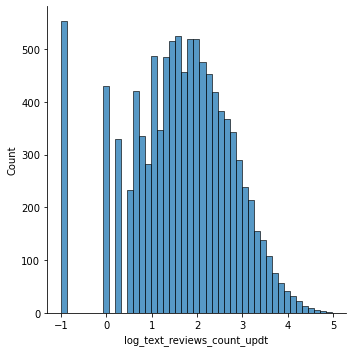

In [323]:
sns.displot(df.log_text_reviews_count_updt)

In [324]:
# Define the bins using logarithmic scale
# since the distribution of the ratings_count_updt column is highly skewed, 
# using logarithmic bins is a good choice for creating more evenly distributed categories.
bins = [-1, np.log10(5), np.log10(100), np.log10(1000), np.log10(10000), np.log10(100000)]

In [325]:
np.log10(100)

2.0

In [326]:
# Define the labels for each category
labels = ['very low', 'low', 'medium', 'high', 'very high']

In [327]:
# Use pandas cut() function to categorize the values creating a new column with the category labels based on the log_ratings_count_updt column
df['text_reviews_count_category'] = pd.cut(df['log_text_reviews_count_updt'], bins=bins, labels=labels)

In [328]:
df['text_reviews_count_category'].value_counts()

low          4448
medium       2991
very low     1216
high          981
very high      95
Name: text_reviews_count_category, dtype: int64

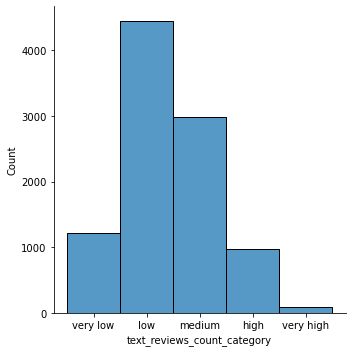

In [329]:
sns.displot(df.text_reviews_count_category)

In [330]:
# from categorical categories to numerical categories
# Use same function to map the values (set_value)
 
# Create the dictionary that assigns a number to each category
ratingscat_dictionary ={'very low' : 1, 'low' : 2, 'medium' : 3, 'high' : 4, 'very high' : 5}
 
# Add a new column named 'text_reviews_count_category_T'
df['text_reviews_count_category_T'] = df['text_reviews_count_category'].apply(set_value, args =(ratingscat_dictionary, ))

In [331]:
df.head()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth,avg_numpages_publisher,n_pages_vs_avg_pub,avg_rating_author,rating_vs_avg_auth,avg_rating_publisher,rating_vs_avg_pub,rating_vs_avg,rating_vs_mode,pub_month,pub_year,pub_month_text,season,season_num,century,language_code_ENgroup,log_ratings_count,ratings_count_category,ratings_count_category_T,log_text_reviews_count_updt,text_reviews_count_category,text_reviews_count_category_T
1847,6549,said the shotgun to the head.,saul williams,4.22,0743470796,9780743470797,en-us,192,2762,214,2003-09-01,mtv books,said the shotgun to the head,saul williams,food,0,1,[saul williams],saul williams,2762,214,192,2976,192.00,1.00,202.67,0.95,4.22,1.00,4.05,1.04,1.072978,1.0550,9,2003,september,autumn,4,20,eng,3.441239,medium high,4,2.330617,medium,3
4072,14490,$30 film school: how to write direct produce...,michael w. dean,3.49,1592000673,9781592000678,eng,528,30,4,2003-05-13,cengage learning,$30 film school,michael w. dean,art,0,1,[michael w. dean],michael w. dean,30,4,528,34,528.00,1.00,526.17,1.00,3.49,1.00,3.61,0.97,0.887368,0.8725,5,2003,may,spring,2,20,eng,1.478566,low,2,0.612784,very low,1
1574,5415,'salem's lot,stephen king,4.02,0965772411,9780965772419,eng,405,1039,130,1975-10-17,doubleday,salem's lot,stephen king,autobiography-biography,0,1,[stephen king],stephen king,85852,826,817,86678,458.08,1.78,399.09,2.05,3.98,1.01,3.92,1.03,1.022126,1.0050,10,1975,october,autumn,4,19,eng,4.933751,high,5,2.917033,medium,3
3137,11525,1 000 places to see before you die,patricia schultz,3.85,0761104844,9780761104841,eng,992,36303,439,2003-05-22,workman publishing company,"1,000 places to see before you die",patricia schultz,guidebook,0,1,[patricia schultz],patricia schultz,36303,439,992,36742,992.00,1.00,534.14,1.86,3.85,1.00,4.07,0.95,0.978902,0.9625,5,2003,may,spring,2,20,eng,4.559944,high,5,2.642563,medium,3
2343,8542,10 lb penalty,dick francis,3.90,042519745X,9780425197455,eng,320,3490,177,2004-08-03,g.p. putnam's sons,10 lb penalty,dick francis,mystery,0,1,[dick francis],dick francis,3490,177,320,3667,321.62,0.99,387.48,0.83,3.96,0.99,3.93,0.99,0.991615,0.9750,8,2004,august,summer,3,20,eng,3.542838,medium high,4,2.248219,medium,3


In [332]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10284 entries, 1847 to 4261
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   bookid                         10284 non-null  int64         
 1   title                          10284 non-null  object        
 2   authors                        10284 non-null  object        
 3   average_rating                 10284 non-null  float64       
 4   isbn                           10284 non-null  object        
 5   isbn13                         10284 non-null  int64         
 6   language_code                  10284 non-null  object        
 7   num_pages                      10284 non-null  int64         
 8   ratings_count                  10284 non-null  int64         
 9   text_reviews_count             10284 non-null  int64         
 10  publication_date               10284 non-null  datetime64[ns]
 11  publisher    

In [333]:
# Dealing with NA created with the transformation into categories

In [334]:
df[df['text_reviews_count_category'].isna()]

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth,avg_numpages_publisher,n_pages_vs_avg_pub,avg_rating_author,rating_vs_avg_auth,avg_rating_publisher,rating_vs_avg_pub,rating_vs_avg,rating_vs_mode,pub_month,pub_year,pub_month_text,season,season_num,century,language_code_ENgroup,log_ratings_count,ratings_count_category,ratings_count_category_T,log_text_reviews_count_updt,text_reviews_count_category,text_reviews_count_category_T
9265,36361,1848: the revolution of the intellectuals,lewis b. namier/james joll,3.11,0197261116,9780197261118,eng,144,15,0,1992-03-12,british academy,1848,"namier, lewis bernstein sir",novel-narrative,1,2,"[lewis b. namier, james joll]",lewis b. namier,15,0,144,15,144.00,1.00,144.0,1.00,3.11,1.00,3.11,1.00,0.790750,0.7775,3,1992,march,spring,2,19,eng,1.178977,low,2,-1.0,NaN,NaN
4821,17297,1912 manuscript on the special theory of relat...,albert einstein/hanoch gutfreund,4.41,0807615323,9780807615324,eng,174,17,0,2004-05-17,george braziller inc.,einstein's 1912 manuscript on the special theo...,albert einstein,autobiography-biography,1,2,"[albert einstein, hanoch gutfreund]",albert einstein,17,0,174,17,198.00,0.88,174.0,1.00,4.27,1.03,4.41,1.00,1.121288,1.1025,5,2004,may,spring,2,20,eng,1.232996,low,2,-1.0,NaN,NaN
8853,34247,200 quilt blocks: to mix and match,davina thomas,4.09,0896892026,9780896892026,eng,128,5,0,2005-10-01,krause publications,200 quilt blocks to mix and match,davina thomas,art,0,1,[davina thomas],davina thomas,5,0,128,5,128.00,1.00,128.0,1.00,4.09,1.00,4.09,1.00,1.039925,1.0225,10,2005,october,autumn,4,20,eng,0.707570,very low,1,-1.0,NaN,NaN
10913,44649,7 hábitos de las familias altamente efectivas,stephen r. covey,4.16,1400083419,9781400083411,spa,412,7,0,2003-09-01,grijalbo,7 hábitos de las familias altamente efectivas,stephen r. covey,not specified,0,1,[stephen r. covey],stephen r. covey,7,0,412,7,349.71,1.18,412.0,1.00,4.10,1.01,4.16,1.00,1.057723,1.0400,9,2003,september,autumn,4,20,spa,0.851258,very low,1,-1.0,NaN,NaN
3240,11880,a book of blue flowers,robert l. geneve,3.83,0881927694,9780881927696,eng,327,0,0,2006-02-01,timber press (or),a book of blue flowers,robert l. geneve,nature-animals,0,1,[robert l. geneve],robert l. geneve,0,0,327,0,327.00,1.00,327.0,1.00,3.83,1.00,3.83,1.00,0.973817,0.9575,2,2006,february,winter,1,20,eng,-1.000000,very low,1,-1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8316,31993,鋼之鍊金術師 6,hiromu arakawa/荒川弘/方郁仁,4.58,9861146148,9789861146140,zho,191,5,0,2004-06-02,東立,fullmetal alchemist (gang zhi lian jin shu shi...,hiromu arakawa,mixed,1,3,"[hiromu arakawa, 荒川弘, 方郁仁]",hiromu arakawa,5,0,191,5,186.85,1.02,187.5,1.02,4.55,1.01,4.56,1.01,1.164512,1.1450,6,2004,june,summer,3,20,zho,0.707570,very low,1,-1.0,NaN,NaN
8322,31999,鋼之鍊金術師 7,hiromu arakawa/荒川弘/方郁仁,4.57,9861146156,9789861146157,zho,191,5,0,2004-06-12,東立,fullmetal alchemist 7 (in traditional chinese),hiromu arakawa/荒川弘/方郁仁,not specified,1,3,"[hiromu arakawa, 荒川弘, 方郁仁]",hiromu arakawa,5,0,191,5,186.85,1.02,187.5,1.02,4.55,1.00,4.56,1.00,1.161970,1.1425,6,2004,june,summer,3,20,zho,0.707570,very low,1,-1.0,NaN,NaN
8319,31996,鋼之鍊金術師 9,hiromu arakawa/荒川弘/方郁仁,4.57,9861156526,9789861156521,zho,184,4,0,2004-12-16,東立,鋼之鍊金術師 9,hiromu arakawa/荒川弘/方郁仁,not specified,1,3,"[hiromu arakawa, 荒川弘, 方郁仁]",hiromu arakawa,4,0,184,4,186.85,0.98,187.5,0.98,4.55,1.00,4.56,1.00,1.161970,1.1425,12,2004,december,winter,1,20,zho,0.612784,very low,1,-1.0,NaN,NaN
4268,15318,魔戒二部曲：雙城奇謀,j.r.r. tolkien/托爾金/alan lee/朱學恆,4.44,9570823372,9789570823370,zho,467,24,0,2001-12-20,聯經出版事業股份有限公司,mo jie er bu qu,j.r.r. tolkien,fantasy,1,

In [335]:
df['text_reviews_count_category'].isna().sum()

553

In [336]:
df['text_reviews_count_updt'][df['text_reviews_count_category'].isna()] #if there is a NA in text_reviews_count_category the text_reviews_count_updt == 0

9265     0
4821     0
8853     0
10913    0
3240     0
        ..
8316     0
8322     0
8319     0
4268     0
4261     0
Name: text_reviews_count_updt, Length: 553, dtype: int64

In [337]:
df['text_reviews_count_category'] = df['text_reviews_count_category'].fillna('very low')
df['text_reviews_count_category_T'] = df['text_reviews_count_category_T'].fillna(1)

In [338]:
df.isna().sum()

bookid                           0
title                            0
authors                          0
average_rating                   0
isbn                             0
isbn13                           0
language_code                    0
num_pages                        0
ratings_count                    0
text_reviews_count               0
publication_date                 0
publisher                        0
title2                           0
author2                          0
genre                            0
multiple_authors                 0
n_authors                        0
authors_list                     0
main_author                      0
ratings_count_updt               0
text_reviews_count_updt          0
max_pages                        0
total_reviews                    0
avg_numpages_author              0
n_pages_vs_avg_auth              0
avg_numpages_publisher           0
n_pages_vs_avg_pub               0
avg_rating_author                0
rating_vs_avg_auth  

In [339]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10284 entries, 1847 to 4261
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   bookid                         10284 non-null  int64         
 1   title                          10284 non-null  object        
 2   authors                        10284 non-null  object        
 3   average_rating                 10284 non-null  float64       
 4   isbn                           10284 non-null  object        
 5   isbn13                         10284 non-null  int64         
 6   language_code                  10284 non-null  object        
 7   num_pages                      10284 non-null  int64         
 8   ratings_count                  10284 non-null  int64         
 9   text_reviews_count             10284 non-null  int64         
 10  publication_date               10284 non-null  datetime64[ns]
 11  publisher    

In [340]:
df.shape

(10284, 46)

In [341]:
# Creating categories for 'total_reviews'

In [342]:
# Apply the log function to the 'total_reviews' column
# Add a small value to 'total_reviews' to avoid taking the log of 0
df['log_total_reviews'] = np.log10(df['total_reviews'] + 0.1 )

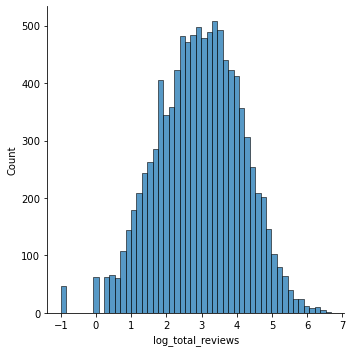

In [343]:
sns.displot(df.log_total_reviews)

In [344]:
# Define the bins using logarithmic scale
# since the distribution of the ratings_count_updt column is highly skewed, 
# using logarithmic bins is a good choice for creating more evenly distributed categories.
bins = [-1, np.log10(10), np.log10(100), np.log10(1000), np.log10(10000), np.log10(100000), np.inf]

In [345]:
# Define the labels for each category
labels = ['very low', 'low', 'medium', 'medium high', 'high', 'very high']

In [346]:
# Use pandas cut() function to categorize the values creating a new column with the category labels based on the log_ratings_count_updt column
df['total_reviews_category'] = pd.cut(df['log_total_reviews'], bins=bins, labels=labels)

In [347]:
df['total_reviews_category'].value_counts()

medium high    3046
medium         2913
low            1761
high           1651
very low        504
very high       362
Name: total_reviews_category, dtype: int64

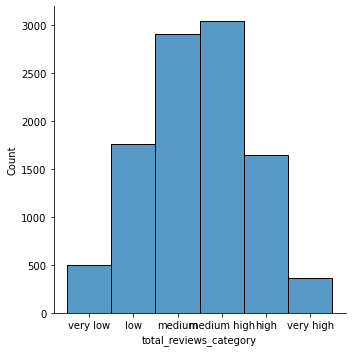

In [348]:
sns.displot(df.total_reviews_category)

In [349]:
# from categorical categories to numerical categories
# Use same function to map the values (set_value)
 
# Create the dictionary that assigns a number to each category
ratingscat_dictionary ={'very low' : 1, 'low' : 2, 'medium' : 3, 'medium high' : 4, 'high' : 5, 'very high' : 6}
 
# Add a new column named 'total_reviews_category_T'
df['total_reviews_category_T'] = df['total_reviews_category'].apply(set_value, args =(ratingscat_dictionary, ))

In [350]:
df.head()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth,avg_numpages_publisher,n_pages_vs_avg_pub,avg_rating_author,rating_vs_avg_auth,avg_rating_publisher,rating_vs_avg_pub,rating_vs_avg,rating_vs_mode,pub_month,pub_year,pub_month_text,season,season_num,century,language_code_ENgroup,log_ratings_count,ratings_count_category,ratings_count_category_T,log_text_reviews_count_updt,text_reviews_count_category,text_reviews_count_category_T,log_total_reviews,total_reviews_category,total_reviews_category_T
1847,6549,said the shotgun to the head.,saul williams,4.22,0743470796,9780743470797,en-us,192,2762,214,2003-09-01,mtv books,said the shotgun to the head,saul williams,food,0,1,[saul williams],saul williams,2762,214,192,2976,192.00,1.00,202.67,0.95,4.22,1.00,4.05,1.04,1.072978,1.0550,9,2003,september,autumn,4,20,eng,3.441239,medium high,4,2.330617,medium,3,3.473648,medium high,4
4072,14490,$30 film school: how to write direct produce...,michael w. dean,3.49,1592000673,9781592000678,eng,528,30,4,2003-05-13,cengage learning,$30 film school,michael w. dean,art,0,1,[michael w. dean],michael w. dean,30,4,528,34,528.00,1.00,526.17,1.00,3.49,1.00,3.61,0.97,0.887368,0.8725,5,2003,may,spring,2,20,eng,1.478566,low,2,0.612784,very low,1,1.532754,low,2
1574,5415,'salem's lot,stephen king,4.02,0965772411,9780965772419,eng,405,1039,130,1975-10-17,doubleday,salem's lot,stephen king,autobiography-biography,0,1,[stephen king],stephen king,85852,826,817,86678,458.08,1.78,399.09,2.05,3.98,1.01,3.92,1.03,1.022126,1.0050,10,1975,october,autumn,4,19,eng,4.933751,high,5,2.917033,medium,3,4.937909,high,5
3137,11525,1 000 places to see before you die,patricia schultz,3.85,0761104844,9780761104841,eng,992,36303,439,2003-05-22,workman publishing company,"1,000 places to see before you die",patricia schultz,guidebook,0,1,[patricia schultz],patricia schultz,36303,439,992,36742,992.00,1.00,534.14,1.86,3.85,1.00,4.07,0.95,0.978902,0.9625,5,2003,may,spring,2,20,eng,4.559944,high,5,2.642563,medium,3,4.565164,high,5
2343,8542,10 lb penalty,dick francis,3.90,042519745X,9780425197455,eng,320,3490,177,2004-08-03,g.p. putnam's sons,10 lb penalty,dick francis,mystery,0,1,[dick francis],dick francis,3490,177,320,3667,321.62,0.99,387.48,0.83,3.96,0.99,3.93,0.99,0.991615,0.9750,8,2004,august,summer,3,20,eng,3.542838,medium high,4,2.248219,medium,3,3.564323,medium high,4


In [351]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10284 entries, 1847 to 4261
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   bookid                         10284 non-null  int64         
 1   title                          10284 non-null  object        
 2   authors                        10284 non-null  object        
 3   average_rating                 10284 non-null  float64       
 4   isbn                           10284 non-null  object        
 5   isbn13                         10284 non-null  int64         
 6   language_code                  10284 non-null  object        
 7   num_pages                      10284 non-null  int64         
 8   ratings_count                  10284 non-null  int64         
 9   text_reviews_count             10284 non-null  int64         
 10  publication_date               10284 non-null  datetime64[ns]
 11  publisher    

In [352]:
df.isna().sum()

bookid                            0
title                             0
authors                           0
average_rating                    0
isbn                              0
isbn13                            0
language_code                     0
num_pages                         0
ratings_count                     0
text_reviews_count                0
publication_date                  0
publisher                         0
title2                            0
author2                           0
genre                             0
multiple_authors                  0
n_authors                         0
authors_list                      0
main_author                       0
ratings_count_updt                0
text_reviews_count_updt           0
max_pages                         0
total_reviews                     0
avg_numpages_author               0
n_pages_vs_avg_auth               0
avg_numpages_publisher            0
n_pages_vs_avg_pub                0
avg_rating_author           

In [353]:
# Dealing with NA created with the transformation into categories

In [354]:
df[df['total_reviews_category'].isna()] # missing values appear where total_reviews==0 so we fill them with the lowest category

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth,avg_numpages_publisher,n_pages_vs_avg_pub,avg_rating_author,rating_vs_avg_auth,avg_rating_publisher,rating_vs_avg_pub,rating_vs_avg,rating_vs_mode,pub_month,pub_year,pub_month_text,season,season_num,century,language_code_ENgroup,log_ratings_count,ratings_count_category,ratings_count_category_T,log_text_reviews_count_updt,text_reviews_count_category,text_reviews_count_category_T,log_total_reviews,total_reviews_category,total_reviews_category_T
3240,11880,a book of blue flowers,robert l. geneve,3.83,0881927694,9780881927696,eng,327,0,0,2006-02-01,timber press (or),a book of blue flowers,robert l. geneve,nature-animals,0,1,[robert l. geneve],robert l. geneve,0,0,327,0,327.00,1.00,327.00,1.00,3.83,1.00,3.83,1.00,0.973817,0.9575,2,2006,february,winter,1,20,eng,-1.0,very low,1,-1.0,very low,1,-1.0,NaN,NaN
10849,44321,a cargo of women: susannah watson and the conv...,babette smith,3.58,1877058335,9781877058332,eng,264,0,0,2005-06-01,rosenberg publishing,a cargo of women,babette smith,novel-narrative,0,1,[babette smith],babette smith,0,0,264,0,264.00,1.00,264.00,1.00,3.58,1.00,3.58,1.00,0.910252,0.8950,6,2005,june,summer,3,20,eng,-1.0,very low,1,-1.0,very low,1,-1.0,NaN,NaN
7751,29927,a farewell to arms?: beyond the good friday ag...,adrian guelke/michael cox/fiona stephen,4.33,0719071151,9780719071157,eng,624,0,0,2006-04-18,manchester university press,a farewell to arms?,michael cox,novel-narrative,1,3,"[adrian guelke, michael cox, fiona stephen]",adrian guelke,0,0,624,0,624.00,1.00,624.00,1.00,4.33,1.00,4.33,1.00,1.100947,1.0825,4,2006,april,spring,2,20,eng,-1.0,very low,1,-1.0,very low,1,-1.0,NaN,NaN
3348,12225,a streetcar named desire (sparknotes literatur...,sparknotes,3.29,1586634496,9781586634490,eng,96,0,0,2002-07-15,sparknotes,spark notes streetcar named desire,sparknotes,religious-philosophical,0,1,[sparknotes],sparknotes,0,0,96,0,82.00,1.17,115.00,0.83,3.68,0.89,3.69,0.89,0.836516,0.8225,7,2002,july,summer,3,20,eng,-1.0,very low,1,-1.0,very low,1,-1.0,NaN,NaN
10442,42489,after collapse: the regeneration of complex so...,glenn m. schwartz,4.00,0816525099,9780816525096,eng,336,0,0,2006-05-25,university of arizona press,after collapse,glenn m. schwartz,novel-narrative,0,1,[glenn m. schwartz],glenn m. schwartz,0,0,336,0,336.00,1.00,336.00,1.00,4.00,1.00,4.00,1.00,1.017041,1.0000,5,2006,may,spring,2,20,eng,-1.0,very low,1,-1.0,very low,1,-1.0,NaN,NaN
525,1658,american government: continuity and change al...,karen o'connor/larry j. sabato,2.83,0321317106,9780321317100,eng,664,0,0,2005-03-11,longman publishing group,american government,karen o'connor,social-political,1,2,"[karen o'connor, larry j. sabato]",karen o'connor,0,0,664,0,800.40,0.83,750.71,0.88,3.10,0.91,3.32,0.85,0.719557,0.7075,3,2005,march,spring,2,20,eng,-1.0,very low,1,-1.0,very low,1,-1.0,NaN,NaN
4746,17045,american government: continuity and change te...,karen o'connor/larry j. sabato,2.83,0321365607,9780321365606,eng,1088,0,0,2005-05-26,longman publishing group,american government,karen o'connor,social-political,1,2,"[karen o'connor, larry j. sabato]",karen o'connor,0,0,1088,0,800.40,1.36,750.71,1.45,3.10,0.91,3.32,0.85,0.719557,0.7075,5,2005,may,spring,2,20,eng,-1.0,very low,1,-1.0,very low,1,-1.0,NaN,NaN
6813,25685,an odyssey in learning and perception,eleanor j. gibson,4.50,026257103X,9780262571036,eng,654,0,0,1994-02-03,bradford book,an odyssey in learning and perception (learnin...,eleanor j. gibson,social-political,0,1,[eleanor j. gibson],eleanor j. gibson,0,0,654,0,654.00,1.00,389.25,1.68,4.50,1.00,4.08,1.10,1.144171,1.1250,2,1994,february,winter,1,19,eng,-1.0,very low,1,-1.0,very low,1,-1.0,NaN,NaN
2255,8077,animales no se visten los (animals shoul

In [355]:
df['total_reviews_category'].isna().sum()

47

In [356]:
df['total_reviews_category'] = df['total_reviews_category'].fillna('very low')
df['total_reviews_category_T'] = df['total_reviews_category_T'].fillna(1)

In [357]:
df.isna().sum()

bookid                           0
title                            0
authors                          0
average_rating                   0
isbn                             0
isbn13                           0
language_code                    0
num_pages                        0
ratings_count                    0
text_reviews_count               0
publication_date                 0
publisher                        0
title2                           0
author2                          0
genre                            0
multiple_authors                 0
n_authors                        0
authors_list                     0
main_author                      0
ratings_count_updt               0
text_reviews_count_updt          0
max_pages                        0
total_reviews                    0
avg_numpages_author              0
n_pages_vs_avg_auth              0
avg_numpages_publisher           0
n_pages_vs_avg_pub               0
avg_rating_author                0
rating_vs_avg_auth  

In [358]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10284 entries, 1847 to 4261
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   bookid                         10284 non-null  int64         
 1   title                          10284 non-null  object        
 2   authors                        10284 non-null  object        
 3   average_rating                 10284 non-null  float64       
 4   isbn                           10284 non-null  object        
 5   isbn13                         10284 non-null  int64         
 6   language_code                  10284 non-null  object        
 7   num_pages                      10284 non-null  int64         
 8   ratings_count                  10284 non-null  int64         
 9   text_reviews_count             10284 non-null  int64         
 10  publication_date               10284 non-null  datetime64[ns]
 11  publisher    

In [359]:
df.shape

(10284, 49)

###### Transform categoricals variable into numerical
- Language, author, genre, and publisher -> Transform in numerical data

In [360]:
df['main_author'].value_counts().shape

(4169,)

In [361]:
# transform categorical variables into numerical variables with map and dictionary assigning random integers to avoid creating ordinal relationships

# create dictionary of values to random integer mapping
value_map = {value: np.random.randint(100000) for value in df['main_author'].unique()}

# use map method to apply the mapping to the column
df['main_author_T'] = df['main_author'].map(value_map)

df.head()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth,avg_numpages_publisher,n_pages_vs_avg_pub,avg_rating_author,rating_vs_avg_auth,avg_rating_publisher,rating_vs_avg_pub,rating_vs_avg,rating_vs_mode,pub_month,pub_year,pub_month_text,season,season_num,century,language_code_ENgroup,log_ratings_count,ratings_count_category,ratings_count_category_T,log_text_reviews_count_updt,text_reviews_count_category,text_reviews_count_category_T,log_total_reviews,total_reviews_category,total_reviews_category_T,main_author_T
1847,6549,said the shotgun to the head.,saul williams,4.22,0743470796,9780743470797,en-us,192,2762,214,2003-09-01,mtv books,said the shotgun to the head,saul williams,food,0,1,[saul williams],saul williams,2762,214,192,2976,192.00,1.00,202.67,0.95,4.22,1.00,4.05,1.04,1.072978,1.0550,9,2003,september,autumn,4,20,eng,3.441239,medium high,4,2.330617,medium,3,3.473648,medium high,4,19794
4072,14490,$30 film school: how to write direct produce...,michael w. dean,3.49,1592000673,9781592000678,eng,528,30,4,2003-05-13,cengage learning,$30 film school,michael w. dean,art,0,1,[michael w. dean],michael w. dean,30,4,528,34,528.00,1.00,526.17,1.00,3.49,1.00,3.61,0.97,0.887368,0.8725,5,2003,may,spring,2,20,eng,1.478566,low,2,0.612784,very low,1,1.532754,low,2,69275
1574,5415,'salem's lot,stephen king,4.02,0965772411,9780965772419,eng,405,1039,130,1975-10-17,doubleday,salem's lot,stephen king,autobiography-biography,0,1,[stephen king],stephen king,85852,826,817,86678,458.08,1.78,399.09,2.05,3.98,1.01,3.92,1.03,1.022126,1.0050,10,1975,october,autumn,4,19,eng,4.933751,high,5,2.917033,medium,3,4.937909,high,5,74021
3137,11525,1 000 places to see before you die,patricia schultz,3.85,0761104844,9780761104841,eng,992,36303,439,2003-05-22,workman publishing company,"1,000 places to see before you die",patricia schultz,guidebook,0,1,[patricia schultz],patricia schultz,36303,439,992,36742,992.00,1.00,534.14,1.86,3.85,1.00,4.07,0.95,0.978902,0.9625,5,2003,may,spring,2,20,eng,4.559944,high,5,2.642563,medium,3,4.565164,high,5,40972
2343,8542,10 lb penalty,dick francis,3.90,042519745X,9780425197455,eng,320,3490,177,2004-08-03,g.p. putnam's sons,10 lb penalty,dick francis,mystery,0,1,[dick francis],dick francis,3490,177,320,3667,321.62,0.99,387.48,0.83,3.96,0.99,3.93,0.99,0.991615,0.9750,8,2004,august,summer,3,20,eng,3.542838,medium high,4,2.248219,medium,3,3.564323,medium high,4,21331


In [362]:
df.isna().sum()

bookid                           0
title                            0
authors                          0
average_rating                   0
isbn                             0
isbn13                           0
language_code                    0
num_pages                        0
ratings_count                    0
text_reviews_count               0
publication_date                 0
publisher                        0
title2                           0
author2                          0
genre                            0
multiple_authors                 0
n_authors                        0
authors_list                     0
main_author                      0
ratings_count_updt               0
text_reviews_count_updt          0
max_pages                        0
total_reviews                    0
avg_numpages_author              0
n_pages_vs_avg_auth              0
avg_numpages_publisher           0
n_pages_vs_avg_pub               0
avg_rating_author                0
rating_vs_avg_auth  

In [363]:
df['publisher'].value_counts().shape


(2170,)

In [364]:
# transform categorical variables into numerical variables with map and dictionary assigning random integers to avoid creating ordinal relationships

# create dictionary of values to random integer mapping
value_map = {value: np.random.randint(100000) for value in df['publisher'].unique()}

# use map method to apply the mapping to the column
df['publisher_T'] = df['publisher'].map(value_map)

df.head()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth,avg_numpages_publisher,n_pages_vs_avg_pub,avg_rating_author,rating_vs_avg_auth,avg_rating_publisher,rating_vs_avg_pub,rating_vs_avg,rating_vs_mode,pub_month,pub_year,pub_month_text,season,season_num,century,language_code_ENgroup,log_ratings_count,ratings_count_category,ratings_count_category_T,log_text_reviews_count_updt,text_reviews_count_category,text_reviews_count_category_T,log_total_reviews,total_reviews_category,total_reviews_category_T,main_author_T,publisher_T
1847,6549,said the shotgun to the head.,saul williams,4.22,0743470796,9780743470797,en-us,192,2762,214,2003-09-01,mtv books,said the shotgun to the head,saul williams,food,0,1,[saul williams],saul williams,2762,214,192,2976,192.00,1.00,202.67,0.95,4.22,1.00,4.05,1.04,1.072978,1.0550,9,2003,september,autumn,4,20,eng,3.441239,medium high,4,2.330617,medium,3,3.473648,medium high,4,19794,17706
4072,14490,$30 film school: how to write direct produce...,michael w. dean,3.49,1592000673,9781592000678,eng,528,30,4,2003-05-13,cengage learning,$30 film school,michael w. dean,art,0,1,[michael w. dean],michael w. dean,30,4,528,34,528.00,1.00,526.17,1.00,3.49,1.00,3.61,0.97,0.887368,0.8725,5,2003,may,spring,2,20,eng,1.478566,low,2,0.612784,very low,1,1.532754,low,2,69275,75466
1574,5415,'salem's lot,stephen king,4.02,0965772411,9780965772419,eng,405,1039,130,1975-10-17,doubleday,salem's lot,stephen king,autobiography-biography,0,1,[stephen king],stephen king,85852,826,817,86678,458.08,1.78,399.09,2.05,3.98,1.01,3.92,1.03,1.022126,1.0050,10,1975,october,autumn,4,19,eng,4.933751,high,5,2.917033,medium,3,4.937909,high,5,74021,24227
3137,11525,1 000 places to see before you die,patricia schultz,3.85,0761104844,9780761104841,eng,992,36303,439,2003-05-22,workman publishing company,"1,000 places to see before you die",patricia schultz,guidebook,0,1,[patricia schultz],patricia schultz,36303,439,992,36742,992.00,1.00,534.14,1.86,3.85,1.00,4.07,0.95,0.978902,0.9625,5,2003,may,spring,2,20,eng,4.559944,high,5,2.642563,medium,3,4.565164,high,5,40972,50747
2343,8542,10 lb penalty,dick francis,3.90,042519745X,9780425197455,eng,320,3490,177,2004-08-03,g.p. putnam's sons,10 lb penalty,dick francis,mystery,0,1,[dick francis],dick francis,3490,177,320,3667,321.62,0.99,387.48,0.83,3.96,0.99,3.93,0.99,0.991615,0.9750,8,2004,august,summer,3,20,eng,3.542838,medium high,4,2.248219,medium,3,3.564323,medium high,4,21331,29358


In [365]:
df.isna().sum()

bookid                           0
title                            0
authors                          0
average_rating                   0
isbn                             0
isbn13                           0
language_code                    0
num_pages                        0
ratings_count                    0
text_reviews_count               0
publication_date                 0
publisher                        0
title2                           0
author2                          0
genre                            0
multiple_authors                 0
n_authors                        0
authors_list                     0
main_author                      0
ratings_count_updt               0
text_reviews_count_updt          0
max_pages                        0
total_reviews                    0
avg_numpages_author              0
n_pages_vs_avg_auth              0
avg_numpages_publisher           0
n_pages_vs_avg_pub               0
avg_rating_author                0
rating_vs_avg_auth  

In [366]:
df['language_code'].value_counts().shape

(25,)

In [367]:
# transform categorical variables into numerical variables with map and dictionary assigning random integers to avoid creating ordinal relationships

# create dictionary of values to random integer mapping
value_map = {value: np.random.randint(100000) for value in df['language_code'].unique()}

# use map method to apply the mapping to the column
df['language_code_T'] = df['language_code'].map(value_map)

df.head()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth,avg_numpages_publisher,n_pages_vs_avg_pub,avg_rating_author,rating_vs_avg_auth,avg_rating_publisher,rating_vs_avg_pub,rating_vs_avg,rating_vs_mode,pub_month,pub_year,pub_month_text,season,season_num,century,language_code_ENgroup,log_ratings_count,ratings_count_category,ratings_count_category_T,log_text_reviews_count_updt,text_reviews_count_category,text_reviews_count_category_T,log_total_reviews,total_reviews_category,total_reviews_category_T,main_author_T,publisher_T,language_code_T
1847,6549,said the shotgun to the head.,saul williams,4.22,0743470796,9780743470797,en-us,192,2762,214,2003-09-01,mtv books,said the shotgun to the head,saul williams,food,0,1,[saul williams],saul williams,2762,214,192,2976,192.00,1.00,202.67,0.95,4.22,1.00,4.05,1.04,1.072978,1.0550,9,2003,september,autumn,4,20,eng,3.441239,medium high,4,2.330617,medium,3,3.473648,medium high,4,19794,17706,15702
4072,14490,$30 film school: how to write direct produce...,michael w. dean,3.49,1592000673,9781592000678,eng,528,30,4,2003-05-13,cengage learning,$30 film school,michael w. dean,art,0,1,[michael w. dean],michael w. dean,30,4,528,34,528.00,1.00,526.17,1.00,3.49,1.00,3.61,0.97,0.887368,0.8725,5,2003,may,spring,2,20,eng,1.478566,low,2,0.612784,very low,1,1.532754,low,2,69275,75466,94507
1574,5415,'salem's lot,stephen king,4.02,0965772411,9780965772419,eng,405,1039,130,1975-10-17,doubleday,salem's lot,stephen king,autobiography-biography,0,1,[stephen king],stephen king,85852,826,817,86678,458.08,1.78,399.09,2.05,3.98,1.01,3.92,1.03,1.022126,1.0050,10,1975,october,autumn,4,19,eng,4.933751,high,5,2.917033,medium,3,4.937909,high,5,74021,24227,94507
3137,11525,1 000 places to see before you die,patricia schultz,3.85,0761104844,9780761104841,eng,992,36303,439,2003-05-22,workman publishing company,"1,000 places to see before you die",patricia schultz,guidebook,0,1,[patricia schultz],patricia schultz,36303,439,992,36742,992.00,1.00,534.14,1.86,3.85,1.00,4.07,0.95,0.978902,0.9625,5,2003,may,spring,2,20,eng,4.559944,high,5,2.642563,medium,3,4.565164,high,5,40972,50747,94507
2343,8542,10 lb penalty,dick francis,3.90,042519745X,9780425197455,eng,320,3490,177,2004-08-03,g.p. putnam's sons,10 lb penalty,dick francis,mystery,0,1,[dick francis],dick francis,3490,177,320,3667,321.62,0.99,387.48,0.83,3.96,0.99,3.93,0.99,0.991615,0.9750,8,2004,august,summer,3,20,eng,3.542838,medium high,4,2.248219,medium,3,3.564323,medium high,4,21331,29358,94507


In [368]:
df.isna().sum() #why null values when creating the categories ?

bookid                           0
title                            0
authors                          0
average_rating                   0
isbn                             0
isbn13                           0
language_code                    0
num_pages                        0
ratings_count                    0
text_reviews_count               0
publication_date                 0
publisher                        0
title2                           0
author2                          0
genre                            0
multiple_authors                 0
n_authors                        0
authors_list                     0
main_author                      0
ratings_count_updt               0
text_reviews_count_updt          0
max_pages                        0
total_reviews                    0
avg_numpages_author              0
n_pages_vs_avg_auth              0
avg_numpages_publisher           0
n_pages_vs_avg_pub               0
avg_rating_author                0
rating_vs_avg_auth  

In [369]:
# transform categorical variables into numerical variables with map and dictionary assigning random integers to avoid creating ordinal relationships

# create dictionary of values to random integer mapping
value_map = {value: np.random.randint(100000) for value in df['language_code_ENgroup'].unique()}

# use map method to apply the mapping to the column
df['language_code_ENgroup_T'] = df['language_code_ENgroup'].map(value_map)

df.head()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth,avg_numpages_publisher,n_pages_vs_avg_pub,avg_rating_author,rating_vs_avg_auth,avg_rating_publisher,rating_vs_avg_pub,rating_vs_avg,rating_vs_mode,pub_month,pub_year,pub_month_text,season,season_num,century,language_code_ENgroup,log_ratings_count,ratings_count_category,ratings_count_category_T,log_text_reviews_count_updt,text_reviews_count_category,text_reviews_count_category_T,log_total_reviews,total_reviews_category,total_reviews_category_T,main_author_T,publisher_T,language_code_T,language_code_ENgroup_T
1847,6549,said the shotgun to the head.,saul williams,4.22,0743470796,9780743470797,en-us,192,2762,214,2003-09-01,mtv books,said the shotgun to the head,saul williams,food,0,1,[saul williams],saul williams,2762,214,192,2976,192.00,1.00,202.67,0.95,4.22,1.00,4.05,1.04,1.072978,1.0550,9,2003,september,autumn,4,20,eng,3.441239,medium high,4,2.330617,medium,3,3.473648,medium high,4,19794,17706,15702,698
4072,14490,$30 film school: how to write direct produce...,michael w. dean,3.49,1592000673,9781592000678,eng,528,30,4,2003-05-13,cengage learning,$30 film school,michael w. dean,art,0,1,[michael w. dean],michael w. dean,30,4,528,34,528.00,1.00,526.17,1.00,3.49,1.00,3.61,0.97,0.887368,0.8725,5,2003,may,spring,2,20,eng,1.478566,low,2,0.612784,very low,1,1.532754,low,2,69275,75466,94507,698
1574,5415,'salem's lot,stephen king,4.02,0965772411,9780965772419,eng,405,1039,130,1975-10-17,doubleday,salem's lot,stephen king,autobiography-biography,0,1,[stephen king],stephen king,85852,826,817,86678,458.08,1.78,399.09,2.05,3.98,1.01,3.92,1.03,1.022126,1.0050,10,1975,october,autumn,4,19,eng,4.933751,high,5,2.917033,medium,3,4.937909,high,5,74021,24227,94507,698
3137,11525,1 000 places to see before you die,patricia schultz,3.85,0761104844,9780761104841,eng,992,36303,439,2003-05-22,workman publishing company,"1,000 places to see before you die",patricia schultz,guidebook,0,1,[patricia schultz],patricia schultz,36303,439,992,36742,992.00,1.00,534.14,1.86,3.85,1.00,4.07,0.95,0.978902,0.9625,5,2003,may,spring,2,20,eng,4.559944,high,5,2.642563,medium,3,4.565164,high,5,40972,50747,94507,698
2343,8542,10 lb penalty,dick francis,3.90,042519745X,9780425197455,eng,320,3490,177,2004-08-03,g.p. putnam's sons,10 lb penalty,dick francis,mystery,0,1,[dick francis],dick francis,3490,177,320,3667,321.62,0.99,387.48,0.83,3.96,0.99,3.93,0.99,0.991615,0.9750,8,2004,august,summer,3,20,eng,3.542838,medium high,4,2.248219,medium,3,3.564323,medium high,4,21331,29358,94507,698


In [370]:
df[['main_author','main_author_T','publisher','publisher_T','language_code','language_code_T','language_code_ENgroup','language_code_ENgroup_T']].head()

,main_author,main_author_T,publisher,publisher_T,language_code,language_code_T,language_code_ENgroup,language_code_ENgroup_T
1847,saul williams,19794,mtv books,17706,en-us,15702,eng,698
4072,michael w. dean,69275,cengage learning,75466,eng,94507,eng,698
1574,stephen king,74021,doubleday,24227,eng,94507,eng,698
3137,patricia schultz,40972,workman publishing company,50747,eng,94507,eng,698
2343,dick francis,21331,g.p. putnam's sons,29358,eng,94507,eng,698


In [371]:
df.isna().sum()

bookid                           0
title                            0
authors                          0
average_rating                   0
isbn                             0
isbn13                           0
language_code                    0
num_pages                        0
ratings_count                    0
text_reviews_count               0
publication_date                 0
publisher                        0
title2                           0
author2                          0
genre                            0
multiple_authors                 0
n_authors                        0
authors_list                     0
main_author                      0
ratings_count_updt               0
text_reviews_count_updt          0
max_pages                        0
total_reviews                    0
avg_numpages_author              0
n_pages_vs_avg_auth              0
avg_numpages_publisher           0
n_pages_vs_avg_pub               0
avg_rating_author                0
rating_vs_avg_auth  

In [372]:
# transform categorical variables into numerical variables with map and dictionary assigning random integers to avoid creating ordinal relationships

# create dictionary of values to random integer mapping
value_map = {value: np.random.randint(100000) for value in df['genre'].unique()}

# use map method to apply the mapping to the column
df['genre_T'] = df['genre'].map(value_map)

df.head()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth,avg_numpages_publisher,n_pages_vs_avg_pub,avg_rating_author,rating_vs_avg_auth,avg_rating_publisher,rating_vs_avg_pub,rating_vs_avg,rating_vs_mode,pub_month,pub_year,pub_month_text,season,season_num,century,language_code_ENgroup,log_ratings_count,ratings_count_category,ratings_count_category_T,log_text_reviews_count_updt,text_reviews_count_category,text_reviews_count_category_T,log_total_reviews,total_reviews_category,total_reviews_category_T,main_author_T,publisher_T,language_code_T,language_code_ENgroup_T,genre_T
1847,6549,said the shotgun to the head.,saul williams,4.22,0743470796,9780743470797,en-us,192,2762,214,2003-09-01,mtv books,said the shotgun to the head,saul williams,food,0,1,[saul williams],saul williams,2762,214,192,2976,192.00,1.00,202.67,0.95,4.22,1.00,4.05,1.04,1.072978,1.0550,9,2003,september,autumn,4,20,eng,3.441239,medium high,4,2.330617,medium,3,3.473648,medium high,4,19794,17706,15702,698,91073
4072,14490,$30 film school: how to write direct produce...,michael w. dean,3.49,1592000673,9781592000678,eng,528,30,4,2003-05-13,cengage learning,$30 film school,michael w. dean,art,0,1,[michael w. dean],michael w. dean,30,4,528,34,528.00,1.00,526.17,1.00,3.49,1.00,3.61,0.97,0.887368,0.8725,5,2003,may,spring,2,20,eng,1.478566,low,2,0.612784,very low,1,1.532754,low,2,69275,75466,94507,698,64307
1574,5415,'salem's lot,stephen king,4.02,0965772411,9780965772419,eng,405,1039,130,1975-10-17,doubleday,salem's lot,stephen king,autobiography-biography,0,1,[stephen king],stephen king,85852,826,817,86678,458.08,1.78,399.09,2.05,3.98,1.01,3.92,1.03,1.022126,1.0050,10,1975,october,autumn,4,19,eng,4.933751,high,5,2.917033,medium,3,4.937909,high,5,74021,24227,94507,698,9304
3137,11525,1 000 places to see before you die,patricia schultz,3.85,0761104844,9780761104841,eng,992,36303,439,2003-05-22,workman publishing company,"1,000 places to see before you die",patricia schultz,guidebook,0,1,[patricia schultz],patricia schultz,36303,439,992,36742,992.00,1.00,534.14,1.86,3.85,1.00,4.07,0.95,0.978902,0.9625,5,2003,may,spring,2,20,eng,4.559944,high,5,2.642563,medium,3,4.565164,high,5,40972,50747,94507,698,50918
2343,8542,10 lb penalty,dick francis,3.90,042519745X,9780425197455,eng,320,3490,177,2004-08-03,g.p. putnam's sons,10 lb penalty,dick francis,mystery,0,1,[dick francis],dick francis,3490,177,320,3667,321.62,0.99,387.48,0.83,3.96,0.99,3.93,0.99,0.991615,0.9750,8,2004,august,summer,3,20,eng,3.542838,medium high,4,2.248219,medium,3,3.564323,medium high,4,21331,29358,94507,698,47503


In [373]:
df[['main_author','main_author_T','publisher','publisher_T','language_code','language_code_T','language_code_ENgroup','language_code_ENgroup_T', 'genre', 'genre_T']].head()

,main_author,main_author_T,publisher,publisher_T,language_code,language_code_T,language_code_ENgroup,language_code_ENgroup_T,genre,genre_T
1847,saul williams,19794,mtv books,17706,en-us,15702,eng,698,food,91073
4072,michael w. dean,69275,cengage learning,75466,eng,94507,eng,698,art,64307
1574,stephen king,74021,doubleday,24227,eng,94507,eng,698,autobiography-biography,9304
3137,patricia schultz,40972,workman publishing company,50747,eng,94507,eng,698,guidebook,50918
2343,dick francis,21331,g.p. putnam's sons,29358,eng,94507,eng,698,mystery,47503


In [374]:
df.isna().sum()

bookid                           0
title                            0
authors                          0
average_rating                   0
isbn                             0
isbn13                           0
language_code                    0
num_pages                        0
ratings_count                    0
text_reviews_count               0
publication_date                 0
publisher                        0
title2                           0
author2                          0
genre                            0
multiple_authors                 0
n_authors                        0
authors_list                     0
main_author                      0
ratings_count_updt               0
text_reviews_count_updt          0
max_pages                        0
total_reviews                    0
avg_numpages_author              0
n_pages_vs_avg_auth              0
avg_numpages_publisher           0
n_pages_vs_avg_pub               0
avg_rating_author                0
rating_vs_avg_auth  

In [375]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10284 entries, 1847 to 4261
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   bookid                         10284 non-null  int64         
 1   title                          10284 non-null  object        
 2   authors                        10284 non-null  object        
 3   average_rating                 10284 non-null  float64       
 4   isbn                           10284 non-null  object        
 5   isbn13                         10284 non-null  int64         
 6   language_code                  10284 non-null  object        
 7   num_pages                      10284 non-null  int64         
 8   ratings_count                  10284 non-null  int64         
 9   text_reviews_count             10284 non-null  int64         
 10  publication_date               10284 non-null  datetime64[ns]
 11  publisher    

In [376]:
df.shape

(10284, 54)

###### Transform num_pages & max_pages
- Transform num pages into category (low, medium, high) -> classic spliting 

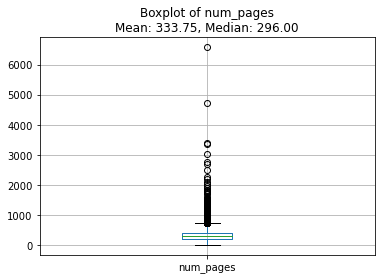

In [377]:
# Compute the mean and median values for the 'num_pages' column
mean_value = df['num_pages'].mean()
median_value = df['num_pages'].median()

# Plot a boxplot for the 'num_pages' column
ax = df.boxplot(column='num_pages')
ax.set_title('Boxplot of num_pages\nMean: {:.2f}, Median: {:.2f}'.format(mean_value, median_value))
plt.show()

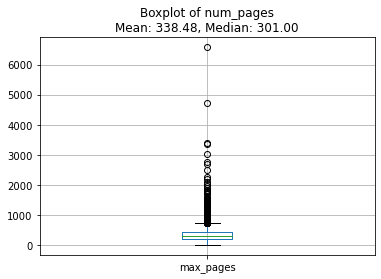

In [378]:
# Compute the mean and median values for the 'max_pages' column
mean_value = df['max_pages'].mean()
median_value = df['max_pages'].median()

# Plot a boxplot for the 'max_pages' column
ay = df.boxplot(column='max_pages')
ay.set_title('Boxplot of num_pages\nMean: {:.2f}, Median: {:.2f}'.format(mean_value, median_value))
plt.show()

In [379]:
# Define the bin ranges for the categories
bins = [0, 50, 200, 400, 1000, float('inf')]

# Define the labels for the categories
labels = ['very low', 'low', 'medium', 'high', 'very high']

# Use the cut() function to convert the numerical values into categories
df['num_pages_cat'] = pd.cut(df['num_pages'], bins=bins, labels=labels)
df['max_pages_cat'] = pd.cut(df['max_pages'], bins=bins, labels=labels)

In [380]:
# from categorical categories to numerical categories
# Use same function to map the values (set_value)
 
# Create the dictionary that assigns a number to each category
numpagcat_dictionary ={'very low' : 1, 'low' : 2, 'medium' : 3, 'high' : 4, 'very high' : 5}
 
# Add a new column named 'num_pages_cat_T'
df['num_pages_cat_T'] = df['num_pages_cat'].apply(set_value, args =(numpagcat_dictionary, ))

In [381]:
# from categorical categories to numerical categories
# Use same function to map the values (set_value)
 
# Create the dictionary that assigns a number to each category
maxpagcat_dictionary ={'very low' : 1, 'low' : 2, 'medium' : 3, 'high' : 4, 'very high' : 5}
 
# Add a new column named 'max_pages_cat_T'
df['max_pages_cat_T'] = df['max_pages_cat'].apply(set_value, args =(maxpagcat_dictionary, ))

In [382]:
df.isna().sum()

bookid                            0
title                             0
authors                           0
average_rating                    0
isbn                              0
isbn13                            0
language_code                     0
num_pages                         0
ratings_count                     0
text_reviews_count                0
publication_date                  0
publisher                         0
title2                            0
author2                           0
genre                             0
multiple_authors                  0
n_authors                         0
authors_list                      0
main_author                       0
ratings_count_updt                0
text_reviews_count_updt           0
max_pages                         0
total_reviews                     0
avg_numpages_author               0
n_pages_vs_avg_auth               0
avg_numpages_publisher            0
n_pages_vs_avg_pub                0
avg_rating_author           

In [383]:
df[df['num_pages_cat'].isna()] # the NA are when num_page = 0 (problem solved before for max_pages)

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth,avg_numpages_publisher,n_pages_vs_avg_pub,avg_rating_author,rating_vs_avg_auth,avg_rating_publisher,rating_vs_avg_pub,rating_vs_avg,rating_vs_mode,pub_month,pub_year,pub_month_text,season,season_num,century,language_code_ENgroup,log_ratings_count,ratings_count_category,ratings_count_category_T,log_text_reviews_count_updt,text_reviews_count_category,text_reviews_count_category_T,log_total_reviews,total_reviews_category,total_reviews_category_T,main_author_T,publisher_T,language_code_T,language_code_ENgroup_T,genre_T,num_pages_cat,max_pages_cat,num_pages_cat_T,max_pages_cat_T
8953,34706,13th directorate,barry chubin,2.62,0804104557,9780804104555,eng,0,8,1,1989-02-28,ivy books,the 13th directorate,barry chubin,not specified,0,1,[barry chubin],barry chubin,8,1,264,9,264.00,1.00,331.00,0.80,2.62,1.00,3.72,0.70,0.666162,0.6550,2,1989,february,winter,1,19,eng,0.908485,very low,1,0.041393,very low,1,0.959041,very low,1,77953,85693,94507,698,12275,NaN,medium,NaN,3
4525,16313,a caribbean mystery,agatha christie/rosalind ayres,3.80,1572705493,9781572705494,eng,0,49,10,2006-10-09,audiogo,a caribbean mystery,agatha christie,religious-philosophical,1,2,"[agatha christie, rosalind ayres]",agatha christie,49,10,256,59,282.59,0.91,211.89,1.21,3.95,0.96,3.98,0.96,0.966189,0.9500,10,2006,october,autumn,4,20,eng,1.691081,low,2,1.004321,low,2,1.771587,low,2,38672,77402,94507,698,32821,NaN,medium,NaN,3
3730,13504,a clash of kings (a song of ice and fire #2),george r.r. martin/roy dotrice,4.41,073930870X,9780739308707,eng,0,113,12,2004-02-17,random house audio,"a clash of kings (martin, george r. r. song of...",george r. r. martin,fantasy,1,2,"[george r.r. martin, roy dotrice]",george r.r. martin,113,12,439,125,527.60,0.83,192.50,2.28,4.09,1.08,4.03,1.09,1.121288,1.1025,2,2004,february,winter,1,20,eng,2.053463,medium,3,1.082785,low,2,2.097257,medium,3,88411,45691,94507,698,75771,NaN,high,NaN,4
7611,29257,a spiritual journey,ram dass/richard alpert,4.16,1593976720,9781593976729,en-us,0,68,4,2005-08-01,macmillan audio,a spiritual journey,ram dass.,religious-philosophical,1,2,"[ram dass, richard alpert]",ram dass,68,4,204,72,280.50,0.73,106.70,1.91,4.18,0.99,3.90,1.07,1.057723,1.0400,8,2005,august,summer,3,20,eng,1.833147,low,2,0.612784,very low,1,1.857935,low,2,60750,37333,15702,698,32821,NaN,medium,NaN,3
2105,7598,a study guide to gabriel garcia marquez' one h...,gabriel garcía márquez/brenda k. marshall/f. m...,4.11,1570421129,9781570421129,eng,0,75,2,2006-04-01,warner adult,a study guide to gabriel garcia marquez' one h...,f. murray abraham,social-political,1,3,"[gabriel garcía márquez, brenda k. marshall, f...",gabriel garcía márquez,75,2,230,77,247.81,0.93,230.00,1.00,3.90,1.05,4.11,1.00,1.045010,1.0275,4,2006,april,spring,2,20,eng,1.875640,low,2,0.322219,very low,1,1.887054,low,2,81078,95119,94507,698,65040,NaN,medium,NaN,3
2676,9832,blind willow sleeping woman: 24 stories,haruki murakami/ellen archer/patrick lawlor,3.84,1400102952,9781400102952,eng,0,28,3,2006-10-15,tantor media,"blind willow, sleeping woman",haruki murakami,fiction,1,3,"[haruki murakami, ellen archer, patrick lawlor]",haruki murakami,28,3,297,31,321.06,0.93,253.00,1.17,3.94,0.97,3.83,1.00,0.976360,0.9600,10,2006,october,autumn,4,20,eng,1.448706,low,2,0.491362,very low,1,1.492760,low,2,27716,56326,94507,698,59124,NaN,medium,NaN,3
4368,15691,caligula and three other plays,albert camus,4.04,039440520X,9780394405209,fre,0,17,3,1966-05-01,knopf,"caligula, and three other plays",albert camus,drama,0,1,[albert camus],albert camus,17,3,236,20,278.52,0.85,276.77,0.85,4.04,1.00,3.95,1.02,1.027212,1.0100,5,1966,may,spring,2,19,fre,1.232996,low,2,0.491362,very low,1,1.303196,low,2,

In [384]:
df['num_pages_cat'] = df['num_pages_cat'].fillna('very low')
df['num_pages_cat_T'] = df['num_pages_cat_T'].fillna(1)

In [385]:
df.isna().sum()

bookid                           0
title                            0
authors                          0
average_rating                   0
isbn                             0
isbn13                           0
language_code                    0
num_pages                        0
ratings_count                    0
text_reviews_count               0
publication_date                 0
publisher                        0
title2                           0
author2                          0
genre                            0
multiple_authors                 0
n_authors                        0
authors_list                     0
main_author                      0
ratings_count_updt               0
text_reviews_count_updt          0
max_pages                        0
total_reviews                    0
avg_numpages_author              0
n_pages_vs_avg_auth              0
avg_numpages_publisher           0
n_pages_vs_avg_pub               0
avg_rating_author                0
rating_vs_avg_auth  

In [386]:
df['num_pages_cat'].value_counts()

medium       4865
high         2504
low          2232
very low      494
very high     189
Name: num_pages_cat, dtype: int64

In [387]:
df['max_pages_cat'].value_counts() 
# the categories for max_pae are slightly better distributed than those of num_pages because num_pages=0 have been previously filled with more plausible values

medium       4897
high         2556
low          2221
very low      417
very high     193
Name: max_pages_cat, dtype: int64

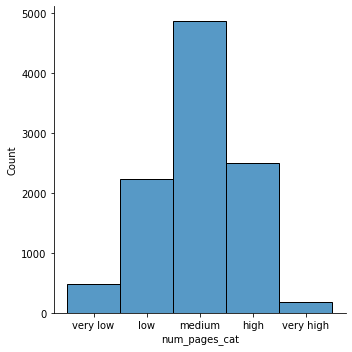

In [388]:
sns.displot(df.num_pages_cat)

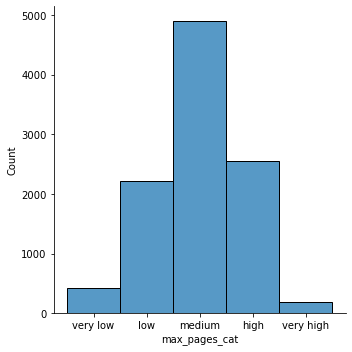

In [389]:
sns.displot(df.max_pages_cat)

In [390]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10284 entries, 1847 to 4261
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   bookid                         10284 non-null  int64         
 1   title                          10284 non-null  object        
 2   authors                        10284 non-null  object        
 3   average_rating                 10284 non-null  float64       
 4   isbn                           10284 non-null  object        
 5   isbn13                         10284 non-null  int64         
 6   language_code                  10284 non-null  object        
 7   num_pages                      10284 non-null  int64         
 8   ratings_count                  10284 non-null  int64         
 9   text_reviews_count             10284 non-null  int64         
 10  publication_date               10284 non-null  datetime64[ns]
 11  publisher    

In [391]:
df.shape

(10284, 58)

###### Trasform rating 
- Transform rating into category (bad, medium, good) -> log function (important data : 91% of data between 3,5 and 4,4, lloks like a normal law)

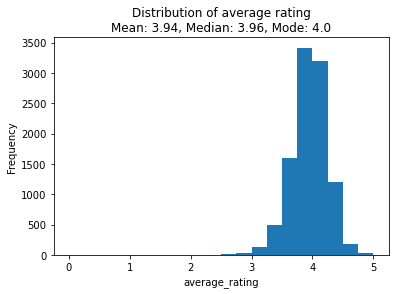

In [392]:
# Plot the distribution of the 'rating' column using a log function
mean_value = df['average_rating'].mean()
median_value = df['average_rating'].median()
mode_value = df['average_rating'].mode()
plt.hist((df['average_rating']), bins=20)
plt.xlabel('average_rating')
plt.ylabel('Frequency')
plt.title('Distribution of average rating\nMean: {:.2f}, Median: {:.2f}, Mode: 4.0'.format(mean_value, median_value))

plt.show()
# mean < median < mode Left Skewed Distribution

In [393]:
# Define the bin ranges for the categories
bins = [0, 1.5, 2.5, 3.5, 4.5, 5]

# Define the labels for the categories
labels = ['very bad','bad', 'medium', 'good', 'very good']

#I would like 'very good' to be just for df['average_rating']==5 and very bad df['average_rating']==0 and the rest equally distributed

# Use the cut() function to convert the numerical values into categories
df['average_rating_cat'] = pd.cut(df['average_rating'], bins=bins, labels=labels)

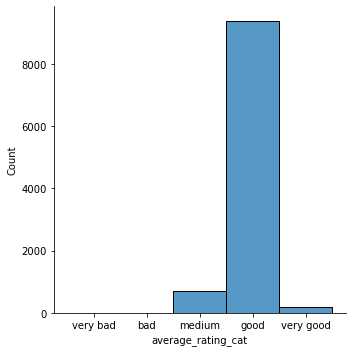

In [394]:
sns.displot(df.average_rating_cat)

In [395]:
# from categorical categories to numerical categories
# Use same function to map the values (set_value)
 
# Create the dictionary that assigns a number to each category
ratingscat_dictionary ={'very bad' : 1, 'bad' : 2, 'medium' : 3, 'good' : 4, 'very good' : 5}
 
# Add a new column named 'average_rating_cat_T'
df['average_rating_cat_T'] = df['average_rating_cat'].apply(set_value, args =(ratingscat_dictionary, ))

In [396]:
df.isna().sum()

bookid                           0
title                            0
authors                          0
average_rating                   0
isbn                             0
isbn13                           0
language_code                    0
num_pages                        0
ratings_count                    0
text_reviews_count               0
publication_date                 0
publisher                        0
title2                           0
author2                          0
genre                            0
multiple_authors                 0
n_authors                        0
authors_list                     0
main_author                      0
ratings_count_updt               0
text_reviews_count_updt          0
max_pages                        0
total_reviews                    0
avg_numpages_author              0
n_pages_vs_avg_auth              0
avg_numpages_publisher           0
n_pages_vs_avg_pub               0
avg_rating_author                0
rating_vs_avg_auth  

In [397]:
df[df['average_rating_cat'].isna()] 
# the NA is in a raw with average rating = 0, ratings count=0 and text reviews = 1 we can drop it since it doesn't seem to be very meaningful

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,title2,author2,genre,multiple_authors,n_authors,authors_list,main_author,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth,avg_numpages_publisher,n_pages_vs_avg_pub,avg_rating_author,rating_vs_avg_auth,avg_rating_publisher,rating_vs_avg_pub,rating_vs_avg,rating_vs_mode,pub_month,pub_year,pub_month_text,season,season_num,century,language_code_ENgroup,log_ratings_count,ratings_count_category,ratings_count_category_T,log_text_reviews_count_updt,text_reviews_count_category,text_reviews_count_category_T,log_total_reviews,total_reviews_category,total_reviews_category_T,main_author_T,publisher_T,language_code_T,language_code_ENgroup_T,genre_T,num_pages_cat,max_pages_cat,num_pages_cat_T,max_pages_cat_T,average_rating_cat,average_rating_cat_T
10138,41044,day and night,better homes and gardens,0.0,0696018829,9780696018824,eng,32,0,1,1989-03-01,meredith corporation,day and night.,better homes and gardens,art,0,1,[better homes and gardens],better homes and gardens,0,1,32,1,32.0,1.0,32.0,1.0,0.0,NaN,0.0,NaN,0.0,0.0,3,1989,march,spring,2,19,eng,-1.0,very low,1,0.041393,very low,1,0.041393,very low,1,25844,64117,94507,698,64307,very low,very low,1,1,NaN,NaN


In [398]:
df = df.dropna(subset=['average_rating_cat'])

In [399]:
df.isna().sum()

bookid                           0
title                            0
authors                          0
average_rating                   0
isbn                             0
isbn13                           0
language_code                    0
num_pages                        0
ratings_count                    0
text_reviews_count               0
publication_date                 0
publisher                        0
title2                           0
author2                          0
genre                            0
multiple_authors                 0
n_authors                        0
authors_list                     0
main_author                      0
ratings_count_updt               0
text_reviews_count_updt          0
max_pages                        0
total_reviews                    0
avg_numpages_author              0
n_pages_vs_avg_auth              0
avg_numpages_publisher           0
n_pages_vs_avg_pub               0
avg_rating_author                0
rating_vs_avg_auth  

In [400]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10283 entries, 1847 to 4261
Data columns (total 60 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   bookid                         10283 non-null  int64         
 1   title                          10283 non-null  object        
 2   authors                        10283 non-null  object        
 3   average_rating                 10283 non-null  float64       
 4   isbn                           10283 non-null  object        
 5   isbn13                         10283 non-null  int64         
 6   language_code                  10283 non-null  object        
 7   num_pages                      10283 non-null  int64         
 8   ratings_count                  10283 non-null  int64         
 9   text_reviews_count             10283 non-null  int64         
 10  publication_date               10283 non-null  datetime64[ns]
 11  publisher    

In [401]:
df.shape

(10283, 60)

# Dataset Analysis after cleaning and transforming
- description of the columns
- get rid of meaningless col
- divide into numerical and categorical var
- change order of columns
- plots
- correlation
- feature selection

- title: title of the book (in the starting dataset a title could appear more than once while now title is unique).
- authors: string containing all the authors of the book. It has been used to extract just the first author for each book and to count how many authors have written a book and to see whether or not the book has multiple authors or not.
- average_rating: average rating for each book. Some rows presented falsed values and have been dropped in the cleaning and transformation stage.
- isbn: identifier for the book.
- isbn13: identifier for the book.
- language_code: string that tell the language used to write the book.
- num_pages: count of the number of pages of each book. Many rows presented falsed values (num_pages=0), the problem was solved with the creation of 'max_pages' and with additional steps in the cleaning and transformation stage.
- ratings_count: count of the number of ratings given to each book. Some rows presented falsed values and have been dropped in the cleaning and transformation stage.
- text_reviews_count: count of the number of text reviews given to each book. Some rows presented falsed values and have been dropped in the cleaning and transformation stage.
- publication_date: date of the publication of the book. When dropping the duplicates of the 'title' column, the less recent date was kept.
- publisher: string containing the publisher of the book.
- title2: title of the book. This column comes from the additional dataset that has been joined to the original one. It can be used for comparisons.
- author2: author of the book. This column comes from the additional dataset that has been joined to the original one. It can be used for comparisons.
- genre: genre of the book. This column has been created from 'Subject_list', a column of the additional dataset that has been joined to the original one. It was a list containing the subjects and topics dealt in the book. It had too many unique values to be helpful as it was, for this reason it has been used to identify the genres using some key words.
- multiple_authors: binary variable that takes 0 for rows with just one author in 'authors' and 1 otherwise.
- n_authors: count of the number of authors in 'authors'.
- authors_list: list of the authors in 'authors' used to extract 'main_author'.
- main_author: first author of the book extracted from 'authors_list'
- ratings_count_updt: sum of the number of ratings for each book with the same title.
- text_reviews_count_updt: sum of the number of text reviews for each book with the same title.
- max_pages: highest value of number of pages (num_pages) considering each book with the same title:
- total_reviews: sum of ratings_count_updt and text_reviews_count_updt.
- avg_numpages_author: average number of pages computed per each author (main_author).
- n_pages_vs_avg_auth: rate that compares the number of pages of a book (max_page) with the average number of pages of the author of the book.
- avg_numpages_publisher: average number of pages computed per each publisher.
- n_pages_vs_avg_pub: rate that compares the number of pages of a book (max_page) with the average number of pages of the publisher of the book.
- avg_rating_author: average of the ratings (avg('average_rating')) per each author (main_author).
- rating_vs_avg_auth: rate that compares the rating of a book ('average_rating') with the average rating value per each author.
- avg_rating_publishers: average rating value (avg('average_rating')) per each publisher.
- rating_vs_avg_pub: rate that compares the rating of a book ('average_rating') with the average rating value per each publisher.
- rating_vs_avg: rate that compares the rating of a book ('average_rating') with the average rating value.
- rating_vs_mode: rate that compares the rating of a book ('average_rating') with the most frequent rating value.
- pub_month: month of publication of the book extracted from the 'publication_date'. It has been used to identify the season in which the book was published.
- pub_month_text: transformation into text of the publication month 'pub_month'.
- pub_year: year of publication of the book extracted from the 'publication_date'. It has been used to identify the century in which the book was published.
- season: season in which the book was published, extracted from the 'pub_month'. It can been used to identify common temporal patterns.
- season_num: numerical transformation of 'season'. Winter=1, Spring=2, Summer=3, Autumn=4.
- century: century in which the book was published, extracted from the 'pub_year'. It can been used to identify common temporal patterns.
- language_code_ENgroup: string that tell the language used to write the book, where all english languages have been grouped together (American English + British English).
- log_ratings_count: logarithmic transformation of 'ratings_count_updt' used to better define ratings count categories.
- ratings_count_category: column that assigns a category depending on the size of 'log_ratings_count_updt'. Categories go from 'very low' to 'very high'.
- ratings_count_category_T: numerical transformation of 'ratings_count_category'.
- log_text_reviews_count_updt: logarithmic transformation of 'ratings_count_updt' used to better define ratings count categories.
- text_reviews_count_category: column that assigns a category depending on the size of 'log_text_reviews_count_updt'. Categories go from 'very low' to 'very high'.
- text_reviews_count_category_T: numerical transformation of 'text_reviews_count_category'.
- log_total_reviews: logarithmic transformation of 'ratings_count_updt' used to better define ratings count categories.
- total_reviews_category: column that assigns a category depending on the size of 'log_total_reviews'. Categories go from 'very low' to 'very high'.
- total_reviews_category_T: numerical transformation of 'total_reviews_category'.
- main_author_T: numerical transformation of 'main_author' assigning random integers to avoid creating ordinal relationships.
- publisher_T: numerical transformation of 'publisher' assigning random integers to avoid creating ordinal relationships.
- language_code_T: numerical transformation of 'language_code' assigning random integers to avoid creating ordinal relationships.
- language_code_ENgroup_T: numerical transformation of 'language_code_ENgroup' assigning random integers to avoid creating ordinal relationships.
- genre_T: numerical transformation of 'genre' assigning random integers to avoid creating ordinal relationships.
- num_pages_cat: column that assigns a category depending on the number of pages ('num_pages'). 
- max_pages_cat: column that assigns a category depending on the number of pages ('max_pages'). 
- num_pages_cat_T: numerical transformation of 'num_pages_cat'.
- max_pages_cat_T: numerical transformation of 'max_pages_cat'.
- average_rating_cat: column that assigns a category depending on the ratings value ('average_rating').
- average_rating_cat_T: numerical transformation of 'average_rating_cat'.



The dataframe 'df' contains information about books, such as their titles, authors, ratings, number of pages, publication dates, publishers, and genres. We have have also performed some transformations and created additional columns to ease the analysis of the data, such as grouping books by their titles and authors, computing rates and averages for ratings and number of pages, and categorizing ratings and text reviews based on their counts.

The 'genre' column in particular seems interesting as it was created by extracting subjects and topics dealt in the book and using them to identify the genres using some key words. This could help grouping and comparing books based on their genres and see which genres are most popular and successful.

Additionally, the 'season' and 'century' columns could also provide valuable insights into temporal patterns in book publishing and help identifying which periods and seasons are most popular for book releases. The 'language_code_ENgroup' column could also be useful to see which English-speaking countries are most active in publishing books.

Overall, it seems we obtained a well-prepared dataframe with 10283 observations and 60 columns with no missing values. The dataframe contains a lot of useful information about books and can be used to analyze various aspects of the book industry such as the prediction of book ratings.

In [402]:
numerical = df.select_dtypes(include=['int64', 'float64', 'datetime64']).columns
categorical = df.select_dtypes(include=['object', 'category']).columns

In [403]:
categorical

Index(['title', 'authors', 'isbn', 'language_code', 'publisher', 'title2', 'author2', 'genre', 'authors_list', 'main_author', 'pub_month_text', 'season', 'language_code_ENgroup', 'ratings_count_category', 'ratings_count_category_T', 'text_reviews_count_category', 'text_reviews_count_category_T', 'total_reviews_category', 'total_reviews_category_T', 'num_pages_cat', 'max_pages_cat', 'num_pages_cat_T', 'max_pages_cat_T', 'average_rating_cat', 'average_rating_cat_T'], dtype='object')

In [404]:
numerical

Index(['bookid', 'average_rating', 'isbn13', 'num_pages', 'ratings_count', 'text_reviews_count', 'publication_date', 'n_authors', 'ratings_count_updt', 'text_reviews_count_updt', 'max_pages', 'total_reviews', 'avg_numpages_author', 'n_pages_vs_avg_auth', 'avg_numpages_publisher', 'n_pages_vs_avg_pub', 'avg_rating_author', 'rating_vs_avg_auth', 'avg_rating_publisher', 'rating_vs_avg_pub', 'rating_vs_avg', 'rating_vs_mode', 'pub_month', 'pub_year', 'season_num', 'century', 'log_ratings_count', 'log_text_reviews_count_updt', 'log_total_reviews', 'main_author_T', 'publisher_T', 'language_code_T', 'language_code_ENgroup_T', 'genre_T'], dtype='object')

In [405]:
# describe dataset

In [406]:
# show Dataframe size (rows, columns)
df.shape  

# Originally we had 11123 records with 16 columns, now we have 10283 observation with 60 columns

(10283, 60)

In [407]:
df.isna().sum()
# no missing values

bookid                           0
title                            0
authors                          0
average_rating                   0
isbn                             0
isbn13                           0
language_code                    0
num_pages                        0
ratings_count                    0
text_reviews_count               0
publication_date                 0
publisher                        0
title2                           0
author2                          0
genre                            0
multiple_authors                 0
n_authors                        0
authors_list                     0
main_author                      0
ratings_count_updt               0
text_reviews_count_updt          0
max_pages                        0
total_reviews                    0
avg_numpages_author              0
n_pages_vs_avg_auth              0
avg_numpages_publisher           0
n_pages_vs_avg_pub               0
avg_rating_author                0
rating_vs_avg_auth  

In [408]:
# describing columns with categorical values (not considering title since it is just identifier)
# list of column names to exclude

df[categorical].describe().round(2)

# Title
# We observed some redundancy in titles (10311 unique) (10066 for title2), now we have 10283 unique titles without duplicates.

# Author
# We observed some redundancy in authors (6639 unique) (4356 for author2), Stephen King had the most works (40)
# Now we have 6252 unique authors if we consider column 'authors' and 4164 if we consider 'main_author'. 
# The author with more books in the dataset is Stephen King with 62 books.

# Language
# We observed 27 unique languages, with eng books dominating the dataset (8908), now we have an additional column where languages connected to English have been grouped, now english is the language of 9736 books.

# Publisher
# There were 2262 unique publishers with vintage being the most common (318 works), now vintage is still the most frequent with 293 observations. 

# Genre
# We had 31 unique genres among which novel-narrative was the most popular, this information did not change.

# Publication date
# season: most frequent season is autumn with 3105 observations, considering we have 10283 observations in total it seems that all seasons appear with a similar frequence.
# pub_month_text: most frequent month is september with a frequence of 1198.

# Ratings and reviews count
# Most books (3002) has a rating count belonging to the 'medium high' category, while for the text_reviews the more frequent category (4448) is 'low'.
# If we consider the total number of reviews the most popular category is 'medium high' with 3046 observations.

# Number of pages
# The difference between num_pages and max_pages is very low for both the most frequent category is 'medium' with 4865 and 4897 observations respectively.
# With 9384 observations, 'good' is the rating category appearing more frequently in the dataset.



,title,authors,isbn,language_code,publisher,title2,author2,genre,authors_list,main_author,pub_month_text,season,language_code_ENgroup,ratings_count_category,ratings_count_category_T,text_reviews_count_category,text_reviews_count_category_T,total_reviews_category,total_reviews_category_T,num_pages_cat,max_pages_cat,num_pages_cat_T,max_pages_cat_T,average_rating_cat,average_rating_cat_T
count,10283,10283,10283,10283,10283,10283,10283,10283,10283,10283,10283,10283,10283,10283,10283,10283,10283,10283,10283,10283,10283,10283,10283,10283,10283
unique,10283,6252,10283,25,2169,9800,4293,31,6252,4168,12,4,22,6,6,5,5,6,6,5,5,5,5,5,5
top,said the shotgun to the head.,p.g. wodehouse,0743470796,eng,vintage,bleach.,stephen king,novel-narrative,[p.g. wodehouse],stephen king,september,autumn,eng,medium high,4,low,2,medium high,4,medium,medium,3,3,good,4
freq,1,39,1,8216,293,10,68,2295,39,62,1198,3105,9736,3002,3002,4448,4448,3046,3046,4865,4897,4865,4897,9384,9384


In [409]:
# describing columns with numerical values (not considering bookid, isbn, isbn13 since they are just identifiers)
df[numerical].describe().round(2)

# Before looking at the min row there were many variables with value=0 now just a few columns have min=0

# Rating (average_rating)
# average_rating: mean was 3.93, 25% was 3.77, median was 3.96, 75% was 4.14. Ratings were mostly high and spread was small (std : 0.35). Skewness seemed low.
# Now mean is 3.94, 25% is below 3.77, 50% is below 3.96, 75% is below 4.14. Ratings are mostly high and spread is quite small (std : 0.30, less than at the beginning). Skewness seems low.

# Number of Pages (num_page & max_page)
# num_pages mean was 336 vs median 299, exhibited some skewness because of outliers (top 6576), min was 0.
# Now num_pages mean is 333 vs median 296, exhibits some skewness because of outliers (top 6576).
# If we consider max_pages mean is 338 vs median 301, skewness because of outliers (top 6576), any 0 values.

# Ratings count (ratings_count, ratings_count_updt, text_reviews_count, text_reviews_count_updt, total_reviews)
# ratings_count mean was 179942 vs median 745, exhibiting strong skewness as top value is > 4597666
# Now considering ratings_count_updt mean is 19408 vs median 885, there is strong skewness as top value is 4597666 same holds for text_reviews_count_updt and total_reviews.

# Rates and averages for ratings and number of pages 
# avg_numpages_author: the mean value is 338 which seems quite reasonable considering we are computing the average n. pages by author, but the min is 1 and max is 2912 which means that there could be some outliers.
# n_pages_vs_avg_auth: it is a rate, it has mean value 1 which means that on average the number of pages of the book corresponds to the average n. pages by author, max value is 8.09 which is probably an outlier
# avg_numpages_publisher: the mean is 338 i.e. very close to average computed by author, but the min is 1 and max is 2751 which means that there could be some outliers.
# n_pages_vs_avg_pub: the rate has value in the standard except for max which is 13.49 that it too high to be a rate
# avg_rating_author: average rating by author has a mean of 3.94 with a low standard deviation (0.26) and ranges between 1 and 5.
# rating_vs_avg_auth: the values of this rate don't point to outliers or strange values. Min value is 0.34 and max is 2. 
    # This means that there is at least 1 book that has a significant lower rating with respect to the average rating of the author of the book and there is at least 1 book with a rating significantly higher than the average of its author.
# avg_rating_publisher: very similar to avg_rating_author, sd is even lower (0.19<0.26).
# rating_vs_avg_pub: the values of this rate don't point to outliers or strange values. Min value is 0.49 and max is 2. 
    # This means that there is at least 1 book that has a significant lower rating with respect to the average rating of the publisher of the book and there is at least 1 book with a rating significantly higher than the average of its publisher.
# rating_vs_avg: this rate has less strange values than the other rates since it is computed on the whole dataset without grouping by author or publisher. Min is 0.25 and max is 1.27. Mean is 1 which means that on average the ratings are very close to the mean rating given.
# rating_vs_mode: this rate used as denominator the most frequent rating of the dataset, the mean is 0.99 i.e., on average rating correspond almost perfectly to the rating observed more times in the dataset.

# Info on publication date
# pub_month: publication month, from the numeric variable we don't get any useful insight, for this reason we had created 'pub_month_text'.
# pub_year: our dataset has book that have been publicated between 1900 and 2020 (minimum value is 1900 and the max is 2020). 
# season_num: from the numeric variable we don't get any useful insight, for this reason we had created 'season'.
# century: either 19th century or 20th century seems to be not so interesting.

,bookid,average_rating,isbn13,num_pages,ratings_count,text_reviews_count,n_authors,ratings_count_updt,text_reviews_count_updt,max_pages,total_reviews,avg_numpages_author,n_pages_vs_avg_auth,avg_numpages_publisher,n_pages_vs_avg_pub,avg_rating_author,rating_vs_avg_auth,avg_rating_publisher,rating_vs_avg_pub,rating_vs_avg,rating_vs_mode,pub_month,pub_year,season_num,century,log_ratings_count,log_text_reviews_count_updt,log_total_reviews,main_author_T,publisher_T,language_code_T,language_code_ENgroup_T,genre_T
count,10283.00,10283.00,1.028300e+04,10283.00,10283.00,10283.00,10283.00,10283.00,10283.00,10283.00,10283.00,10283.00,10283.00,10283.00,10283.00,10283.00,10283.00,10283.00,10283.00,10283.00,10283.00,10283.00,10283.00,10283.00,10283.00,10283.00,10283.00,10283.00,10283.00,10283.00,10283.00,10283.00,10283.0
mean,21608.72,3.94,9.758162e+12,333.78,15156.05,481.65,1.71,19408.57,586.33,338.51,19994.89,338.49,1.00,338.36,1.00,3.94,1.00,3.94,1.00,1.00,0.99,6.56,1999.97,2.60,19.68,2.91,1.66,2.94,49322.72,48326.16,80762.23,3210.65,56536.3
std,13059.74,0.30,4.606728e+11,239.17,98853.35,2367.29,1.84,117391.98,2697.72,239.36,119737.90,172.90,0.40,148.38,0.53,0.26,0.05,0.19,0.06,0.08,0.08,3.41,8.38,1.14,0.47,1.21,1.12,1.20,29063.56,28504.27,28574.79,13990.87,28991.5
min,2.00,1.00,8.987060e+09,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.34,1.00,0.49,0.25,0.25,1.00,1900.00,1.00,19.00,-1.00,-1.00,-1.00,3.00,39.00,5330.00,698.00,8828.0
25%,10667.50,3.77,9.780345e+12,193.00,104.00,9.00,1.00,114.00,9.00,198.50,126.00,228.50,0.86,250.40,0.73,3.80,0.99,3.87,0.97,0.96,0.94,4.00,1998.00,2.00,19.00,2.06,0.96,2.10,24208.00,24738.50,94507.00,698.00,33314.0
50%,21119.00,3.96,9.780590e+12,296.00,762.00,46.00,1.00,885.00,52.00,301.00,946.00,321.00,1.00,353.11,0.99,3.95,1.00,3.92,1.00,1.01,0.99,7.00,2002.00,3.00,20.00,2.95,1.72,2.98,49364.00,44960.00,94507.00,698.00,59124.0
75%,32302.50,4.14,9.780872e+12,411.00,4910.50,229.50,2.00,5861.50,267.00,416.00,6146.00,413.50,1.07,397.73,1.14,4.09,1.02,4.02,1.04,1.05,1.03,10.00,2005.00,4.00,20.00,3.77,2.43,3.79,74587.00,72783.00,94507.00,698.00,90533.0
max,45641.00,5.00,9.790008e+12,6576.00,4597666.00,94265.00,51.00,4597666.00,94265.00,6576.00,4691931.00,2912.00,8.09,2751.00,13.49,5.00,2.00,5.00,2.00,1.27,1.25,12.00,2020.00,4.00,20.00,6.66,4.97,6.67,99995.00,99999.00,94507.00,99764.00,95008.0


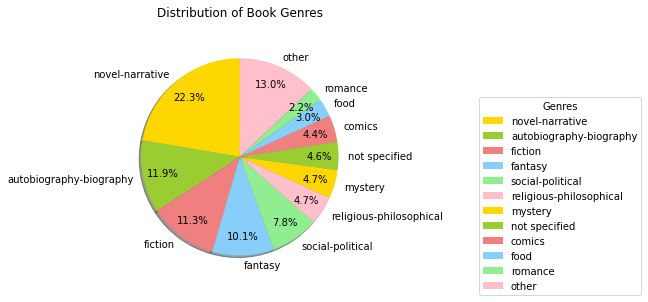

In [410]:
# Calculate the total number of books
total_books = df['genre'].count()

# Count the number of books in each genre
genre_counts = df['genre'].value_counts()

# Calculate the percentage of books in each genre
genre_percentages = genre_counts/total_books

# Group all genres that have less than 2% into a single slice called 'other'
other_genre_percentage = 0.0
for genre, percentage in genre_percentages.items():
    if percentage < 0.02:
        other_genre_percentage += percentage
        genre_counts = genre_counts.drop(genre)
genre_counts['other'] = round(other_genre_percentage * total_books)

colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink']
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=90, shadow=True, colors=colors_list, pctdistance=0.8, labeldistance=1.1)
plt.title('Distribution of Book Genres', y=1.12)
plt.axis('equal')
plt.legend(title='Genres', bbox_to_anchor=(1.2,0.8))
plt.show()


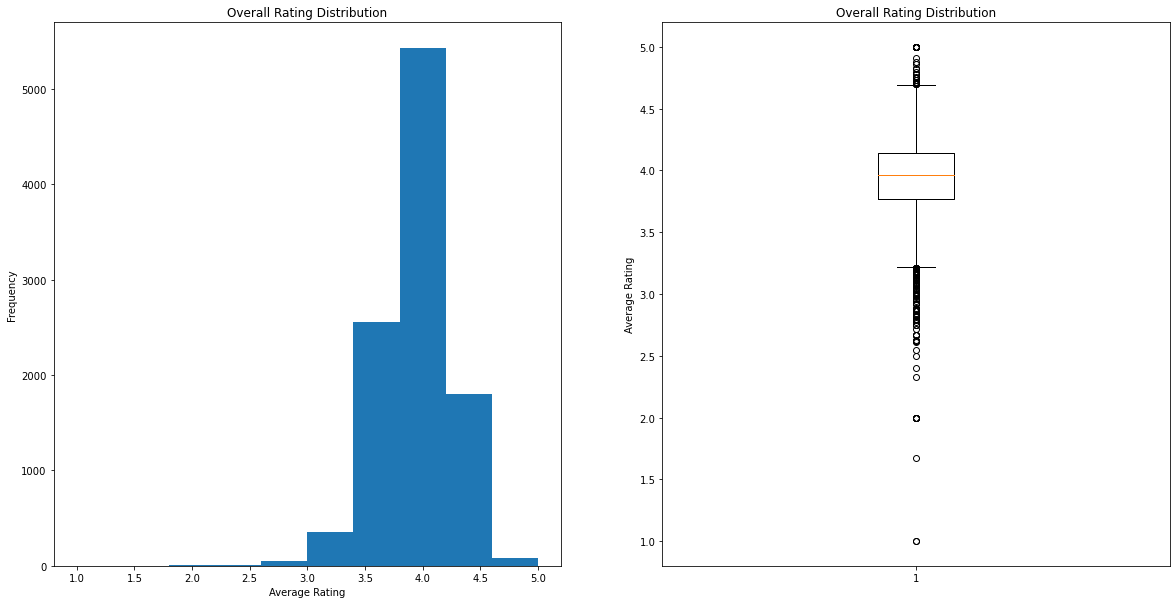

In [411]:
# Set up the plot grid

#convert dataframe to matrix
complete = df[['average_rating','n_authors',  'max_pages', 'total_reviews', 'pub_year', 'season_num', 'century', 
                     'language_code','genre', 'main_author', 'pub_month_text', 'season', 'language_code_ENgroup', 
                     'ratings_count_category', 'text_reviews_count_category',  'total_reviews_category', 'num_pages_cat', 
                     'max_pages_cat', 'average_rating_cat']].to_numpy()


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Plot the histogram on the first subplot
axs[0].hist(complete[:,0], bins=10)
axs[0].set_xlabel('Average Rating')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Overall Rating Distribution')

# Plot the boxplot on the second subplot
axs[1].boxplot(complete[:,0])
axs[1].set_ylabel('Average Rating')
axs[1].set_title('Overall Rating Distribution')

# Display the plot
plt.show()


# It is possible to observe from these graphs how the rating is distributed, namely, the most frequent rating is 4.0. 
# We can better visualize this looking at the corresponding boxplot, from which we can see that half of the ratings lies between 3.8 and 4.1.
# The rating between 0 and 3.3 have been represented in the graph as outliers, as well as ratings greater than 4.7.

#### Correlation

In [412]:
# Using .corr() method to compute the correlation matrix for numerical variables:

pearson_corr_mat = df[numerical].corr(method='pearson')
# Pearson correlation: 
# The Pearson correlation coefficient is a measure of the linear relationship between two continuous variables. 
# It measures the degree to which two variables are related to each other in a straight line. 
# It ranges from -1 to 1, where a value of -1 indicates a perfect negative linear relationship, 0 indicates no linear relationship, and 1 indicates a perfect positive linear relationship.
# Pearson correlation assumes that the data is normally distributed and that the relationship between the two variables is linear.


kendall_corr_mat = df[numerical].corr(method='kendall')
# Kendall correlation: 
# The Kendall correlation coefficient is a measure of the association between two variables that is based on the ranks of the values rather than their specific numerical values. 
# It measures the degree to which the ranks of two variables are related to each other. It ranges from -1 to 1, where a value of -1 indicates a perfect negative association, 0 indicates no association, and 1 indicates a perfect positive association. 
# Kendall correlation does not assume normality of the data and is robust to outliers and non-linear relationships.


spearman_corr_mat = df[numerical].corr(method='spearman') # we will focus on this correlation since we many outliers and non-linear relationships between variables
# Spearman correlation: 
# The Spearman correlation coefficient is also based on the ranks of the values and measures the degree to which the two variables are related to each other. 
# It ranges from -1 to 1, where a value of -1 indicates a perfect negative monotonic relationship, 0 indicates no monotonic relationship, and 1 indicates a perfect positive monotonic relationship. 
# Spearman correlation does not assume normality of the data and is also robust to outliers and non-linear relationships.

<AxesSubplot:>

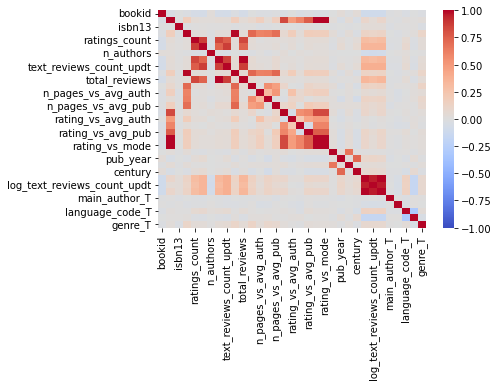

In [413]:
# Plotting the correlation matrix

sns.heatmap(pearson_corr_mat, cmap='coolwarm', annot=False, fmt='.2f', vmin=-1, vmax=1)

# Generating a heatmap plot of the correlation matrix, where each cell represents the correlation coefficient between two variables. The color of the cell indicates the strength of the correlation, with red indicating a positive correlation, blue indicating a negative correlation, and white

<AxesSubplot:>

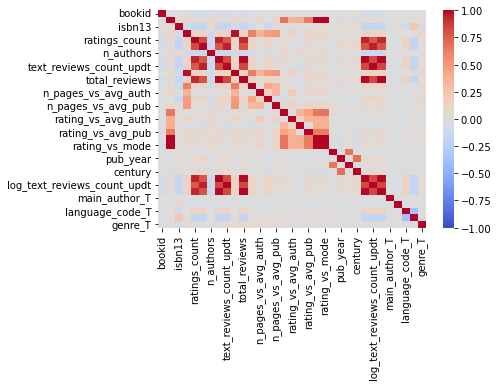

In [414]:
# Plotting the correlation matrix

sns.heatmap(kendall_corr_mat, cmap='coolwarm', annot=False, fmt='.2f', vmin=-1, vmax=1)

# Generating a heatmap plot of the correlation matrix, where each cell represents the correlation coefficient between two variables. The color of the cell indicates the strength of the correlation, with red indicating a positive correlation, blue indicating a negative correlation, and white

<AxesSubplot:>

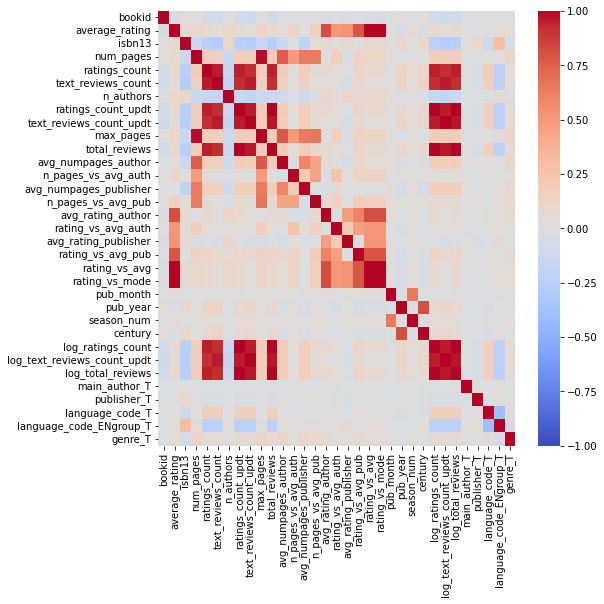

In [415]:
# Plotting the correlation matrix
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(spearman_corr_mat, cmap='coolwarm', annot=False, fmt='.2f', vmin=-1, vmax=1)

# Generating a heatmap plot of the correlation matrix, where each cell represents the correlation coefficient between two variables. The color of the cell indicates the strength of the correlation, with red indicating a positive correlation, blue indicating a negative correlation, and white

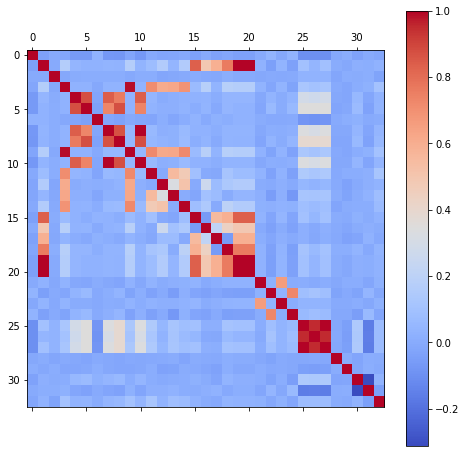

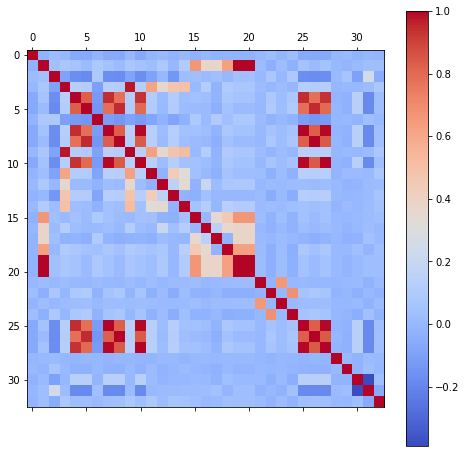

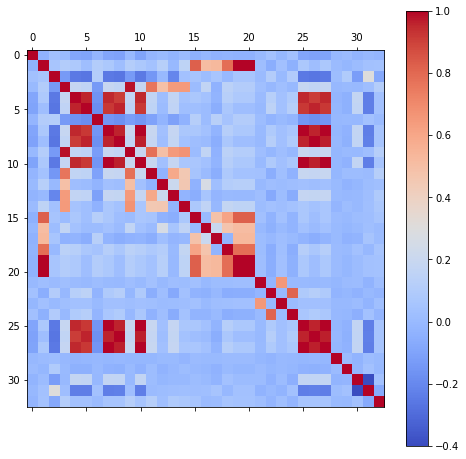

In [416]:
# Trying a different plot for the heatmap
#pearson_corr_mat
#kendall_corr_mat 
#spearman_corr_mat 

fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.matshow(pearson_corr_mat, cmap='coolwarm')
fig.colorbar(cax)

fig2, ax2 = plt.subplots(figsize=(8, 8))
cax2 = ax2.matshow(kendall_corr_mat, cmap='coolwarm')
fig2.colorbar(cax2)

fig3, ax3 = plt.subplots(figsize=(8, 8))
cax3 = ax3.matshow(spearman_corr_mat, cmap='coolwarm')
fig3.colorbar(cax3)

plt.show()

In [417]:
# select only columns with absolute correlation greater than 0.8 and setting diagonal values to 0

np.fill_diagonal(pearson_corr_mat.values, 0)
pearson_high_corr_mat = pearson_corr_mat[abs(pearson_corr_mat) > 0.8]

np.fill_diagonal(kendall_corr_mat.values, 0)
kendall_high_corr_mat = kendall_corr_mat[abs(kendall_corr_mat) > 0.8]

np.fill_diagonal(spearman_corr_mat.values, 0)
spearman_high_corr_mat = spearman_corr_mat[abs(spearman_corr_mat) > 0.8]

<AxesSubplot:>

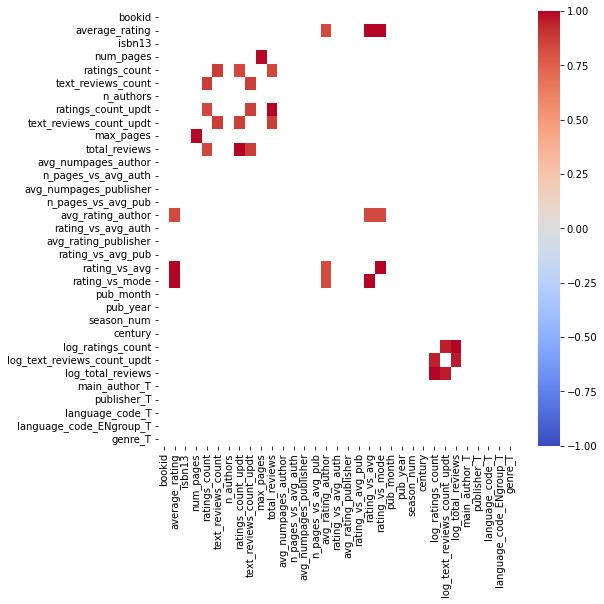

In [418]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(pearson_high_corr_mat, cmap='coolwarm', annot=False, fmt='.2f', vmin=-1, vmax=1)

<AxesSubplot:>

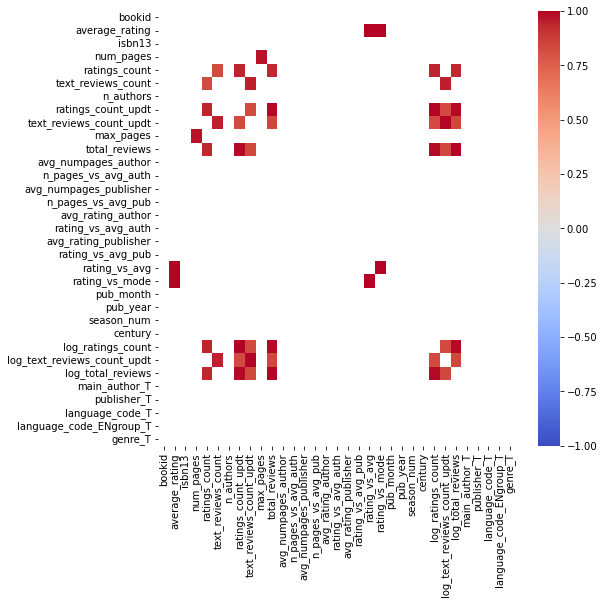

In [419]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(kendall_high_corr_mat, cmap='coolwarm', annot=False, fmt='.2f', vmin=-1, vmax=1)

<AxesSubplot:>

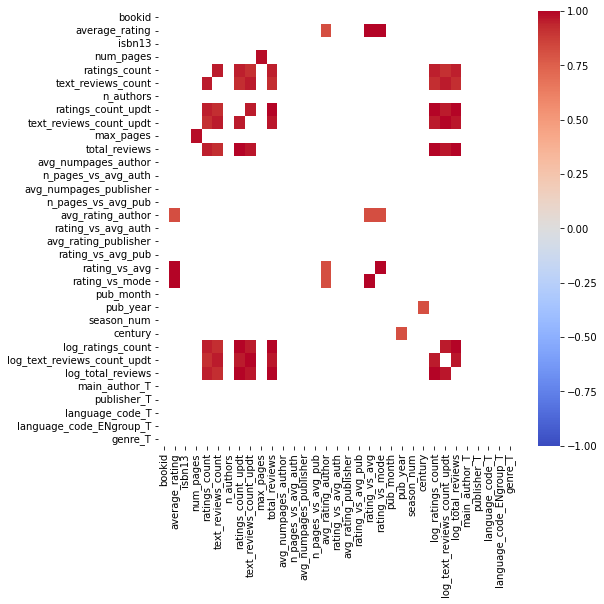

In [420]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(spearman_high_corr_mat, cmap='coolwarm', annot=False, fmt='.2f', vmin=-1, vmax=1)

In [421]:
# get the list of all columns with correlation > 0.8
high_corr_cols = []
corr_thresh = abs(0.8)
# Initialize dictionary to keep track of column counts
col_counts = {}

print("Pairs of columns with correlation > 0.8:")
for col in spearman_corr_mat.columns:
    high_corr = spearman_corr_mat[col][(spearman_corr_mat[col].abs() > corr_thresh) & (spearman_corr_mat.index != col)]
    if not high_corr.empty:
        for high_corr_col, high_corr_val in high_corr.iteritems():
            # Print column pair and correlation value
            print(col, high_corr_col, high_corr_val)
            # Increment counts for both columns
            col_counts[col] = col_counts.get(col, 0) + 1
            col_counts[high_corr_col] = col_counts.get(high_corr_col, 0) + 1

# Print column counts in descending order
print("\nColumn counts:")
for col, count in sorted(col_counts.items(), key=lambda x: x[1], reverse=True):
    print(col, count)

# we shouldn't keep the pair of variables with a really high correlation but just one of the two variables

Pairs of columns with correlation > 0.8:
average_rating avg_rating_author 0.8201711140396339
average_rating rating_vs_avg 1.0
average_rating rating_vs_mode 1.0
num_pages max_pages 0.9796690132863795
ratings_count text_reviews_count 0.9576922158518102
ratings_count ratings_count_updt 0.9514791147583721
ratings_count text_reviews_count_updt 0.9106656506587836
ratings_count total_reviews 0.951291429119507
ratings_count log_ratings_count 0.9514791147583721
ratings_count log_text_reviews_count_updt 0.9106656506587836
ratings_count log_total_reviews 0.951291429119507
text_reviews_count ratings_count 0.9576922158518102
text_reviews_count ratings_count_updt 0.9180684855062198
text_reviews_count text_reviews_count_updt 0.9586553100294591
text_reviews_count total_reviews 0.9217154260706266
text_reviews_count log_ratings_count 0.9180684855062198
text_reviews_count log_text_reviews_count_updt 0.9586553100294591
text_reviews_count log_total_reviews 0.9217154260706266
ratings_count_updt ratings_coun

In [422]:
df.shape

(10283, 60)

In [423]:
# between century and pub_year we keep pub_year and drop century because pub_year taked 86 unique values while century just 1
# between num_pages and max_pages we keep max_pages and drop num_pages
# between rating_vs_avg, rating_vs_mode, and avg_rating_author we keep rating_vs_avg and rating_vs_mode, and drop rating_vs_average and avg_rating_author because the first has perfect correlation with rating_vs_mode, the second one since has a high correlation with the other 3
# between ratings_count,text_reviews_count,ratings_count_updt,text_reviews_count_updt ,total_reviews,log_ratings_count,log_text_reviews_count_updt and log_total_reviews we keep log_total_reviews and total_reviews (the first one is useful when trying the regression algorithm, and the second one is the original data that sums ratings_count and text_reviews)

In [424]:
#dropping columns with high correlation
df_model = df.drop(['century','num_pages','avg_rating_author', 'rating_vs_avg','ratings_count','text_reviews_count','ratings_count_updt','text_reviews_count_updt','log_ratings_count','log_text_reviews_count_updt'], axis=1)

#dropping columns not useful for the prediction (too many unique values)
#df_model = df_model.drop(['bookid','isbn13'], axis=1)

#dropping columns not useful for the prediction or that have a transformation of itself in categorical format
df_model = df_model.drop(['main_author_T','publisher_T', 'genre_T'], axis=1)

In [425]:
df_model.shape # we dropped 16 columns

(10283, 47)

<AxesSubplot:>

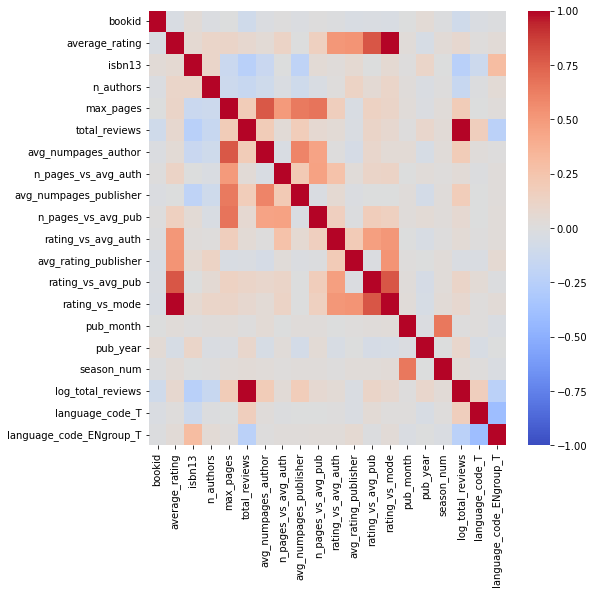

In [426]:
# plot again the heatmap of spearman correlation
num = df_model.select_dtypes(include=['int64', 'float64', 'datetime64']).columns
corr_mat = df_model[num].corr(method='spearman')
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corr_mat, cmap='coolwarm', annot=False, fmt='.2f', vmin=-1, vmax=1)

In [427]:
df_model.columns

Index(['bookid', 'title', 'authors', 'average_rating', 'isbn', 'isbn13', 'language_code', 'publication_date', 'publisher', 'title2', 'author2', 'genre', 'multiple_authors', 'n_authors', 'authors_list', 'main_author', 'max_pages', 'total_reviews', 'avg_numpages_author', 'n_pages_vs_avg_auth', 'avg_numpages_publisher', 'n_pages_vs_avg_pub', 'rating_vs_avg_auth', 'avg_rating_publisher', 'rating_vs_avg_pub', 'rating_vs_mode', 'pub_month', 'pub_year', 'pub_month_text', 'season', 'season_num', 'language_code_ENgroup', 'ratings_count_category', 'ratings_count_category_T', 'text_reviews_count_category', 'text_reviews_count_category_T', 'log_total_reviews', 'total_reviews_category', 'total_reviews_category_T', 'language_code_T', 'language_code_ENgroup_T', 'num_pages_cat', 'max_pages_cat', 'num_pages_cat_T', 'max_pages_cat_T', 'average_rating_cat', 'average_rating_cat_T'], dtype='object')

In [428]:
columns_list = df_model[['title','average_rating','bookid', 'authors','isbn13', 'isbn', 'language_code', 'publication_date', 'publisher', 'title2', 'author2', 'genre', 'multiple_authors', 'n_authors', 'authors_list', 'main_author', 'max_pages', 'total_reviews', 'avg_numpages_author', 'n_pages_vs_avg_auth', 'avg_numpages_publisher', 'n_pages_vs_avg_pub', 'rating_vs_avg_auth', 'avg_rating_publisher', 'rating_vs_avg_pub', 'rating_vs_mode', 'pub_month', 'pub_year', 'pub_month_text', 'season', 'season_num', 'language_code_ENgroup', 'ratings_count_category', 'ratings_count_category_T', 'text_reviews_count_category', 'text_reviews_count_category_T', 'log_total_reviews', 'total_reviews_category', 'total_reviews_category_T', 'language_code_T', 'language_code_ENgroup_T', 'num_pages_cat', 'max_pages_cat', 'num_pages_cat_T', 'max_pages_cat_T', 'average_rating_cat', 'average_rating_cat_T']]

In [429]:
# Check which columns are in list format
for col in columns_list:
    if type(df_model[col].tolist()) == list:
        print(f"{col} is a list.")
    else:
        print(f"{col} is not a list.")

title is a list.
average_rating is a list.
bookid is a list.
authors is a list.
isbn13 is a list.
isbn is a list.
language_code is a list.
publication_date is a list.
publisher is a list.
title2 is a list.
author2 is a list.
genre is a list.
multiple_authors is a list.
n_authors is a list.
authors_list is a list.
main_author is a list.
max_pages is a list.
total_reviews is a list.
avg_numpages_author is a list.
n_pages_vs_avg_auth is a list.
avg_numpages_publisher is a list.
n_pages_vs_avg_pub is a list.
rating_vs_avg_auth is a list.
avg_rating_publisher is a list.
rating_vs_avg_pub is a list.
rating_vs_mode is a list.
pub_month is a list.
pub_year is a list.
pub_month_text is a list.
season is a list.
season_num is a list.
language_code_ENgroup is a list.
ratings_count_category is a list.
ratings_count_category_T is a list.
text_reviews_count_category is a list.
text_reviews_count_category_T is a list.
log_total_reviews is a list.
total_reviews_category is a list.
total_reviews_catego

In [430]:
# Convert each element to a string
df_model = df_model.applymap(str)

# Encode the string values
encoder = LabelEncoder()
for col in df_model.columns:
    df_model[col] = encoder.fit_transform(df_model[col])

In [431]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10283 entries, 1847 to 4261
Data columns (total 47 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   bookid                         10283 non-null  int32
 1   title                          10283 non-null  int32
 2   authors                        10283 non-null  int32
 3   average_rating                 10283 non-null  int32
 4   isbn                           10283 non-null  int32
 5   isbn13                         10283 non-null  int32
 6   language_code                  10283 non-null  int32
 7   publication_date               10283 non-null  int32
 8   publisher                      10283 non-null  int32
 9   title2                         10283 non-null  int32
 10  author2                        10283 non-null  int32
 11  genre                          10283 non-null  int32
 12  multiple_authors               10283 non-null  int32
 13  n_authors     

### Feature selection

In [432]:
#split data into training and testing sets

X = df_model.drop('average_rating', axis=1)
y = df_model['average_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [433]:
#initializing the random forest classifier and fitting the model to the training data.

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [434]:
#array of feature importances
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

In [435]:
#create a pandas dataframe with the feature names and their corresponding importances to ease the analysis
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
indices = np.argsort(importances)[::-1]

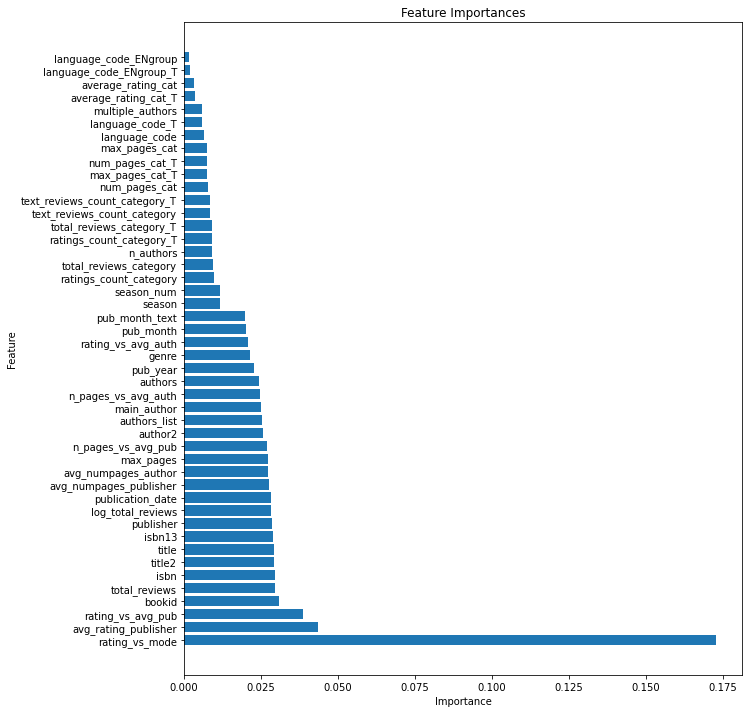

In [436]:
# sort the dataframe by importance and visualize the results using a bar chart
feature_importances = feature_importances.sort_values('importance', ascending=False)

plt.figure(figsize=(10,12))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [437]:
print("Feature ranking when y = 'average_rating':")


for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))

Feature ranking when y = 'average_rating':
1. feature 24 rating_vs_mode (0.172766)
2. feature 22 avg_rating_publisher (0.043499)
3. feature 23 rating_vs_avg_pub (0.038632)
4. feature 0 bookid (0.030803)
5. feature 16 total_reviews (0.029508)
6. feature 3 isbn (0.029379)
7. feature 8 title2 (0.029246)
8. feature 1 title (0.029185)
9. feature 4 isbn13 (0.028831)
10. feature 7 publisher (0.028525)
11. feature 35 log_total_reviews (0.028347)
12. feature 6 publication_date (0.028195)
13. feature 19 avg_numpages_publisher (0.027677)
14. feature 17 avg_numpages_author (0.027387)
15. feature 15 max_pages (0.027316)
16. feature 20 n_pages_vs_avg_pub (0.026826)
17. feature 9 author2 (0.025762)
18. feature 13 authors_list (0.025371)
19. feature 14 main_author (0.025111)
20. feature 18 n_pages_vs_avg_auth (0.024651)
21. feature 2 authors (0.024404)
22. feature 26 pub_year (0.022706)
23. feature 10 genre (0.021468)
24. feature 21 rating_vs_avg_auth (0.020691)
25. feature 25 pub_month (0.020182)
26.

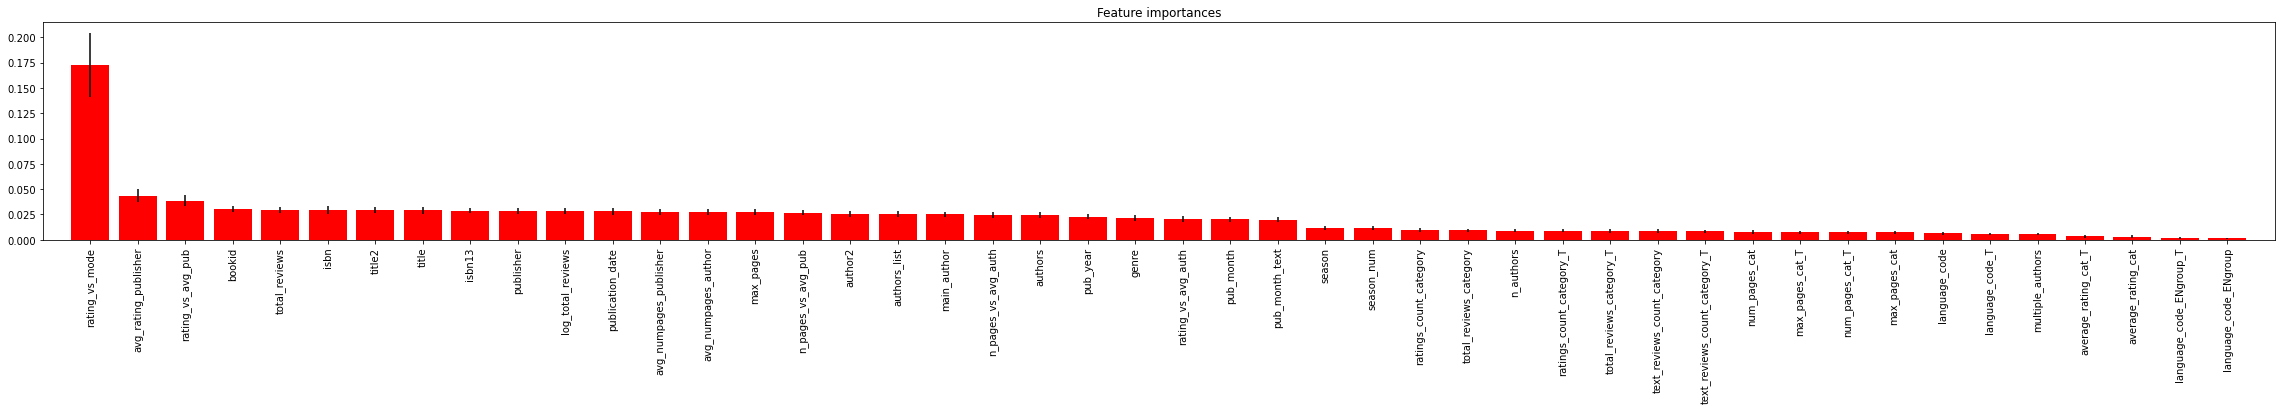

In [438]:
# Plot the feature importances of the forest
plt.figure(figsize=(40, 4))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices],rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

###### Change y as average_rating_cat

In [439]:
#split data into training and testing sets

X = df_model.drop('average_rating_cat', axis=1)
y = df_model['average_rating_cat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [440]:
#initializing the random forest classifier and fitting the model to the training data.

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [441]:
#array of feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

In [442]:
#create a pandas dataframe with the feature names and their corresponding importances to ease the analysis
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

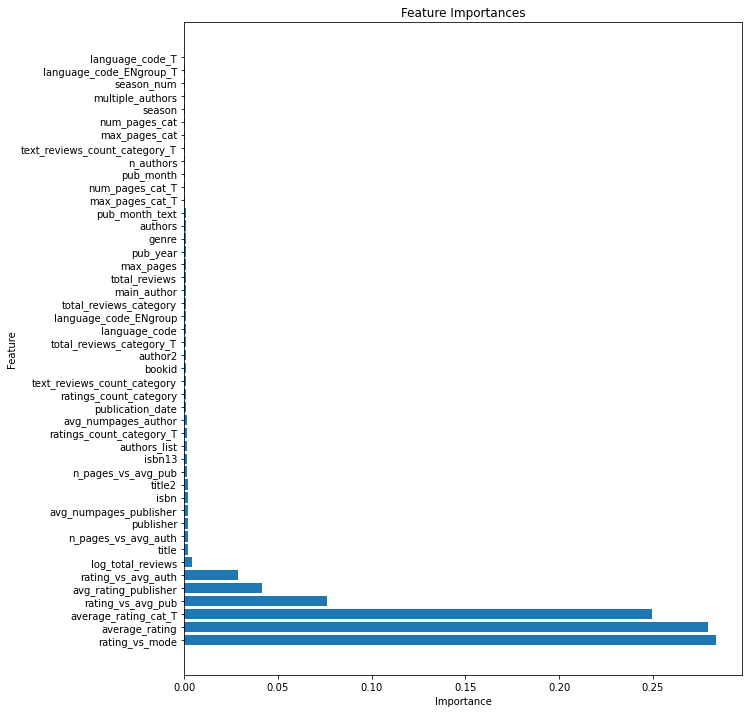

In [443]:
# sort the dataframe by importance and visualize the results using a bar chart
feature_importances = feature_importances.sort_values('importance', ascending=False)

plt.figure(figsize=(10,12))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [444]:
print("Feature ranking when y = 'average_rating_cat':")

for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))

Feature ranking when y = 'average_rating_cat':
1. feature 25 rating_vs_mode (0.283433)
2. feature 3 average_rating (0.279149)
3. feature 45 average_rating_cat_T (0.249248)
4. feature 24 rating_vs_avg_pub (0.075958)
5. feature 23 avg_rating_publisher (0.041411)
6. feature 22 rating_vs_avg_auth (0.028796)
7. feature 36 log_total_reviews (0.004055)
8. feature 1 title (0.002231)
9. feature 19 n_pages_vs_avg_auth (0.001993)
10. feature 8 publisher (0.001955)
11. feature 20 avg_numpages_publisher (0.001834)
12. feature 4 isbn (0.001812)
13. feature 9 title2 (0.001794)
14. feature 21 n_pages_vs_avg_pub (0.001686)
15. feature 5 isbn13 (0.001477)
16. feature 14 authors_list (0.001340)
17. feature 33 ratings_count_category_T (0.001292)
18. feature 18 avg_numpages_author (0.001245)
19. feature 7 publication_date (0.001179)
20. feature 32 ratings_count_category (0.001088)
21. feature 34 text_reviews_count_category (0.001037)
22. feature 0 bookid (0.001027)
23. feature 10 author2 (0.001024)
24. fea

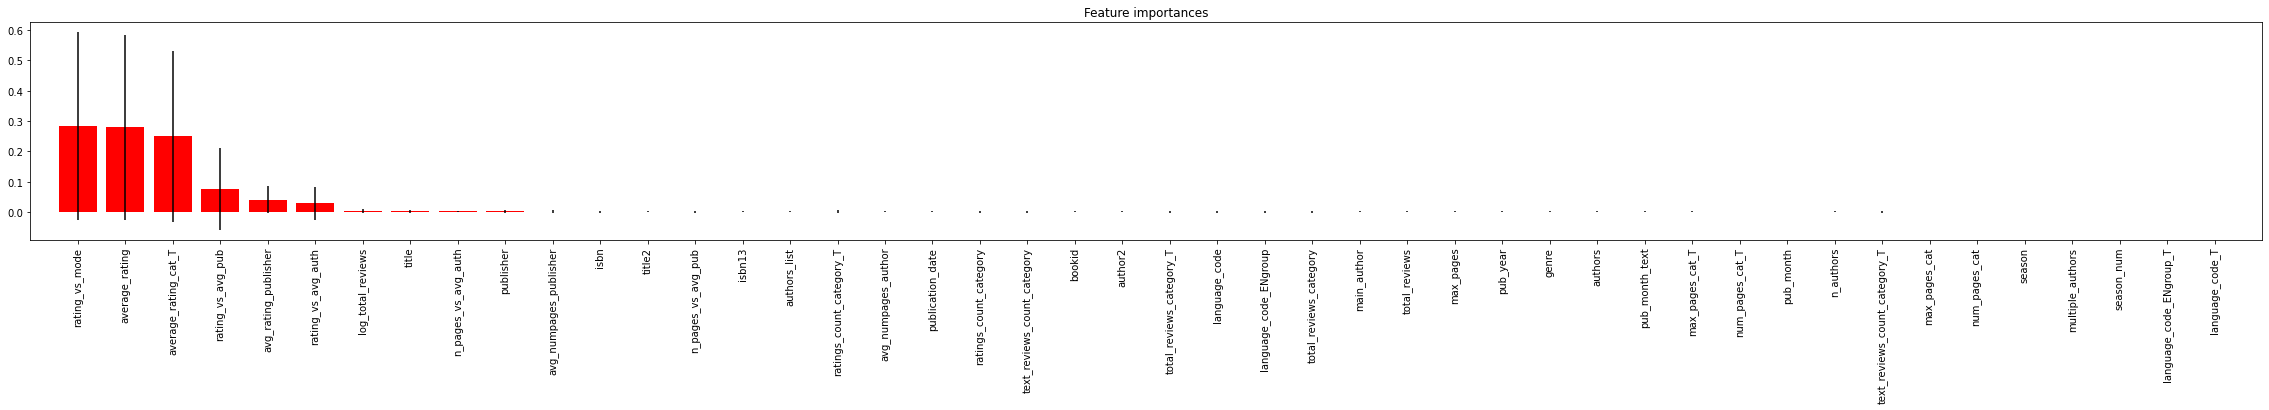

In [445]:
# Plot the feature importances of the forest
plt.figure(figsize=(40, 4))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices],rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [446]:
#feat_retain = X.columns[indices[:48]]

In [447]:
#del X, y, forest, importances, std, indices

### Recursive feature elimination with cross-validation

C:\Users\teres\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Optimal number of features : 4


C:\Users\teres\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


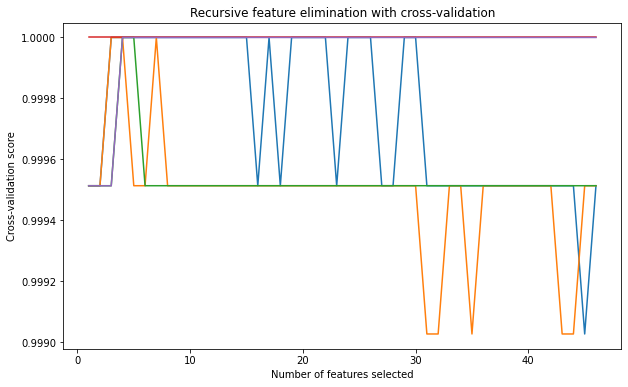

In [448]:
# Instantiate a recursive feature elimination with cross-validation object (y is average_rating_cat)
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1)

# Fit the recursive feature elimination with cross-validation object on the data
rfecv.fit(X, y)

# Print the optimal number of features selected
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot the cross-validation scores as a function of the number of features
plt.figure(figsize=(10, 6))
plt.title('Recursive feature elimination with cross-validation')
plt.xlabel('Number of features selected')
plt.ylabel('Cross-validation score')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [449]:
# The plot shows the accuracy of the model with different numbers of features selected.
# The x-axis represents the number of features selected and the y-axis represents the cross-validation accuracy score.
# The blue line represents the mean cross-validation score for each number of features selected, while the shaded blue area represents the standard deviation of the cross-validation score.

# the optimal number of features to include in the model is 4 (number of features selected that gives the highest cross-validation score)

In [450]:
raw_data_dir = r"C:\Users\teres\OneDrive\Documents\DSTI\PythonLab\project"

In [451]:
df_model.to_csv(f"{raw_data_dir}\\feature_selection.csv")

In [452]:
df.to_csv(f"{raw_data_dir}\\clean_dataset.csv")